# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='4'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

# fig, ax = plt.subplots(6,5, figsize=(15,12))
# fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax[i].imshow(img)
    
#     plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
#     ax[i].set_title(title_txt)
    i+=1

In [9]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [10]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [11]:
model = ResNet50Model()

C:\Users\Admin\anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

# for layer in model.layers[:num_feerezed_layer]:
    
#     if not isinstance(layer, K.layers.BatchNormalization):
#         layer.trainable = False
        
# Check if the trainable layers are set Correctly
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  True
conv1_pad   trainable =  True
conv1   trainable =  True
bn_conv1   trainable =  True
activation_1   trainable =  True
pool1_pad   trainable =  True
max_pooling2d_1   trainable =  True
res2a_branch2a   trainable =  True
bn2a_branch2a   trainable =  True
activation_2   trainable =  True
res2a_branch2b   trainable =  True
bn2a_branch2b   trainable =  True
activation_3   trainable =  True
res2a_branch2c   trainable =  True
res2a_branch1   trainable =  True
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  True
activation_4   trainable =  True
res2b_branch2a   trainable =  True
bn2b_branch2a   trainable =  True
activation_5   trainable =  True
res2b_branch2b   trainable =  True
bn2b_branch2b   trainable =  True
activation_6   trainable =  True
res2b_branch2c   trainable =  True
bn2b_branch2c   trainable =  True
add_2   trainable =  True
activation_7   trainable =  True
res2c_branch2a   trainable =  True
bn2c_branch2a   traina

In [13]:
batch_size = 32 # Tesla 上占用9013MB
model_root = 'models/notfreeze-models_'+str(batch_size)
checkpoint = ModelCheckpoint(os.path.join(model_root,'Best_Model.h5'),
                             verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [15]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0

time_begin = time.time()
for epoch in range(20):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/20epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
#             bar.moveto(0)
            break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/6epochs: 100%|███████████████| 412/412.0 [10:32<00:00,  1.11s/it, loss:2.92, acc:35.00%]
1/6epochs: 100%|███████████████| 412/412.0 [10:32<00:00,  1.54s/it, loss:2.92, acc:35.00%]

2/6epochs:   0%|                                                | 0/412.0 [00:00<?, ?it/s]
2/6epochs:   0%|                          | 0/412.0 [00:00<?, ?it/s, loss:3.58, acc:6.25%]
2/6epochs:   0%|                  | 1/412.0 [00:00<02:06,  3.24it/s, loss:3.58, acc:6.25%]
2/6epochs:   0%|                  | 1/412.0 [00:00<02:06,  3.24it/s, loss:3.58, acc:6.25%]
2/6epochs:   0%|                  | 1/412.0 [00:00<02:06,  3.24it/s, loss:3.81, acc:6.25%]
2/6epochs:   0%|                  | 2/412.0 [00:00<01:59,  3.44it/s, loss:3.81, acc:6.25%]
2/6epochs:   0%|                  | 2/412.0 [00:00<01:59,  3.44it/s, loss:3.81, acc:6.25%]
2/6epochs:   0%|                 | 2/412.0 [00:00<01:59,  3.44it/s, loss:3.61, acc:18.75%]
2/6epochs:   1%|                 | 3/412.0 [00:00<01:59,  3.42it/s, loss:3.61, acc:18.75%

2/6epochs:   5%|▋               | 19/412.0 [00:17<02:35,  2.52it/s, loss:3.50, acc:12.50%]
2/6epochs:   5%|▊               | 20/412.0 [00:17<02:24,  2.72it/s, loss:3.50, acc:12.50%]
2/6epochs:   5%|▊               | 20/412.0 [00:17<02:24,  2.72it/s, loss:3.50, acc:12.50%]
2/6epochs:   5%|▊                | 20/412.0 [00:17<02:24,  2.72it/s, loss:3.32, acc:9.38%]
2/6epochs:   5%|▊                | 21/412.0 [00:17<02:13,  2.93it/s, loss:3.32, acc:9.38%]
2/6epochs:   5%|▊                | 21/412.0 [00:17<02:13,  2.93it/s, loss:3.32, acc:9.38%]
2/6epochs:   5%|▊               | 21/412.0 [00:17<02:13,  2.93it/s, loss:3.65, acc:15.62%]
2/6epochs:   5%|▊               | 22/412.0 [00:17<02:09,  3.01it/s, loss:3.65, acc:15.62%]
2/6epochs:   5%|▊               | 22/412.0 [00:17<02:09,  3.01it/s, loss:3.65, acc:15.62%]
2/6epochs:   5%|▉                | 22/412.0 [00:17<02:09,  3.01it/s, loss:4.01, acc:9.38%]
2/6epochs:   6%|▉                | 23/412.0 [00:17<02:02,  3.17it/s, loss:4.01, acc:9.38%]

2/6epochs:   9%|█▌              | 39/412.0 [00:34<23:36,  3.80s/it, loss:3.33, acc:21.88%]
2/6epochs:  10%|█▌              | 40/412.0 [00:34<17:01,  2.75s/it, loss:3.33, acc:21.88%]
2/6epochs:  10%|█▌              | 40/412.0 [00:34<17:01,  2.75s/it, loss:3.33, acc:21.88%]
2/6epochs:  10%|█▋               | 40/412.0 [00:34<17:01,  2.75s/it, loss:3.62, acc:9.38%]
2/6epochs:  10%|█▋               | 41/412.0 [00:34<12:26,  2.01s/it, loss:3.62, acc:9.38%]
2/6epochs:  10%|█▋               | 41/412.0 [00:35<12:26,  2.01s/it, loss:3.62, acc:9.38%]
2/6epochs:  10%|█▌              | 41/412.0 [00:35<12:26,  2.01s/it, loss:3.57, acc:18.75%]
2/6epochs:  10%|█▋              | 42/412.0 [00:35<09:12,  1.49s/it, loss:3.57, acc:18.75%]
2/6epochs:  10%|█▋              | 42/412.0 [00:35<09:12,  1.49s/it, loss:3.57, acc:18.75%]
2/6epochs:  10%|█▋              | 42/412.0 [00:35<09:12,  1.49s/it, loss:3.60, acc:18.75%]
2/6epochs:  10%|█▋              | 43/412.0 [00:35<06:56,  1.13s/it, loss:3.60, acc:18.75%]

val:  17%|███▋                  | 68/412.0 [00:43<01:40,  3.43it/s, loss:3.39, acc:18.75%]
val:  17%|███▋                  | 68/412.0 [00:43<01:40,  3.43it/s, loss:3.63, acc:14.84%]
val:  17%|███▋                  | 68/412.0 [00:44<01:40,  3.43it/s, loss:3.53, acc:13.28%]
val:  17%|███▋                  | 68/412.0 [00:44<01:40,  3.43it/s, loss:3.43, acc:16.41%]
val:  17%|███▋                  | 68/412.0 [00:44<01:40,  3.43it/s, loss:3.79, acc:12.50%]
val:  17%|███▋                  | 68/412.0 [00:45<01:40,  3.43it/s, loss:3.52, acc:16.41%]
val:  17%|███▋                  | 68/412.0 [00:45<01:40,  3.43it/s, loss:3.58, acc:12.50%]
val:  17%|███▊                   | 68/412.0 [00:46<01:40,  3.43it/s, loss:3.66, acc:9.38%]
val:  17%|███▋                  | 68/412.0 [00:46<01:40,  3.43it/s, loss:3.88, acc:14.84%]
val:  17%|███▊                   | 68/412.0 [00:47<01:40,  3.43it/s, loss:3.87, acc:9.38%]
val:  17%|███▋                  | 68/412.0 [00:47<01:40,  3.43it/s, loss:3.80, acc:13.28%]

2/6epochs:  21%|███▍            | 88/412.0 [01:00<01:35,  3.39it/s, loss:3.44, acc:25.00%]
2/6epochs:  22%|███▍            | 89/412.0 [01:00<01:33,  3.44it/s, loss:3.44, acc:25.00%]
2/6epochs:  22%|███▍            | 89/412.0 [01:00<01:33,  3.44it/s, loss:3.44, acc:25.00%]
2/6epochs:  22%|███▍            | 89/412.0 [01:00<01:33,  3.44it/s, loss:3.40, acc:25.00%]
2/6epochs:  22%|███▍            | 90/412.0 [01:00<01:31,  3.52it/s, loss:3.40, acc:25.00%]
2/6epochs:  22%|███▍            | 90/412.0 [01:00<01:31,  3.52it/s, loss:3.40, acc:25.00%]
2/6epochs:  22%|███▋             | 90/412.0 [01:00<01:31,  3.52it/s, loss:3.31, acc:9.38%]
2/6epochs:  22%|███▊             | 91/412.0 [01:00<01:30,  3.53it/s, loss:3.31, acc:9.38%]
2/6epochs:  22%|███▊             | 91/412.0 [01:00<01:30,  3.53it/s, loss:3.31, acc:9.38%]
2/6epochs:  22%|███▌            | 91/412.0 [01:01<01:30,  3.53it/s, loss:3.22, acc:15.62%]
2/6epochs:  22%|███▌            | 92/412.0 [01:01<01:30,  3.54it/s, loss:3.22, acc:15.62%]

2/6epochs:  26%|████▏           | 108/412.0 [01:17<02:11,  2.30it/s, loss:3.60, acc:6.25%]
2/6epochs:  26%|████▏           | 109/412.0 [01:17<02:01,  2.48it/s, loss:3.60, acc:6.25%]
2/6epochs:  26%|████▏           | 109/412.0 [01:17<02:01,  2.48it/s, loss:3.60, acc:6.25%]
2/6epochs:  26%|███▉           | 109/412.0 [01:17<02:01,  2.48it/s, loss:3.07, acc:18.75%]
2/6epochs:  27%|████           | 110/412.0 [01:17<01:59,  2.53it/s, loss:3.07, acc:18.75%]
2/6epochs:  27%|████           | 110/412.0 [01:17<01:59,  2.53it/s, loss:3.07, acc:18.75%]
2/6epochs:  27%|████           | 110/412.0 [01:18<01:59,  2.53it/s, loss:3.37, acc:21.88%]
2/6epochs:  27%|████           | 111/412.0 [01:18<01:48,  2.77it/s, loss:3.37, acc:21.88%]
2/6epochs:  27%|████           | 111/412.0 [01:18<01:48,  2.77it/s, loss:3.37, acc:21.88%]
2/6epochs:  27%|████           | 111/412.0 [01:18<01:48,  2.77it/s, loss:3.11, acc:15.62%]
2/6epochs:  27%|████           | 112/412.0 [01:18<01:42,  2.93it/s, loss:3.11, acc:15.62%]

val:  31%|██████▌              | 128/412.0 [01:35<01:26,  3.30it/s, loss:3.36, acc:15.62%]
val:  31%|██████▌              | 129/412.0 [01:35<18:36,  3.94s/it, loss:3.36, acc:15.62%]
2/6epochs:  31%|████▋          | 129/412.0 [01:35<18:36,  3.94s/it, loss:3.36, acc:15.62%]
2/6epochs:  31%|████▋          | 129/412.0 [01:36<18:36,  3.94s/it, loss:3.44, acc:21.88%]
2/6epochs:  32%|████▋          | 130/412.0 [01:36<13:35,  2.89s/it, loss:3.44, acc:21.88%]
2/6epochs:  32%|████▋          | 130/412.0 [01:36<13:35,  2.89s/it, loss:3.44, acc:21.88%]
2/6epochs:  32%|████▋          | 130/412.0 [01:36<13:35,  2.89s/it, loss:3.41, acc:12.50%]
2/6epochs:  32%|████▊          | 131/412.0 [01:36<09:51,  2.11s/it, loss:3.41, acc:12.50%]
2/6epochs:  32%|████▊          | 131/412.0 [01:36<09:51,  2.11s/it, loss:3.41, acc:12.50%]
2/6epochs:  32%|████▊          | 131/412.0 [01:36<09:51,  2.11s/it, loss:3.54, acc:21.88%]
2/6epochs:  32%|████▊          | 132/412.0 [01:36<07:16,  1.56s/it, loss:3.54, acc:21.88%]

2/6epochs:  38%|█████▋         | 157/412.0 [01:45<01:32,  2.74it/s, loss:3.12, acc:15.62%]
2/6epochs:  38%|█████▊         | 158/412.0 [01:45<01:36,  2.63it/s, loss:3.12, acc:15.62%]
2/6epochs:  38%|█████▊         | 158/412.0 [01:45<01:36,  2.63it/s, loss:3.12, acc:15.62%]
val:  38%|████████             | 158/412.0 [01:45<01:36,  2.63it/s, loss:3.12, acc:15.62%]
val:  38%|████████▍             | 158/412.0 [01:45<01:36,  2.63it/s, loss:4.00, acc:8.59%]
val:  38%|████████▍             | 158/412.0 [01:46<01:36,  2.63it/s, loss:4.17, acc:7.81%]
val:  38%|████████▍             | 158/412.0 [01:46<01:36,  2.63it/s, loss:4.57, acc:8.59%]
val:  38%|████████▍             | 158/412.0 [01:47<01:36,  2.63it/s, loss:4.27, acc:8.59%]
val:  38%|████████             | 158/412.0 [01:47<01:36,  2.63it/s, loss:4.17, acc:14.06%]
val:  38%|████████▍             | 158/412.0 [01:48<01:36,  2.63it/s, loss:4.47, acc:6.25%]
val:  38%|████████▍             | 158/412.0 [01:48<01:36,  2.63it/s, loss:4.24, acc:9.38%]

2/6epochs:  43%|██████▍        | 177/412.0 [02:03<01:10,  3.34it/s, loss:3.22, acc:15.62%]
2/6epochs:  43%|██████▍        | 178/412.0 [02:03<01:09,  3.34it/s, loss:3.22, acc:15.62%]
2/6epochs:  43%|██████▍        | 178/412.0 [02:03<01:09,  3.34it/s, loss:3.22, acc:15.62%]
2/6epochs:  43%|██████▍        | 178/412.0 [02:03<01:09,  3.34it/s, loss:3.61, acc:15.62%]
2/6epochs:  43%|██████▌        | 179/412.0 [02:03<01:08,  3.40it/s, loss:3.61, acc:15.62%]
2/6epochs:  43%|██████▌        | 179/412.0 [02:03<01:08,  3.40it/s, loss:3.61, acc:15.62%]
2/6epochs:  43%|██████▉         | 179/412.0 [02:04<01:08,  3.40it/s, loss:3.83, acc:3.12%]
2/6epochs:  44%|██████▉         | 180/412.0 [02:04<01:08,  3.38it/s, loss:3.83, acc:3.12%]
2/6epochs:  44%|██████▉         | 180/412.0 [02:04<01:08,  3.38it/s, loss:3.83, acc:3.12%]
2/6epochs:  44%|██████▌        | 180/412.0 [02:04<01:08,  3.38it/s, loss:2.93, acc:15.62%]
2/6epochs:  44%|██████▌        | 181/412.0 [02:04<01:08,  3.37it/s, loss:2.93, acc:15.62%]

2/6epochs:  48%|███████▏       | 197/412.0 [02:22<02:04,  1.73it/s, loss:3.00, acc:28.12%]
2/6epochs:  48%|███████▏       | 198/412.0 [02:22<01:52,  1.91it/s, loss:3.00, acc:28.12%]
2/6epochs:  48%|███████▏       | 198/412.0 [02:22<01:52,  1.91it/s, loss:3.00, acc:28.12%]
2/6epochs:  48%|███████▏       | 198/412.0 [02:22<01:52,  1.91it/s, loss:3.05, acc:34.38%]
2/6epochs:  48%|███████▏       | 199/412.0 [02:23<01:39,  2.14it/s, loss:3.05, acc:34.38%]
2/6epochs:  48%|███████▏       | 199/412.0 [02:23<01:39,  2.14it/s, loss:3.05, acc:34.38%]
2/6epochs:  48%|███████▏       | 199/412.0 [02:23<01:39,  2.14it/s, loss:3.31, acc:15.62%]
2/6epochs:  49%|███████▎       | 200/412.0 [02:23<01:31,  2.32it/s, loss:3.31, acc:15.62%]
2/6epochs:  49%|███████▎       | 200/412.0 [02:23<01:31,  2.32it/s, loss:3.31, acc:15.62%]
2/6epochs:  49%|███████▎       | 200/412.0 [02:23<01:31,  2.32it/s, loss:3.19, acc:21.88%]
2/6epochs:  49%|███████▎       | 201/412.0 [02:23<01:35,  2.22it/s, loss:3.19, acc:21.88%]

val:  53%|███████████          | 218/412.0 [02:44<01:18,  2.48it/s, loss:3.43, acc:13.28%]
val:  53%|███████████          | 218/412.0 [02:45<01:18,  2.48it/s, loss:3.12, acc:14.84%]
val:  53%|███████████          | 218/412.0 [02:45<01:18,  2.48it/s, loss:3.35, acc:22.66%]
val:  53%|███████████          | 218/412.0 [02:45<01:18,  2.48it/s, loss:3.11, acc:15.62%]
val:  53%|███████████▏         | 219/412.0 [02:45<15:19,  4.76s/it, loss:3.11, acc:15.62%]
2/6epochs:  53%|███████▉       | 219/412.0 [02:45<15:19,  4.76s/it, loss:3.11, acc:15.62%]
2/6epochs:  53%|███████▉       | 219/412.0 [02:45<15:19,  4.76s/it, loss:3.49, acc:12.50%]
2/6epochs:  53%|████████       | 220/412.0 [02:45<10:57,  3.43s/it, loss:3.49, acc:12.50%]
2/6epochs:  53%|████████       | 220/412.0 [02:45<10:57,  3.43s/it, loss:3.49, acc:12.50%]
2/6epochs:  53%|████████       | 220/412.0 [02:46<10:57,  3.43s/it, loss:3.25, acc:18.75%]
2/6epochs:  54%|████████       | 221/412.0 [02:46<07:57,  2.50s/it, loss:3.25, acc:18.75%]

2/6epochs:  60%|████████▉      | 246/412.0 [02:57<01:16,  2.18it/s, loss:3.06, acc:25.00%]
2/6epochs:  60%|████████▉      | 247/412.0 [02:57<01:09,  2.37it/s, loss:3.06, acc:25.00%]
2/6epochs:  60%|████████▉      | 247/412.0 [02:57<01:09,  2.37it/s, loss:3.06, acc:25.00%]
2/6epochs:  60%|█████████▌      | 247/412.0 [02:57<01:09,  2.37it/s, loss:3.80, acc:9.38%]
2/6epochs:  60%|█████████▋      | 248/412.0 [02:57<01:06,  2.48it/s, loss:3.80, acc:9.38%]
2/6epochs:  60%|█████████▋      | 248/412.0 [02:57<01:06,  2.48it/s, loss:3.80, acc:9.38%]
val:  60%|█████████████▏        | 248/412.0 [02:57<01:06,  2.48it/s, loss:3.80, acc:9.38%]
val:  60%|████████████▋        | 248/412.0 [02:58<01:06,  2.48it/s, loss:3.60, acc:13.28%]
val:  60%|████████████▋        | 248/412.0 [02:59<01:06,  2.48it/s, loss:3.52, acc:15.62%]
val:  60%|████████████▋        | 248/412.0 [02:59<01:06,  2.48it/s, loss:3.43, acc:21.09%]
val:  60%|████████████▋        | 248/412.0 [03:00<01:06,  2.48it/s, loss:3.31, acc:17.97%]

2/6epochs:  65%|█████████▋     | 266/412.0 [03:19<00:58,  2.48it/s, loss:3.28, acc:25.00%]
2/6epochs:  65%|█████████▋     | 267/412.0 [03:19<01:01,  2.37it/s, loss:3.28, acc:25.00%]
2/6epochs:  65%|█████████▋     | 267/412.0 [03:19<01:01,  2.37it/s, loss:3.28, acc:25.00%]
2/6epochs:  65%|█████████▋     | 267/412.0 [03:19<01:01,  2.37it/s, loss:3.54, acc:25.00%]
2/6epochs:  65%|█████████▊     | 268/412.0 [03:19<00:54,  2.64it/s, loss:3.54, acc:25.00%]
2/6epochs:  65%|█████████▊     | 268/412.0 [03:19<00:54,  2.64it/s, loss:3.54, acc:25.00%]
2/6epochs:  65%|█████████▊     | 268/412.0 [03:19<00:54,  2.64it/s, loss:3.66, acc:15.62%]
2/6epochs:  65%|█████████▊     | 269/412.0 [03:19<00:54,  2.64it/s, loss:3.66, acc:15.62%]
2/6epochs:  65%|█████████▊     | 269/412.0 [03:19<00:54,  2.64it/s, loss:3.66, acc:15.62%]
2/6epochs:  65%|█████████▊     | 269/412.0 [03:20<00:54,  2.64it/s, loss:3.27, acc:18.75%]
2/6epochs:  66%|█████████▊     | 270/412.0 [03:20<00:58,  2.44it/s, loss:3.27, acc:18.75%]

2/6epochs:  69%|██████████▍    | 286/412.0 [03:37<01:20,  1.57it/s, loss:3.37, acc:12.50%]
2/6epochs:  70%|██████████▍    | 287/412.0 [03:37<01:09,  1.79it/s, loss:3.37, acc:12.50%]
2/6epochs:  70%|██████████▍    | 287/412.0 [03:37<01:09,  1.79it/s, loss:3.37, acc:12.50%]
2/6epochs:  70%|██████████▍    | 287/412.0 [03:37<01:09,  1.79it/s, loss:3.73, acc:15.62%]
2/6epochs:  70%|██████████▍    | 288/412.0 [03:37<00:59,  2.08it/s, loss:3.73, acc:15.62%]
2/6epochs:  70%|██████████▍    | 288/412.0 [03:38<00:59,  2.08it/s, loss:3.73, acc:15.62%]
2/6epochs:  70%|██████████▍    | 288/412.0 [03:38<00:59,  2.08it/s, loss:3.32, acc:15.62%]
2/6epochs:  70%|██████████▌    | 289/412.0 [03:38<00:53,  2.31it/s, loss:3.32, acc:15.62%]
2/6epochs:  70%|██████████▌    | 289/412.0 [03:38<00:53,  2.31it/s, loss:3.32, acc:15.62%]
2/6epochs:  70%|███████████▏    | 289/412.0 [03:38<00:53,  2.31it/s, loss:3.65, acc:9.38%]
2/6epochs:  70%|███████████▎    | 290/412.0 [03:38<00:47,  2.57it/s, loss:3.65, acc:9.38%]

val:  75%|███████████████▋     | 308/412.0 [03:54<00:31,  3.26it/s, loss:3.58, acc:14.84%]
val:  75%|███████████████▋     | 308/412.0 [03:55<00:31,  3.26it/s, loss:3.54, acc:16.41%]
val:  75%|███████████████▋     | 308/412.0 [03:55<00:31,  3.26it/s, loss:3.75, acc:13.28%]
val:  75%|███████████████▋     | 308/412.0 [03:56<00:31,  3.26it/s, loss:3.88, acc:13.28%]
val:  75%|███████████████▋     | 308/412.0 [03:56<00:31,  3.26it/s, loss:3.65, acc:14.06%]
val:  75%|███████████████▋     | 308/412.0 [03:57<00:31,  3.26it/s, loss:3.79, acc:10.94%]
val:  75%|███████████████▋     | 308/412.0 [03:57<00:31,  3.26it/s, loss:3.03, acc:21.88%]
val:  75%|███████████████▊     | 309/412.0 [03:57<07:03,  4.11s/it, loss:3.03, acc:21.88%]
2/6epochs:  75%|███████████▎   | 309/412.0 [03:57<07:03,  4.11s/it, loss:3.03, acc:21.88%]
2/6epochs:  75%|███████████▎   | 309/412.0 [03:57<07:03,  4.11s/it, loss:3.05, acc:15.62%]
2/6epochs:  75%|███████████▎   | 310/412.0 [03:57<05:04,  2.99s/it, loss:3.05, acc:15.62%]

2/6epochs:  81%|████████████▏  | 335/412.0 [04:06<00:24,  3.20it/s, loss:3.00, acc:25.00%]
2/6epochs:  82%|████████████▏  | 336/412.0 [04:06<00:23,  3.20it/s, loss:3.00, acc:25.00%]
2/6epochs:  82%|████████████▏  | 336/412.0 [04:06<00:23,  3.20it/s, loss:3.00, acc:25.00%]
2/6epochs:  82%|█████████████   | 336/412.0 [04:06<00:23,  3.20it/s, loss:3.40, acc:6.25%]
2/6epochs:  82%|█████████████   | 337/412.0 [04:06<00:23,  3.22it/s, loss:3.40, acc:6.25%]
2/6epochs:  82%|█████████████   | 337/412.0 [04:07<00:23,  3.22it/s, loss:3.40, acc:6.25%]
2/6epochs:  82%|█████████████   | 337/412.0 [04:07<00:23,  3.22it/s, loss:3.28, acc:6.25%]
2/6epochs:  82%|█████████████▏  | 338/412.0 [04:07<00:22,  3.26it/s, loss:3.28, acc:6.25%]
2/6epochs:  82%|█████████████▏  | 338/412.0 [04:07<00:22,  3.26it/s, loss:3.28, acc:6.25%]
val:  82%|██████████████████    | 338/412.0 [04:07<00:22,  3.26it/s, loss:3.28, acc:6.25%]
val:  82%|█████████████████▏   | 338/412.0 [04:08<00:22,  3.26it/s, loss:3.85, acc:15.62%]

2/6epochs:  86%|█████████████▊  | 355/412.0 [04:23<00:17,  3.23it/s, loss:3.55, acc:6.25%]
2/6epochs:  86%|█████████████▊  | 356/412.0 [04:23<00:17,  3.26it/s, loss:3.55, acc:6.25%]
2/6epochs:  86%|█████████████▊  | 356/412.0 [04:23<00:17,  3.26it/s, loss:3.55, acc:6.25%]
2/6epochs:  86%|████████████▉  | 356/412.0 [04:24<00:17,  3.26it/s, loss:3.21, acc:18.75%]
2/6epochs:  87%|████████████▉  | 357/412.0 [04:24<00:16,  3.28it/s, loss:3.21, acc:18.75%]
2/6epochs:  87%|████████████▉  | 357/412.0 [04:24<00:16,  3.28it/s, loss:3.21, acc:18.75%]
2/6epochs:  87%|████████████▉  | 357/412.0 [04:24<00:16,  3.28it/s, loss:3.19, acc:12.50%]
2/6epochs:  87%|█████████████  | 358/412.0 [04:24<00:16,  3.28it/s, loss:3.19, acc:12.50%]
2/6epochs:  87%|█████████████  | 358/412.0 [04:24<00:16,  3.28it/s, loss:3.19, acc:12.50%]
2/6epochs:  87%|█████████████▉  | 358/412.0 [04:24<00:16,  3.28it/s, loss:3.60, acc:6.25%]
2/6epochs:  87%|█████████████▉  | 359/412.0 [04:24<00:15,  3.37it/s, loss:3.60, acc:6.25%]

2/6epochs:  91%|█████████████▋ | 375/412.0 [04:41<00:25,  1.44it/s, loss:2.97, acc:31.25%]
2/6epochs:  91%|█████████████▋ | 376/412.0 [04:41<00:20,  1.75it/s, loss:2.97, acc:31.25%]
2/6epochs:  91%|█████████████▋ | 376/412.0 [04:41<00:20,  1.75it/s, loss:2.97, acc:31.25%]
2/6epochs:  91%|█████████████▋ | 376/412.0 [04:41<00:20,  1.75it/s, loss:3.47, acc:18.75%]
2/6epochs:  92%|█████████████▋ | 377/412.0 [04:41<00:17,  2.03it/s, loss:3.47, acc:18.75%]
2/6epochs:  92%|█████████████▋ | 377/412.0 [04:41<00:17,  2.03it/s, loss:3.47, acc:18.75%]
2/6epochs:  92%|█████████████▋ | 377/412.0 [04:41<00:17,  2.03it/s, loss:2.61, acc:31.25%]
2/6epochs:  92%|█████████████▊ | 378/412.0 [04:41<00:14,  2.34it/s, loss:2.61, acc:31.25%]
2/6epochs:  92%|█████████████▊ | 378/412.0 [04:41<00:14,  2.34it/s, loss:2.61, acc:31.25%]
2/6epochs:  92%|█████████████▊ | 378/412.0 [04:41<00:14,  2.34it/s, loss:2.94, acc:21.88%]
2/6epochs:  92%|█████████████▊ | 379/412.0 [04:41<00:12,  2.57it/s, loss:2.94, acc:21.88%]

val:  97%|████████████████████▎| 398/412.0 [04:55<00:04,  3.16it/s, loss:3.41, acc:15.62%]
val:  97%|████████████████████▎| 398/412.0 [04:56<00:04,  3.16it/s, loss:3.18, acc:16.41%]
val:  97%|████████████████████▎| 398/412.0 [04:56<00:04,  3.16it/s, loss:3.39, acc:23.44%]
val:  97%|████████████████████▎| 398/412.0 [04:56<00:04,  3.16it/s, loss:3.50, acc:13.28%]
val:  97%|████████████████████▎| 398/412.0 [04:57<00:04,  3.16it/s, loss:3.42, acc:19.53%]
val:  97%|████████████████████▎| 398/412.0 [04:57<00:04,  3.16it/s, loss:3.66, acc:13.28%]
val:  97%|████████████████████▎| 398/412.0 [04:58<00:04,  3.16it/s, loss:3.42, acc:14.84%]
val:  97%|████████████████████▎| 398/412.0 [04:58<00:04,  3.16it/s, loss:3.26, acc:16.41%]
val:  97%|████████████████████▎| 398/412.0 [04:59<00:04,  3.16it/s, loss:3.45, acc:14.06%]
val:  97%|████████████████████▎| 398/412.0 [04:59<00:04,  3.16it/s, loss:3.40, acc:15.62%]
val:  97%|████████████████████▎| 399/412.0 [04:59<00:47,  3.64s/it, loss:3.40, acc:15.62%]

4/6epochs:   3%|▍               | 12/412.0 [00:03<01:58,  3.36it/s, loss:3.16, acc:25.00%]
4/6epochs:   3%|▍               | 12/412.0 [00:03<01:58,  3.36it/s, loss:3.16, acc:25.00%]
4/6epochs:   3%|▍               | 12/412.0 [00:03<01:58,  3.36it/s, loss:2.91, acc:21.88%]
4/6epochs:   3%|▌               | 13/412.0 [00:03<01:58,  3.37it/s, loss:2.91, acc:21.88%]
4/6epochs:   3%|▌               | 13/412.0 [00:03<01:58,  3.37it/s, loss:2.91, acc:21.88%]
4/6epochs:   3%|▌               | 13/412.0 [00:04<01:58,  3.37it/s, loss:2.71, acc:40.62%]
4/6epochs:   3%|▌               | 14/412.0 [00:04<01:56,  3.42it/s, loss:2.71, acc:40.62%]
4/6epochs:   3%|▌               | 14/412.0 [00:04<01:56,  3.42it/s, loss:2.71, acc:40.62%]
4/6epochs:   3%|▌               | 14/412.0 [00:04<01:56,  3.42it/s, loss:2.49, acc:31.25%]
4/6epochs:   4%|▌               | 15/412.0 [00:04<01:56,  3.41it/s, loss:2.49, acc:31.25%]
4/6epochs:   4%|▌               | 15/412.0 [00:04<01:56,  3.41it/s, loss:2.49, acc:31.25%]

4/6epochs:   8%|█▏              | 32/412.0 [00:20<03:35,  1.76it/s, loss:2.37, acc:31.25%]
4/6epochs:   8%|█▏              | 32/412.0 [00:20<03:35,  1.76it/s, loss:2.37, acc:31.25%]
4/6epochs:   8%|█▏              | 32/412.0 [00:20<03:35,  1.76it/s, loss:2.47, acc:28.12%]
4/6epochs:   8%|█▎              | 33/412.0 [00:20<03:00,  2.10it/s, loss:2.47, acc:28.12%]
4/6epochs:   8%|█▎              | 33/412.0 [00:21<03:00,  2.10it/s, loss:2.47, acc:28.12%]
4/6epochs:   8%|█▎              | 33/412.0 [00:21<03:00,  2.10it/s, loss:2.75, acc:25.00%]
4/6epochs:   8%|█▎              | 34/412.0 [00:21<02:40,  2.35it/s, loss:2.75, acc:25.00%]
4/6epochs:   8%|█▎              | 34/412.0 [00:21<02:40,  2.35it/s, loss:2.75, acc:25.00%]
4/6epochs:   8%|█▎              | 34/412.0 [00:21<02:40,  2.35it/s, loss:2.81, acc:18.75%]
4/6epochs:   8%|█▎              | 35/412.0 [00:21<02:33,  2.46it/s, loss:2.81, acc:18.75%]
4/6epochs:   8%|█▎              | 35/412.0 [00:21<02:33,  2.46it/s, loss:2.81, acc:18.75%]

val:  13%|██▉                   | 54/412.0 [00:35<01:52,  3.18it/s, loss:3.15, acc:28.12%]
val:  13%|██▉                   | 54/412.0 [00:36<01:52,  3.18it/s, loss:3.05, acc:28.91%]
val:  13%|██▉                   | 54/412.0 [00:36<01:52,  3.18it/s, loss:2.92, acc:26.56%]
val:  13%|██▉                   | 54/412.0 [00:37<01:52,  3.18it/s, loss:3.18, acc:22.66%]
val:  13%|██▉                   | 54/412.0 [00:37<01:52,  3.18it/s, loss:3.57, acc:17.19%]
val:  13%|██▉                   | 54/412.0 [00:38<01:52,  3.18it/s, loss:3.41, acc:25.00%]
val:  13%|██▉                   | 54/412.0 [00:38<01:52,  3.18it/s, loss:3.38, acc:21.51%]
val:  13%|██▉                   | 54/412.0 [00:39<01:52,  3.18it/s, loss:3.21, acc:25.78%]
val:  13%|██▉                   | 54/412.0 [00:39<01:52,  3.18it/s, loss:2.84, acc:21.88%]
val:  13%|██▉                   | 55/412.0 [00:39<22:19,  3.75s/it, loss:2.84, acc:21.88%]
4/6epochs:  13%|██▏             | 55/412.0 [00:39<22:19,  3.75s/it, loss:2.84, acc:21.88%]

4/6epochs:  20%|███▏            | 81/412.0 [00:47<01:43,  3.18it/s, loss:3.09, acc:21.88%]
4/6epochs:  20%|███▏            | 81/412.0 [00:47<01:43,  3.18it/s, loss:3.09, acc:21.88%]
4/6epochs:  20%|███▏            | 81/412.0 [00:47<01:43,  3.18it/s, loss:2.84, acc:25.00%]
4/6epochs:  20%|███▏            | 82/412.0 [00:47<01:42,  3.22it/s, loss:2.84, acc:25.00%]
4/6epochs:  20%|███▏            | 82/412.0 [00:47<01:42,  3.22it/s, loss:2.84, acc:25.00%]
4/6epochs:  20%|███▏            | 82/412.0 [00:47<01:42,  3.22it/s, loss:2.62, acc:37.50%]
4/6epochs:  20%|███▏            | 83/412.0 [00:47<01:39,  3.30it/s, loss:2.62, acc:37.50%]
4/6epochs:  20%|███▏            | 83/412.0 [00:47<01:39,  3.30it/s, loss:2.62, acc:37.50%]
4/6epochs:  20%|███▏            | 83/412.0 [00:47<01:39,  3.30it/s, loss:2.52, acc:21.88%]
4/6epochs:  20%|███▎            | 84/412.0 [00:47<01:38,  3.34it/s, loss:2.52, acc:21.88%]
4/6epochs:  20%|███▎            | 84/412.0 [00:47<01:38,  3.34it/s, loss:2.52, acc:21.88%]

4/6epochs:  25%|███▋           | 101/412.0 [01:04<01:36,  3.21it/s, loss:2.54, acc:43.75%]
4/6epochs:  25%|███▋           | 101/412.0 [01:04<01:36,  3.21it/s, loss:2.54, acc:43.75%]
4/6epochs:  25%|███▋           | 101/412.0 [01:04<01:36,  3.21it/s, loss:2.81, acc:21.88%]
4/6epochs:  25%|███▋           | 102/412.0 [01:04<01:33,  3.31it/s, loss:2.81, acc:21.88%]
4/6epochs:  25%|███▋           | 102/412.0 [01:04<01:33,  3.31it/s, loss:2.81, acc:21.88%]
4/6epochs:  25%|███▋           | 102/412.0 [01:05<01:33,  3.31it/s, loss:3.04, acc:18.75%]
4/6epochs:  25%|███▊           | 103/412.0 [01:05<01:31,  3.39it/s, loss:3.04, acc:18.75%]
4/6epochs:  25%|███▊           | 103/412.0 [01:05<01:31,  3.39it/s, loss:3.04, acc:18.75%]
4/6epochs:  25%|███▊           | 103/412.0 [01:05<01:31,  3.39it/s, loss:2.61, acc:28.12%]
4/6epochs:  25%|███▊           | 104/412.0 [01:05<01:31,  3.37it/s, loss:2.61, acc:28.12%]
4/6epochs:  25%|███▊           | 104/412.0 [01:05<01:31,  3.37it/s, loss:2.61, acc:28.12%]

4/6epochs:  29%|████▍          | 121/412.0 [01:21<03:16,  1.48it/s, loss:2.66, acc:25.00%]
4/6epochs:  29%|████▍          | 121/412.0 [01:21<03:16,  1.48it/s, loss:2.66, acc:25.00%]
4/6epochs:  29%|████▍          | 121/412.0 [01:21<03:16,  1.48it/s, loss:2.53, acc:34.38%]
4/6epochs:  30%|████▍          | 122/412.0 [01:21<02:47,  1.73it/s, loss:2.53, acc:34.38%]
4/6epochs:  30%|████▍          | 122/412.0 [01:21<02:47,  1.73it/s, loss:2.53, acc:34.38%]
4/6epochs:  30%|████▍          | 122/412.0 [01:22<02:47,  1.73it/s, loss:2.39, acc:34.38%]
4/6epochs:  30%|████▍          | 123/412.0 [01:22<02:23,  2.02it/s, loss:2.39, acc:34.38%]
4/6epochs:  30%|████▍          | 123/412.0 [01:22<02:23,  2.02it/s, loss:2.39, acc:34.38%]
4/6epochs:  30%|████▍          | 123/412.0 [01:22<02:23,  2.02it/s, loss:2.77, acc:34.38%]
4/6epochs:  30%|████▌          | 124/412.0 [01:22<02:06,  2.28it/s, loss:2.77, acc:34.38%]
4/6epochs:  30%|████▌          | 124/412.0 [01:22<02:06,  2.28it/s, loss:2.77, acc:34.38%]

val:  35%|███████▎             | 144/412.0 [01:36<01:20,  3.34it/s, loss:3.05, acc:25.00%]
val:  35%|███████▎             | 144/412.0 [01:36<01:20,  3.34it/s, loss:3.55, acc:25.00%]
val:  35%|███████▎             | 144/412.0 [01:36<01:20,  3.34it/s, loss:2.94, acc:22.66%]
val:  35%|███████▎             | 144/412.0 [01:37<01:20,  3.34it/s, loss:3.34, acc:19.53%]
val:  35%|███████▎             | 144/412.0 [01:37<01:20,  3.34it/s, loss:3.48, acc:19.53%]
val:  35%|███████▎             | 144/412.0 [01:38<01:20,  3.34it/s, loss:3.56, acc:21.09%]
val:  35%|███████▎             | 144/412.0 [01:38<01:20,  3.34it/s, loss:3.57, acc:18.28%]
val:  35%|███████▎             | 144/412.0 [01:39<01:20,  3.34it/s, loss:3.18, acc:24.22%]
val:  35%|███████▎             | 144/412.0 [01:39<01:20,  3.34it/s, loss:3.33, acc:17.19%]
val:  35%|███████▎             | 144/412.0 [01:39<01:20,  3.34it/s, loss:3.34, acc:20.31%]
val:  35%|███████▎             | 144/412.0 [01:40<01:20,  3.34it/s, loss:3.19, acc:20.31%]

4/6epochs:  41%|██████▏        | 170/412.0 [01:47<01:12,  3.35it/s, loss:2.71, acc:21.88%]
4/6epochs:  41%|██████▏        | 170/412.0 [01:47<01:12,  3.35it/s, loss:2.71, acc:21.88%]
4/6epochs:  41%|██████▏        | 170/412.0 [01:48<01:12,  3.35it/s, loss:2.84, acc:28.12%]
4/6epochs:  42%|██████▏        | 171/412.0 [01:48<01:11,  3.37it/s, loss:2.84, acc:28.12%]
4/6epochs:  42%|██████▏        | 171/412.0 [01:48<01:11,  3.37it/s, loss:2.84, acc:28.12%]
4/6epochs:  42%|██████▏        | 171/412.0 [01:48<01:11,  3.37it/s, loss:3.09, acc:21.88%]
4/6epochs:  42%|██████▎        | 172/412.0 [01:48<01:11,  3.36it/s, loss:3.09, acc:21.88%]
4/6epochs:  42%|██████▎        | 172/412.0 [01:48<01:11,  3.36it/s, loss:3.09, acc:21.88%]
4/6epochs:  42%|██████▎        | 172/412.0 [01:48<01:11,  3.36it/s, loss:2.74, acc:15.62%]
4/6epochs:  42%|██████▎        | 173/412.0 [01:48<01:11,  3.36it/s, loss:2.74, acc:15.62%]
4/6epochs:  42%|██████▎        | 173/412.0 [01:48<01:11,  3.36it/s, loss:2.74, acc:15.62%]

4/6epochs:  46%|██████▉        | 190/412.0 [02:05<01:12,  3.06it/s, loss:2.72, acc:21.88%]
4/6epochs:  46%|██████▉        | 190/412.0 [02:05<01:12,  3.06it/s, loss:2.72, acc:21.88%]
4/6epochs:  46%|██████▉        | 190/412.0 [02:05<01:12,  3.06it/s, loss:1.98, acc:46.88%]
4/6epochs:  46%|██████▉        | 191/412.0 [02:05<01:11,  3.11it/s, loss:1.98, acc:46.88%]
4/6epochs:  46%|██████▉        | 191/412.0 [02:05<01:11,  3.11it/s, loss:1.98, acc:46.88%]
4/6epochs:  46%|██████▉        | 191/412.0 [02:05<01:11,  3.11it/s, loss:2.79, acc:25.00%]
4/6epochs:  47%|██████▉        | 192/412.0 [02:05<01:10,  3.14it/s, loss:2.79, acc:25.00%]
4/6epochs:  47%|██████▉        | 192/412.0 [02:05<01:10,  3.14it/s, loss:2.79, acc:25.00%]
4/6epochs:  47%|██████▉        | 192/412.0 [02:06<01:10,  3.14it/s, loss:2.60, acc:37.50%]
4/6epochs:  47%|███████        | 193/412.0 [02:06<01:08,  3.19it/s, loss:2.60, acc:37.50%]
4/6epochs:  47%|███████        | 193/412.0 [02:06<01:08,  3.19it/s, loss:2.60, acc:37.50%]

4/6epochs:  51%|███████▋       | 210/412.0 [02:22<02:57,  1.14it/s, loss:2.50, acc:34.38%]
4/6epochs:  51%|███████▋       | 210/412.0 [02:22<02:57,  1.14it/s, loss:2.50, acc:34.38%]
4/6epochs:  51%|███████▋       | 210/412.0 [02:23<02:57,  1.14it/s, loss:2.10, acc:50.00%]
4/6epochs:  51%|███████▋       | 211/412.0 [02:23<02:21,  1.42it/s, loss:2.10, acc:50.00%]
4/6epochs:  51%|███████▋       | 211/412.0 [02:23<02:21,  1.42it/s, loss:2.10, acc:50.00%]
4/6epochs:  51%|███████▋       | 211/412.0 [02:23<02:21,  1.42it/s, loss:2.99, acc:21.88%]
4/6epochs:  51%|███████▋       | 212/412.0 [02:23<01:57,  1.70it/s, loss:2.99, acc:21.88%]
4/6epochs:  51%|███████▋       | 212/412.0 [02:23<01:57,  1.70it/s, loss:2.99, acc:21.88%]
4/6epochs:  51%|███████▋       | 212/412.0 [02:23<01:57,  1.70it/s, loss:2.70, acc:37.50%]
4/6epochs:  52%|███████▊       | 213/412.0 [02:23<01:43,  1.92it/s, loss:2.70, acc:37.50%]
4/6epochs:  52%|███████▊       | 213/412.0 [02:23<01:43,  1.92it/s, loss:2.70, acc:37.50%]

val:  57%|███████████▉         | 234/412.0 [02:36<00:53,  3.30it/s, loss:3.11, acc:27.34%]
val:  57%|███████████▉         | 234/412.0 [02:36<00:53,  3.30it/s, loss:3.20, acc:25.78%]
val:  57%|███████████▉         | 234/412.0 [02:36<00:53,  3.30it/s, loss:3.00, acc:26.56%]
val:  57%|███████████▉         | 234/412.0 [02:37<00:53,  3.30it/s, loss:3.20, acc:17.19%]
val:  57%|███████████▉         | 234/412.0 [02:37<00:53,  3.30it/s, loss:3.25, acc:24.22%]
val:  57%|███████████▉         | 234/412.0 [02:38<00:53,  3.30it/s, loss:3.27, acc:25.00%]
val:  57%|███████████▉         | 234/412.0 [02:38<00:53,  3.30it/s, loss:3.23, acc:18.28%]
val:  57%|███████████▉         | 234/412.0 [02:39<00:53,  3.30it/s, loss:3.23, acc:29.69%]
val:  57%|███████████▉         | 234/412.0 [02:39<00:53,  3.30it/s, loss:2.90, acc:35.94%]
val:  57%|███████████▉         | 234/412.0 [02:39<00:53,  3.30it/s, loss:3.11, acc:22.66%]
val:  57%|███████████▉         | 234/412.0 [02:40<00:53,  3.30it/s, loss:2.86, acc:28.12%]

4/6epochs:  63%|██████████      | 259/412.0 [02:49<00:47,  3.23it/s, loss:2.81, acc:6.25%]
4/6epochs:  63%|██████████      | 259/412.0 [02:49<00:47,  3.23it/s, loss:2.81, acc:6.25%]
4/6epochs:  63%|█████████▍     | 259/412.0 [02:49<00:47,  3.23it/s, loss:2.32, acc:21.88%]
4/6epochs:  63%|█████████▍     | 260/412.0 [02:49<00:47,  3.22it/s, loss:2.32, acc:21.88%]
4/6epochs:  63%|█████████▍     | 260/412.0 [02:49<00:47,  3.22it/s, loss:2.32, acc:21.88%]
4/6epochs:  63%|█████████▍     | 260/412.0 [02:49<00:47,  3.22it/s, loss:2.28, acc:40.62%]
4/6epochs:  63%|█████████▌     | 261/412.0 [02:49<00:45,  3.35it/s, loss:2.28, acc:40.62%]
4/6epochs:  63%|█████████▌     | 261/412.0 [02:49<00:45,  3.35it/s, loss:2.28, acc:40.62%]
4/6epochs:  63%|█████████▌     | 261/412.0 [02:49<00:45,  3.35it/s, loss:2.28, acc:46.88%]
4/6epochs:  64%|█████████▌     | 262/412.0 [02:49<00:45,  3.31it/s, loss:2.28, acc:46.88%]
4/6epochs:  64%|█████████▌     | 262/412.0 [02:50<00:45,  3.31it/s, loss:2.28, acc:46.88%]

4/6epochs:  68%|██████████▏    | 279/412.0 [03:07<00:43,  3.06it/s, loss:1.95, acc:59.38%]
4/6epochs:  68%|██████████▏    | 279/412.0 [03:07<00:43,  3.06it/s, loss:1.95, acc:59.38%]
4/6epochs:  68%|██████████▏    | 279/412.0 [03:08<00:43,  3.06it/s, loss:2.55, acc:25.00%]
4/6epochs:  68%|██████████▏    | 280/412.0 [03:08<00:41,  3.21it/s, loss:2.55, acc:25.00%]
4/6epochs:  68%|██████████▏    | 280/412.0 [03:08<00:41,  3.21it/s, loss:2.55, acc:25.00%]
4/6epochs:  68%|██████████▏    | 280/412.0 [03:08<00:41,  3.21it/s, loss:2.74, acc:28.12%]
4/6epochs:  68%|██████████▏    | 281/412.0 [03:08<00:40,  3.23it/s, loss:2.74, acc:28.12%]
4/6epochs:  68%|██████████▏    | 281/412.0 [03:08<00:40,  3.23it/s, loss:2.74, acc:28.12%]
4/6epochs:  68%|██████████▏    | 281/412.0 [03:08<00:40,  3.23it/s, loss:2.82, acc:21.88%]
4/6epochs:  68%|██████████▎    | 282/412.0 [03:08<00:39,  3.26it/s, loss:2.82, acc:21.88%]
4/6epochs:  68%|██████████▎    | 282/412.0 [03:08<00:39,  3.26it/s, loss:2.82, acc:21.88%]

4/6epochs:  73%|██████████▉    | 299/412.0 [03:25<02:06,  1.12s/it, loss:2.17, acc:50.00%]
4/6epochs:  73%|██████████▉    | 299/412.0 [03:25<02:06,  1.12s/it, loss:2.17, acc:50.00%]
4/6epochs:  73%|██████████▉    | 299/412.0 [03:25<02:06,  1.12s/it, loss:1.82, acc:46.88%]
4/6epochs:  73%|██████████▉    | 300/412.0 [03:25<01:37,  1.15it/s, loss:1.82, acc:46.88%]
4/6epochs:  73%|██████████▉    | 300/412.0 [03:25<01:37,  1.15it/s, loss:1.82, acc:46.88%]
4/6epochs:  73%|██████████▉    | 300/412.0 [03:25<01:37,  1.15it/s, loss:2.43, acc:43.75%]
4/6epochs:  73%|██████████▉    | 301/412.0 [03:25<01:18,  1.42it/s, loss:2.43, acc:43.75%]
4/6epochs:  73%|██████████▉    | 301/412.0 [03:25<01:18,  1.42it/s, loss:2.43, acc:43.75%]
4/6epochs:  73%|██████████▉    | 301/412.0 [03:26<01:18,  1.42it/s, loss:2.52, acc:43.75%]
4/6epochs:  73%|██████████▉    | 302/412.0 [03:26<01:04,  1.71it/s, loss:2.52, acc:43.75%]
4/6epochs:  73%|██████████▉    | 302/412.0 [03:26<01:04,  1.71it/s, loss:2.52, acc:43.75%]

val:  79%|████████████████▌    | 324/412.0 [03:38<00:30,  2.87it/s, loss:2.90, acc:36.72%]
val:  79%|████████████████▌    | 324/412.0 [03:38<00:30,  2.87it/s, loss:2.73, acc:32.81%]
val:  79%|████████████████▌    | 324/412.0 [03:39<00:30,  2.87it/s, loss:2.96, acc:25.00%]
val:  79%|████████████████▌    | 324/412.0 [03:39<00:30,  2.87it/s, loss:2.91, acc:29.69%]
val:  79%|████████████████▌    | 324/412.0 [03:39<00:30,  2.87it/s, loss:2.84, acc:32.81%]
val:  79%|████████████████▌    | 324/412.0 [03:40<00:30,  2.87it/s, loss:3.04, acc:30.47%]
val:  79%|████████████████▌    | 324/412.0 [03:40<00:30,  2.87it/s, loss:3.11, acc:24.73%]
val:  79%|████████████████▌    | 324/412.0 [03:41<00:30,  2.87it/s, loss:3.15, acc:27.34%]
val:  79%|████████████████▌    | 324/412.0 [03:41<00:30,  2.87it/s, loss:2.80, acc:32.03%]
val:  79%|████████████████▌    | 324/412.0 [03:42<00:30,  2.87it/s, loss:2.68, acc:26.56%]
val:  79%|████████████████▌    | 324/412.0 [03:42<00:30,  2.87it/s, loss:2.71, acc:30.47%]

4/6epochs:  84%|████████████▋  | 348/412.0 [03:52<00:19,  3.28it/s, loss:2.24, acc:40.62%]
4/6epochs:  84%|████████████▋  | 348/412.0 [03:52<00:19,  3.28it/s, loss:2.24, acc:40.62%]
4/6epochs:  84%|████████████▋  | 348/412.0 [03:53<00:19,  3.28it/s, loss:2.13, acc:37.50%]
4/6epochs:  85%|████████████▋  | 349/412.0 [03:53<00:19,  3.28it/s, loss:2.13, acc:37.50%]
4/6epochs:  85%|████████████▋  | 349/412.0 [03:53<00:19,  3.28it/s, loss:2.13, acc:37.50%]
4/6epochs:  85%|████████████▋  | 349/412.0 [03:53<00:19,  3.28it/s, loss:2.72, acc:15.62%]
4/6epochs:  85%|████████████▋  | 350/412.0 [03:53<00:18,  3.28it/s, loss:2.72, acc:15.62%]
4/6epochs:  85%|████████████▋  | 350/412.0 [03:53<00:18,  3.28it/s, loss:2.72, acc:15.62%]
4/6epochs:  85%|████████████▋  | 350/412.0 [03:53<00:18,  3.28it/s, loss:2.32, acc:46.88%]
4/6epochs:  85%|████████████▊  | 351/412.0 [03:53<00:18,  3.28it/s, loss:2.32, acc:46.88%]
4/6epochs:  85%|████████████▊  | 351/412.0 [03:53<00:18,  3.28it/s, loss:2.32, acc:46.88%]

4/6epochs:  89%|█████████████▍ | 368/412.0 [04:10<00:14,  2.95it/s, loss:2.48, acc:31.25%]
4/6epochs:  89%|█████████████▍ | 368/412.0 [04:10<00:14,  2.95it/s, loss:2.48, acc:31.25%]
4/6epochs:  89%|█████████████▍ | 368/412.0 [04:11<00:14,  2.95it/s, loss:2.19, acc:37.50%]
4/6epochs:  90%|█████████████▍ | 369/412.0 [04:11<00:14,  3.04it/s, loss:2.19, acc:37.50%]
4/6epochs:  90%|█████████████▍ | 369/412.0 [04:11<00:14,  3.04it/s, loss:2.19, acc:37.50%]
4/6epochs:  90%|█████████████▍ | 369/412.0 [04:11<00:14,  3.04it/s, loss:2.44, acc:34.38%]
4/6epochs:  90%|█████████████▍ | 370/412.0 [04:11<00:13,  3.19it/s, loss:2.44, acc:34.38%]
4/6epochs:  90%|█████████████▍ | 370/412.0 [04:11<00:13,  3.19it/s, loss:2.44, acc:34.38%]
4/6epochs:  90%|█████████████▍ | 370/412.0 [04:11<00:13,  3.19it/s, loss:2.41, acc:28.12%]
4/6epochs:  90%|█████████████▌ | 371/412.0 [04:11<00:12,  3.20it/s, loss:2.41, acc:28.12%]
4/6epochs:  90%|█████████████▌ | 371/412.0 [04:11<00:12,  3.20it/s, loss:2.41, acc:28.12%]

4/6epochs:  94%|██████████████▏| 388/412.0 [04:28<00:35,  1.47s/it, loss:1.82, acc:53.12%]
4/6epochs:  94%|██████████████▏| 388/412.0 [04:28<00:35,  1.47s/it, loss:1.82, acc:53.12%]
4/6epochs:  94%|██████████████▏| 388/412.0 [04:28<00:35,  1.47s/it, loss:2.32, acc:43.75%]
4/6epochs:  94%|██████████████▏| 389/412.0 [04:28<00:25,  1.12s/it, loss:2.32, acc:43.75%]
4/6epochs:  94%|██████████████▏| 389/412.0 [04:28<00:25,  1.12s/it, loss:2.32, acc:43.75%]
4/6epochs:  94%|██████████████▏| 389/412.0 [04:28<00:25,  1.12s/it, loss:2.60, acc:31.25%]
4/6epochs:  95%|██████████████▏| 390/412.0 [04:28<00:19,  1.16it/s, loss:2.60, acc:31.25%]
4/6epochs:  95%|██████████████▏| 390/412.0 [04:28<00:19,  1.16it/s, loss:2.60, acc:31.25%]
4/6epochs:  95%|██████████████▏| 390/412.0 [04:29<00:19,  1.16it/s, loss:2.20, acc:37.50%]
4/6epochs:  95%|██████████████▏| 391/412.0 [04:29<00:14,  1.45it/s, loss:2.20, acc:37.50%]
4/6epochs:  95%|██████████████▏| 391/412.0 [04:29<00:14,  1.45it/s, loss:2.20, acc:37.50%]

6/6epochs:   1%|▏                | 4/412.0 [00:01<02:00,  3.38it/s, loss:1.83, acc:53.12%]
6/6epochs:   1%|▏                | 4/412.0 [00:01<02:00,  3.38it/s, loss:2.13, acc:31.25%]
6/6epochs:   1%|▏                | 5/412.0 [00:01<02:01,  3.35it/s, loss:2.13, acc:31.25%]
6/6epochs:   1%|▏                | 5/412.0 [00:01<02:01,  3.35it/s, loss:2.13, acc:31.25%]
6/6epochs:   1%|▏                | 5/412.0 [00:01<02:01,  3.35it/s, loss:2.37, acc:43.75%]
6/6epochs:   1%|▏                | 6/412.0 [00:01<01:58,  3.44it/s, loss:2.37, acc:43.75%]
6/6epochs:   1%|▏                | 6/412.0 [00:01<01:58,  3.44it/s, loss:2.37, acc:43.75%]
6/6epochs:   1%|▏                | 6/412.0 [00:02<01:58,  3.44it/s, loss:2.29, acc:43.75%]
6/6epochs:   2%|▎                | 7/412.0 [00:02<02:00,  3.37it/s, loss:2.29, acc:43.75%]
6/6epochs:   2%|▎                | 7/412.0 [00:02<02:00,  3.37it/s, loss:2.29, acc:43.75%]
6/6epochs:   2%|▎                | 7/412.0 [00:02<02:00,  3.37it/s, loss:2.26, acc:40.62%]

6/6epochs:   6%|▉               | 24/412.0 [00:18<02:05,  3.09it/s, loss:1.90, acc:46.88%]
6/6epochs:   6%|▉               | 24/412.0 [00:18<02:05,  3.09it/s, loss:1.87, acc:53.12%]
6/6epochs:   6%|▉               | 25/412.0 [00:18<01:59,  3.23it/s, loss:1.87, acc:53.12%]
6/6epochs:   6%|▉               | 25/412.0 [00:18<01:59,  3.23it/s, loss:1.87, acc:53.12%]
6/6epochs:   6%|▉               | 25/412.0 [00:18<01:59,  3.23it/s, loss:2.10, acc:43.75%]
6/6epochs:   6%|█               | 26/412.0 [00:18<01:55,  3.34it/s, loss:2.10, acc:43.75%]
6/6epochs:   6%|█               | 26/412.0 [00:18<01:55,  3.34it/s, loss:2.10, acc:43.75%]
6/6epochs:   6%|█               | 26/412.0 [00:18<01:55,  3.34it/s, loss:1.99, acc:50.00%]
6/6epochs:   7%|█               | 27/412.0 [00:18<01:52,  3.42it/s, loss:1.99, acc:50.00%]
6/6epochs:   7%|█               | 27/412.0 [00:18<01:52,  3.42it/s, loss:1.99, acc:50.00%]
6/6epochs:   7%|█               | 27/412.0 [00:19<01:52,  3.42it/s, loss:2.08, acc:43.75%]

6/6epochs:  11%|█▋              | 44/412.0 [00:34<08:46,  1.43s/it, loss:1.23, acc:75.00%]
6/6epochs:  11%|█▋              | 44/412.0 [00:35<08:46,  1.43s/it, loss:1.79, acc:62.50%]
6/6epochs:  11%|█▋              | 45/412.0 [00:35<06:47,  1.11s/it, loss:1.79, acc:62.50%]
6/6epochs:  11%|█▋              | 45/412.0 [00:35<06:47,  1.11s/it, loss:1.79, acc:62.50%]
6/6epochs:  11%|█▋              | 45/412.0 [00:35<06:47,  1.11s/it, loss:1.74, acc:43.75%]
6/6epochs:  11%|█▊              | 46/412.0 [00:35<05:17,  1.15it/s, loss:1.74, acc:43.75%]
6/6epochs:  11%|█▊              | 46/412.0 [00:35<05:17,  1.15it/s, loss:1.74, acc:43.75%]
6/6epochs:  11%|█▊              | 46/412.0 [00:35<05:17,  1.15it/s, loss:2.55, acc:34.38%]
6/6epochs:  11%|█▊              | 47/412.0 [00:35<04:12,  1.45it/s, loss:2.55, acc:34.38%]
6/6epochs:  11%|█▊              | 47/412.0 [00:35<04:12,  1.45it/s, loss:2.55, acc:34.38%]
6/6epochs:  11%|█▊              | 47/412.0 [00:35<04:12,  1.45it/s, loss:2.37, acc:43.75%]

val:  17%|███▋                  | 70/412.0 [00:46<01:36,  3.56it/s, loss:3.02, acc:34.38%]
val:  17%|███▋                  | 70/412.0 [00:46<01:36,  3.56it/s, loss:3.24, acc:34.38%]
val:  17%|███▋                  | 70/412.0 [00:47<01:36,  3.56it/s, loss:3.13, acc:25.78%]
val:  17%|███▋                  | 70/412.0 [00:47<01:36,  3.56it/s, loss:2.80, acc:34.38%]
val:  17%|███▋                  | 70/412.0 [00:48<01:36,  3.56it/s, loss:3.38, acc:27.34%]
val:  17%|███▋                  | 70/412.0 [00:48<01:36,  3.56it/s, loss:3.14, acc:28.12%]
val:  17%|███▋                  | 70/412.0 [00:48<01:36,  3.56it/s, loss:2.76, acc:27.34%]
val:  17%|███▋                  | 70/412.0 [00:49<01:36,  3.56it/s, loss:2.80, acc:38.28%]
val:  17%|███▋                  | 70/412.0 [00:49<01:36,  3.56it/s, loss:2.66, acc:34.38%]
val:  17%|███▋                  | 70/412.0 [00:50<01:36,  3.56it/s, loss:3.12, acc:29.69%]
val:  17%|███▋                  | 70/412.0 [00:50<01:36,  3.56it/s, loss:3.29, acc:29.69%]

6/6epochs:  23%|███▌            | 93/412.0 [01:00<01:31,  3.48it/s, loss:2.17, acc:40.62%]
6/6epochs:  23%|███▌            | 93/412.0 [01:00<01:31,  3.48it/s, loss:2.12, acc:46.88%]
6/6epochs:  23%|███▋            | 94/412.0 [01:00<01:31,  3.46it/s, loss:2.12, acc:46.88%]
6/6epochs:  23%|███▋            | 94/412.0 [01:00<01:31,  3.46it/s, loss:2.12, acc:46.88%]
6/6epochs:  23%|███▋            | 94/412.0 [01:01<01:31,  3.46it/s, loss:2.06, acc:59.38%]
6/6epochs:  23%|███▋            | 95/412.0 [01:01<01:30,  3.51it/s, loss:2.06, acc:59.38%]
6/6epochs:  23%|███▋            | 95/412.0 [01:01<01:30,  3.51it/s, loss:2.06, acc:59.38%]
6/6epochs:  23%|███▋            | 95/412.0 [01:01<01:30,  3.51it/s, loss:2.22, acc:37.50%]
6/6epochs:  23%|███▋            | 96/412.0 [01:01<01:29,  3.53it/s, loss:2.22, acc:37.50%]
6/6epochs:  23%|███▋            | 96/412.0 [01:01<01:29,  3.53it/s, loss:2.22, acc:37.50%]
6/6epochs:  23%|███▋            | 96/412.0 [01:01<01:29,  3.53it/s, loss:2.48, acc:31.25%]

6/6epochs:  27%|████           | 113/412.0 [01:18<02:04,  2.41it/s, loss:2.32, acc:34.38%]
6/6epochs:  27%|████           | 113/412.0 [01:18<02:04,  2.41it/s, loss:2.22, acc:43.75%]
6/6epochs:  28%|████▏          | 114/412.0 [01:18<01:52,  2.64it/s, loss:2.22, acc:43.75%]
6/6epochs:  28%|████▏          | 114/412.0 [01:18<01:52,  2.64it/s, loss:2.22, acc:43.75%]
6/6epochs:  28%|████▏          | 114/412.0 [01:18<01:52,  2.64it/s, loss:1.92, acc:40.62%]
6/6epochs:  28%|████▏          | 115/412.0 [01:18<01:43,  2.86it/s, loss:1.92, acc:40.62%]
6/6epochs:  28%|████▏          | 115/412.0 [01:18<01:43,  2.86it/s, loss:1.92, acc:40.62%]
6/6epochs:  28%|████▏          | 115/412.0 [01:19<01:43,  2.86it/s, loss:1.67, acc:50.00%]
6/6epochs:  28%|████▏          | 116/412.0 [01:19<01:38,  3.01it/s, loss:1.67, acc:50.00%]
6/6epochs:  28%|████▏          | 116/412.0 [01:19<01:38,  3.01it/s, loss:1.67, acc:50.00%]
6/6epochs:  28%|████▏          | 116/412.0 [01:19<01:38,  3.01it/s, loss:2.22, acc:37.50%]

6/6epochs:  32%|████▊          | 133/412.0 [01:36<09:18,  2.00s/it, loss:2.01, acc:46.88%]
6/6epochs:  32%|████▊          | 133/412.0 [01:36<09:18,  2.00s/it, loss:1.78, acc:56.25%]
6/6epochs:  33%|████▉          | 134/412.0 [01:36<06:54,  1.49s/it, loss:1.78, acc:56.25%]
6/6epochs:  33%|████▉          | 134/412.0 [01:36<06:54,  1.49s/it, loss:1.78, acc:56.25%]
6/6epochs:  33%|████▉          | 134/412.0 [01:36<06:54,  1.49s/it, loss:2.69, acc:43.75%]
6/6epochs:  33%|████▉          | 135/412.0 [01:36<05:14,  1.13s/it, loss:2.69, acc:43.75%]
6/6epochs:  33%|████▉          | 135/412.0 [01:37<05:14,  1.13s/it, loss:2.69, acc:43.75%]
6/6epochs:  33%|████▉          | 135/412.0 [01:37<05:14,  1.13s/it, loss:2.16, acc:37.50%]
6/6epochs:  33%|████▉          | 136/412.0 [01:37<04:02,  1.14it/s, loss:2.16, acc:37.50%]
6/6epochs:  33%|████▉          | 136/412.0 [01:37<04:02,  1.14it/s, loss:2.16, acc:37.50%]
6/6epochs:  33%|████▉          | 136/412.0 [01:37<04:02,  1.14it/s, loss:1.54, acc:56.25%]

val:  39%|████████▏            | 160/412.0 [01:47<01:20,  3.14it/s, loss:2.71, acc:33.59%]
val:  39%|████████▏            | 160/412.0 [01:47<01:20,  3.14it/s, loss:2.69, acc:32.81%]
val:  39%|████████▏            | 160/412.0 [01:48<01:20,  3.14it/s, loss:2.35, acc:43.75%]
val:  39%|████████▏            | 160/412.0 [01:48<01:20,  3.14it/s, loss:2.14, acc:42.97%]
val:  39%|████████▏            | 160/412.0 [01:49<01:20,  3.14it/s, loss:2.25, acc:41.41%]
val:  39%|████████▏            | 160/412.0 [01:49<01:20,  3.14it/s, loss:2.51, acc:39.84%]
val:  39%|████████▏            | 160/412.0 [01:50<01:20,  3.14it/s, loss:2.63, acc:32.81%]
val:  39%|████████▏            | 160/412.0 [01:50<01:20,  3.14it/s, loss:2.52, acc:39.84%]
val:  39%|████████▏            | 160/412.0 [01:51<01:20,  3.14it/s, loss:2.25, acc:39.84%]
val:  39%|████████▏            | 160/412.0 [01:51<01:20,  3.14it/s, loss:2.66, acc:32.03%]
val:  39%|████████▏            | 160/412.0 [01:52<01:20,  3.14it/s, loss:2.61, acc:39.06%]

6/6epochs:  44%|██████▋        | 182/412.0 [02:04<01:17,  2.98it/s, loss:2.46, acc:31.25%]
6/6epochs:  44%|██████▋        | 182/412.0 [02:04<01:17,  2.98it/s, loss:2.25, acc:43.75%]
6/6epochs:  44%|██████▋        | 183/412.0 [02:04<01:19,  2.88it/s, loss:2.25, acc:43.75%]
6/6epochs:  44%|██████▋        | 183/412.0 [02:04<01:19,  2.88it/s, loss:2.25, acc:43.75%]
6/6epochs:  44%|██████▋        | 183/412.0 [02:05<01:19,  2.88it/s, loss:1.83, acc:62.50%]
6/6epochs:  45%|██████▋        | 184/412.0 [02:05<01:16,  2.99it/s, loss:1.83, acc:62.50%]
6/6epochs:  45%|██████▋        | 184/412.0 [02:05<01:16,  2.99it/s, loss:1.83, acc:62.50%]
6/6epochs:  45%|██████▋        | 184/412.0 [02:05<01:16,  2.99it/s, loss:1.73, acc:50.00%]
6/6epochs:  45%|██████▋        | 185/412.0 [02:05<01:16,  2.97it/s, loss:1.73, acc:50.00%]
6/6epochs:  45%|██████▋        | 185/412.0 [02:05<01:16,  2.97it/s, loss:1.73, acc:50.00%]
6/6epochs:  45%|██████▋        | 185/412.0 [02:05<01:16,  2.97it/s, loss:1.98, acc:40.62%]

6/6epochs:  49%|███████▎       | 202/412.0 [02:21<01:16,  2.73it/s, loss:2.25, acc:31.25%]
6/6epochs:  49%|███████▎       | 202/412.0 [02:22<01:16,  2.73it/s, loss:2.51, acc:40.62%]
6/6epochs:  49%|███████▍       | 203/412.0 [02:22<01:11,  2.94it/s, loss:2.51, acc:40.62%]
6/6epochs:  49%|███████▍       | 203/412.0 [02:22<01:11,  2.94it/s, loss:2.51, acc:40.62%]
6/6epochs:  49%|███████▍       | 203/412.0 [02:22<01:11,  2.94it/s, loss:1.92, acc:46.88%]
6/6epochs:  50%|███████▍       | 204/412.0 [02:22<01:08,  3.04it/s, loss:1.92, acc:46.88%]
6/6epochs:  50%|███████▍       | 204/412.0 [02:22<01:08,  3.04it/s, loss:1.92, acc:46.88%]
6/6epochs:  50%|███████▍       | 204/412.0 [02:22<01:08,  3.04it/s, loss:1.89, acc:53.12%]
6/6epochs:  50%|███████▍       | 205/412.0 [02:22<01:06,  3.12it/s, loss:1.89, acc:53.12%]
6/6epochs:  50%|███████▍       | 205/412.0 [02:22<01:06,  3.12it/s, loss:1.89, acc:53.12%]
6/6epochs:  50%|███████▍       | 205/412.0 [02:22<01:06,  3.12it/s, loss:2.07, acc:56.25%]

6/6epochs:  54%|████████       | 222/412.0 [02:39<08:21,  2.64s/it, loss:1.74, acc:62.50%]
6/6epochs:  54%|████████       | 222/412.0 [02:39<08:21,  2.64s/it, loss:2.30, acc:37.50%]
6/6epochs:  54%|████████       | 223/412.0 [02:39<06:05,  1.93s/it, loss:2.30, acc:37.50%]
6/6epochs:  54%|████████       | 223/412.0 [02:39<06:05,  1.93s/it, loss:2.30, acc:37.50%]
6/6epochs:  54%|████████       | 223/412.0 [02:39<06:05,  1.93s/it, loss:2.20, acc:34.38%]
6/6epochs:  54%|████████▏      | 224/412.0 [02:39<04:32,  1.45s/it, loss:2.20, acc:34.38%]
6/6epochs:  54%|████████▏      | 224/412.0 [02:39<04:32,  1.45s/it, loss:2.20, acc:34.38%]
6/6epochs:  54%|████████▏      | 224/412.0 [02:39<04:32,  1.45s/it, loss:2.64, acc:46.88%]
6/6epochs:  55%|████████▏      | 225/412.0 [02:39<03:26,  1.11s/it, loss:2.64, acc:46.88%]
6/6epochs:  55%|████████▏      | 225/412.0 [02:39<03:26,  1.11s/it, loss:2.64, acc:46.88%]
6/6epochs:  55%|████████▏      | 225/412.0 [02:40<03:26,  1.11s/it, loss:2.00, acc:37.50%]

val:  61%|████████████▋        | 250/412.0 [02:48<00:47,  3.39it/s, loss:3.23, acc:22.66%]
val:  61%|████████████▋        | 250/412.0 [02:48<00:47,  3.39it/s, loss:2.97, acc:26.56%]
val:  61%|████████████▋        | 250/412.0 [02:49<00:47,  3.39it/s, loss:3.09, acc:32.03%]
val:  61%|████████████▋        | 250/412.0 [02:49<00:47,  3.39it/s, loss:2.83, acc:26.56%]
val:  61%|████████████▋        | 250/412.0 [02:50<00:47,  3.39it/s, loss:3.15, acc:24.22%]
val:  61%|████████████▋        | 250/412.0 [02:50<00:47,  3.39it/s, loss:3.13, acc:26.56%]
val:  61%|████████████▋        | 250/412.0 [02:51<00:47,  3.39it/s, loss:3.06, acc:17.19%]
val:  61%|████████████▋        | 250/412.0 [02:51<00:47,  3.39it/s, loss:3.20, acc:27.34%]
val:  61%|████████████▋        | 250/412.0 [02:52<00:47,  3.39it/s, loss:2.90, acc:28.12%]
val:  61%|████████████▋        | 250/412.0 [02:52<00:47,  3.39it/s, loss:3.36, acc:23.44%]
val:  61%|████████████▋        | 250/412.0 [02:52<00:47,  3.39it/s, loss:3.19, acc:19.53%]

6/6epochs:  66%|█████████▊     | 271/412.0 [03:05<00:41,  3.40it/s, loss:1.89, acc:46.88%]
6/6epochs:  66%|█████████▊     | 271/412.0 [03:05<00:41,  3.40it/s, loss:2.17, acc:53.12%]
6/6epochs:  66%|█████████▉     | 272/412.0 [03:05<00:40,  3.46it/s, loss:2.17, acc:53.12%]
6/6epochs:  66%|█████████▉     | 272/412.0 [03:05<00:40,  3.46it/s, loss:2.17, acc:53.12%]
6/6epochs:  66%|█████████▉     | 272/412.0 [03:05<00:40,  3.46it/s, loss:2.23, acc:46.88%]
6/6epochs:  66%|█████████▉     | 273/412.0 [03:05<00:40,  3.41it/s, loss:2.23, acc:46.88%]
6/6epochs:  66%|█████████▉     | 273/412.0 [03:05<00:40,  3.41it/s, loss:2.23, acc:46.88%]
6/6epochs:  66%|█████████▉     | 273/412.0 [03:06<00:40,  3.41it/s, loss:2.61, acc:25.00%]
6/6epochs:  67%|█████████▉     | 274/412.0 [03:06<00:40,  3.38it/s, loss:2.61, acc:25.00%]
6/6epochs:  67%|█████████▉     | 274/412.0 [03:06<00:40,  3.38it/s, loss:2.61, acc:25.00%]
6/6epochs:  67%|█████████▉     | 274/412.0 [03:06<00:40,  3.38it/s, loss:2.18, acc:46.88%]

6/6epochs:  71%|██████████▌    | 291/412.0 [03:24<00:48,  2.47it/s, loss:2.33, acc:34.38%]
6/6epochs:  71%|██████████▌    | 291/412.0 [03:24<00:48,  2.47it/s, loss:1.38, acc:62.50%]
6/6epochs:  71%|██████████▋    | 292/412.0 [03:24<00:45,  2.65it/s, loss:1.38, acc:62.50%]
6/6epochs:  71%|██████████▋    | 292/412.0 [03:24<00:45,  2.65it/s, loss:1.38, acc:62.50%]
6/6epochs:  71%|██████████▋    | 292/412.0 [03:24<00:45,  2.65it/s, loss:2.62, acc:28.12%]
6/6epochs:  71%|██████████▋    | 293/412.0 [03:24<00:41,  2.86it/s, loss:2.62, acc:28.12%]
6/6epochs:  71%|██████████▋    | 293/412.0 [03:24<00:41,  2.86it/s, loss:2.62, acc:28.12%]
6/6epochs:  71%|██████████▋    | 293/412.0 [03:25<00:41,  2.86it/s, loss:1.66, acc:53.12%]
6/6epochs:  71%|██████████▋    | 294/412.0 [03:25<00:39,  2.97it/s, loss:1.66, acc:53.12%]
6/6epochs:  71%|██████████▋    | 294/412.0 [03:25<00:39,  2.97it/s, loss:1.66, acc:53.12%]
6/6epochs:  71%|██████████▋    | 294/412.0 [03:25<00:39,  2.97it/s, loss:1.87, acc:50.00%]

6/6epochs:  75%|███████████▎   | 311/412.0 [03:41<06:13,  3.70s/it, loss:1.98, acc:37.50%]
6/6epochs:  75%|███████████▎   | 311/412.0 [03:41<06:13,  3.70s/it, loss:1.29, acc:75.00%]
6/6epochs:  76%|███████████▎   | 312/412.0 [03:41<04:28,  2.68s/it, loss:1.29, acc:75.00%]
6/6epochs:  76%|███████████▎   | 312/412.0 [03:41<04:28,  2.68s/it, loss:1.29, acc:75.00%]
6/6epochs:  76%|███████████▎   | 312/412.0 [03:42<04:28,  2.68s/it, loss:2.12, acc:53.12%]
6/6epochs:  76%|███████████▍   | 313/412.0 [03:42<03:14,  1.97s/it, loss:2.12, acc:53.12%]
6/6epochs:  76%|███████████▍   | 313/412.0 [03:42<03:14,  1.97s/it, loss:2.12, acc:53.12%]
6/6epochs:  76%|███████████▍   | 313/412.0 [03:42<03:14,  1.97s/it, loss:2.78, acc:15.62%]
6/6epochs:  76%|███████████▍   | 314/412.0 [03:42<02:23,  1.46s/it, loss:2.78, acc:15.62%]
6/6epochs:  76%|███████████▍   | 314/412.0 [03:42<02:23,  1.46s/it, loss:2.78, acc:15.62%]
6/6epochs:  76%|███████████▍   | 314/412.0 [03:42<02:23,  1.46s/it, loss:2.32, acc:40.62%]

6/6epochs:  83%|████████████▍  | 340/412.0 [03:50<00:22,  3.19it/s, loss:1.63, acc:53.12%]
val:  83%|█████████████████▎   | 340/412.0 [03:50<00:22,  3.19it/s, loss:1.63, acc:53.12%]
val:  83%|█████████████████▎   | 340/412.0 [03:51<00:22,  3.19it/s, loss:3.70, acc:22.66%]
val:  83%|█████████████████▎   | 340/412.0 [03:51<00:22,  3.19it/s, loss:3.77, acc:21.09%]
val:  83%|█████████████████▎   | 340/412.0 [03:51<00:22,  3.19it/s, loss:3.93, acc:25.00%]
val:  83%|█████████████████▎   | 340/412.0 [03:52<00:22,  3.19it/s, loss:3.89, acc:25.00%]
val:  83%|█████████████████▎   | 340/412.0 [03:52<00:22,  3.19it/s, loss:3.95, acc:22.66%]
val:  83%|█████████████████▎   | 340/412.0 [03:53<00:22,  3.19it/s, loss:3.88, acc:25.00%]
val:  83%|█████████████████▎   | 340/412.0 [03:53<00:22,  3.19it/s, loss:3.68, acc:21.09%]
val:  83%|█████████████████▎   | 340/412.0 [03:54<00:22,  3.19it/s, loss:4.28, acc:14.84%]
val:  83%|█████████████████▎   | 340/412.0 [03:54<00:22,  3.19it/s, loss:3.43, acc:25.78%]

6/6epochs:  87%|█████████████  | 360/412.0 [04:07<00:16,  3.08it/s, loss:2.17, acc:40.62%]
6/6epochs:  87%|█████████████  | 360/412.0 [04:07<00:16,  3.08it/s, loss:1.97, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 361/412.0 [04:07<00:15,  3.21it/s, loss:1.97, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 361/412.0 [04:07<00:15,  3.21it/s, loss:1.97, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 361/412.0 [04:08<00:15,  3.21it/s, loss:1.73, acc:50.00%]
6/6epochs:  88%|█████████████▏ | 362/412.0 [04:08<00:15,  3.22it/s, loss:1.73, acc:50.00%]
6/6epochs:  88%|█████████████▏ | 362/412.0 [04:08<00:15,  3.22it/s, loss:1.73, acc:50.00%]
6/6epochs:  88%|█████████████▏ | 362/412.0 [04:08<00:15,  3.22it/s, loss:1.70, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 363/412.0 [04:08<00:15,  3.26it/s, loss:1.70, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 363/412.0 [04:08<00:15,  3.26it/s, loss:1.70, acc:43.75%]
6/6epochs:  88%|█████████████▏ | 363/412.0 [04:08<00:15,  3.26it/s, loss:2.39, acc:34.38%]

6/6epochs:  92%|█████████████▊ | 380/412.0 [04:25<00:14,  2.26it/s, loss:1.74, acc:46.88%]
6/6epochs:  92%|█████████████▊ | 380/412.0 [04:25<00:14,  2.26it/s, loss:2.13, acc:37.50%]
6/6epochs:  92%|█████████████▊ | 381/412.0 [04:25<00:12,  2.48it/s, loss:2.13, acc:37.50%]
6/6epochs:  92%|█████████████▊ | 381/412.0 [04:25<00:12,  2.48it/s, loss:2.13, acc:37.50%]
6/6epochs:  92%|█████████████▊ | 381/412.0 [04:25<00:12,  2.48it/s, loss:1.92, acc:50.00%]
6/6epochs:  93%|█████████████▉ | 382/412.0 [04:25<00:11,  2.59it/s, loss:1.92, acc:50.00%]
6/6epochs:  93%|█████████████▉ | 382/412.0 [04:25<00:11,  2.59it/s, loss:1.92, acc:50.00%]
6/6epochs:  93%|█████████████▉ | 382/412.0 [04:25<00:11,  2.59it/s, loss:1.87, acc:56.25%]
6/6epochs:  93%|█████████████▉ | 383/412.0 [04:25<00:10,  2.74it/s, loss:1.87, acc:56.25%]
6/6epochs:  93%|█████████████▉ | 383/412.0 [04:25<00:10,  2.74it/s, loss:1.87, acc:56.25%]
6/6epochs:  93%|█████████████▉ | 383/412.0 [04:26<00:10,  2.74it/s, loss:1.82, acc:46.88%]

val:  97%|████████████████████▍| 400/412.0 [04:42<00:03,  3.35it/s, loss:3.05, acc:28.12%]
val:  97%|████████████████████▍| 400/412.0 [04:42<00:03,  3.35it/s, loss:1.50, acc:56.25%]
val:  97%|████████████████████▍| 401/412.0 [04:42<00:39,  3.63s/it, loss:1.50, acc:56.25%]
6/6epochs:  97%|██████████████▌| 401/412.0 [04:42<00:39,  3.63s/it, loss:1.50, acc:56.25%]
6/6epochs:  97%|██████████████▌| 401/412.0 [04:42<00:39,  3.63s/it, loss:2.26, acc:37.50%]
6/6epochs:  98%|██████████████▋| 402/412.0 [04:42<00:26,  2.63s/it, loss:2.26, acc:37.50%]
6/6epochs:  98%|██████████████▋| 402/412.0 [04:42<00:26,  2.63s/it, loss:2.26, acc:37.50%]
6/6epochs:  98%|██████████████▋| 402/412.0 [04:42<00:26,  2.63s/it, loss:1.76, acc:56.25%]
6/6epochs:  98%|██████████████▋| 403/412.0 [04:42<00:17,  1.93s/it, loss:1.76, acc:56.25%]
6/6epochs:  98%|██████████████▋| 403/412.0 [04:42<00:17,  1.93s/it, loss:1.76, acc:56.25%]
6/6epochs:  98%|██████████████▋| 403/412.0 [04:43<00:17,  1.93s/it, loss:1.74, acc:53.12%]

8/6epochs:   4%|▌               | 16/412.0 [00:05<02:03,  3.22it/s, loss:1.41, acc:56.25%]
8/6epochs:   4%|▋               | 17/412.0 [00:05<01:58,  3.33it/s, loss:1.41, acc:56.25%]
8/6epochs:   4%|▋               | 17/412.0 [00:05<01:58,  3.33it/s, loss:1.41, acc:56.25%]
8/6epochs:   4%|▋               | 17/412.0 [00:05<01:58,  3.33it/s, loss:1.56, acc:56.25%]
8/6epochs:   4%|▋               | 18/412.0 [00:05<01:57,  3.36it/s, loss:1.56, acc:56.25%]
8/6epochs:   4%|▋               | 18/412.0 [00:05<01:57,  3.36it/s, loss:1.56, acc:56.25%]
8/6epochs:   4%|▋               | 18/412.0 [00:05<01:57,  3.36it/s, loss:1.02, acc:75.00%]
8/6epochs:   5%|▋               | 19/412.0 [00:05<02:17,  2.85it/s, loss:1.02, acc:75.00%]
8/6epochs:   5%|▋               | 19/412.0 [00:06<02:17,  2.85it/s, loss:1.02, acc:75.00%]
8/6epochs:   5%|▋               | 19/412.0 [00:06<02:17,  2.85it/s, loss:1.56, acc:50.00%]
8/6epochs:   5%|▊               | 20/412.0 [00:06<02:34,  2.54it/s, loss:1.56, acc:50.00%]

8/6epochs:   9%|█▍              | 36/412.0 [00:23<02:44,  2.29it/s, loss:1.30, acc:65.62%]
8/6epochs:   9%|█▍              | 37/412.0 [00:23<02:28,  2.52it/s, loss:1.30, acc:65.62%]
8/6epochs:   9%|█▍              | 37/412.0 [00:23<02:28,  2.52it/s, loss:1.30, acc:65.62%]
8/6epochs:   9%|█▍              | 37/412.0 [00:23<02:28,  2.52it/s, loss:1.61, acc:62.50%]
8/6epochs:   9%|█▍              | 38/412.0 [00:23<02:18,  2.69it/s, loss:1.61, acc:62.50%]
8/6epochs:   9%|█▍              | 38/412.0 [00:23<02:18,  2.69it/s, loss:1.61, acc:62.50%]
8/6epochs:   9%|█▍              | 38/412.0 [00:23<02:18,  2.69it/s, loss:1.67, acc:53.12%]
8/6epochs:   9%|█▌              | 39/412.0 [00:23<02:14,  2.78it/s, loss:1.67, acc:53.12%]
8/6epochs:   9%|█▌              | 39/412.0 [00:24<02:14,  2.78it/s, loss:1.67, acc:53.12%]
8/6epochs:   9%|█▌              | 39/412.0 [00:24<02:14,  2.78it/s, loss:1.54, acc:62.50%]
8/6epochs:  10%|█▌              | 40/412.0 [00:24<02:14,  2.77it/s, loss:1.54, acc:62.50%]

val:  14%|██▉                   | 56/412.0 [00:42<02:13,  2.66it/s, loss:2.04, acc:40.62%]
val:  14%|███                   | 57/412.0 [00:42<24:48,  4.19s/it, loss:2.04, acc:40.62%]
8/6epochs:  14%|██▏             | 57/412.0 [00:42<24:48,  4.19s/it, loss:2.04, acc:40.62%]
8/6epochs:  14%|██▏             | 57/412.0 [00:43<24:48,  4.19s/it, loss:1.57, acc:53.12%]
8/6epochs:  14%|██▎             | 58/412.0 [00:43<17:48,  3.02s/it, loss:1.57, acc:53.12%]
8/6epochs:  14%|██▎             | 58/412.0 [00:43<17:48,  3.02s/it, loss:1.57, acc:53.12%]
8/6epochs:  14%|██▎             | 58/412.0 [00:43<17:48,  3.02s/it, loss:1.66, acc:59.38%]
8/6epochs:  14%|██▎             | 59/412.0 [00:43<13:03,  2.22s/it, loss:1.66, acc:59.38%]
8/6epochs:  14%|██▎             | 59/412.0 [00:43<13:03,  2.22s/it, loss:1.66, acc:59.38%]
8/6epochs:  14%|██▎             | 59/412.0 [00:43<13:03,  2.22s/it, loss:1.77, acc:50.00%]
8/6epochs:  15%|██▎             | 60/412.0 [00:43<09:38,  1.64s/it, loss:1.77, acc:50.00%]

8/6epochs:  21%|███▎            | 85/412.0 [00:51<01:37,  3.36it/s, loss:1.81, acc:40.62%]
8/6epochs:  21%|███▎            | 86/412.0 [00:51<01:37,  3.36it/s, loss:1.81, acc:40.62%]
8/6epochs:  21%|███▎            | 86/412.0 [00:51<01:37,  3.36it/s, loss:1.81, acc:40.62%]
val:  21%|████▌                 | 86/412.0 [00:51<01:37,  3.36it/s, loss:1.81, acc:40.62%]
val:  21%|████▌                 | 86/412.0 [00:52<01:37,  3.36it/s, loss:2.65, acc:38.28%]
val:  21%|████▌                 | 86/412.0 [00:52<01:37,  3.36it/s, loss:2.71, acc:42.97%]
val:  21%|████▌                 | 86/412.0 [00:53<01:37,  3.36it/s, loss:2.72, acc:39.84%]
val:  21%|████▌                 | 86/412.0 [00:53<01:37,  3.36it/s, loss:2.60, acc:33.59%]
val:  21%|████▌                 | 86/412.0 [00:54<01:37,  3.36it/s, loss:2.64, acc:43.75%]
val:  21%|████▌                 | 86/412.0 [00:54<01:37,  3.36it/s, loss:2.39, acc:42.97%]
val:  21%|████▌                 | 86/412.0 [00:54<01:37,  3.36it/s, loss:2.88, acc:35.16%]

8/6epochs:  25%|███▊           | 105/412.0 [01:09<01:31,  3.34it/s, loss:1.58, acc:59.38%]
8/6epochs:  26%|███▊           | 106/412.0 [01:09<01:32,  3.31it/s, loss:1.58, acc:59.38%]
8/6epochs:  26%|███▊           | 106/412.0 [01:09<01:32,  3.31it/s, loss:1.58, acc:59.38%]
8/6epochs:  26%|███▊           | 106/412.0 [01:09<01:32,  3.31it/s, loss:1.48, acc:59.38%]
8/6epochs:  26%|███▉           | 107/412.0 [01:09<01:29,  3.41it/s, loss:1.48, acc:59.38%]
8/6epochs:  26%|███▉           | 107/412.0 [01:09<01:29,  3.41it/s, loss:1.48, acc:59.38%]
8/6epochs:  26%|███▉           | 107/412.0 [01:09<01:29,  3.41it/s, loss:1.39, acc:62.50%]
8/6epochs:  26%|███▉           | 108/412.0 [01:09<01:29,  3.38it/s, loss:1.39, acc:62.50%]
8/6epochs:  26%|███▉           | 108/412.0 [01:09<01:29,  3.38it/s, loss:1.39, acc:62.50%]
8/6epochs:  26%|███▉           | 108/412.0 [01:09<01:29,  3.38it/s, loss:1.91, acc:46.88%]
8/6epochs:  26%|███▉           | 109/412.0 [01:09<01:32,  3.27it/s, loss:1.91, acc:46.88%]

8/6epochs:  30%|████▌          | 125/412.0 [01:27<02:30,  1.90it/s, loss:1.43, acc:50.00%]
8/6epochs:  31%|████▌          | 126/412.0 [01:27<02:17,  2.08it/s, loss:1.43, acc:50.00%]
8/6epochs:  31%|████▌          | 126/412.0 [01:27<02:17,  2.08it/s, loss:1.43, acc:50.00%]
8/6epochs:  31%|████▌          | 126/412.0 [01:27<02:17,  2.08it/s, loss:1.64, acc:46.88%]
8/6epochs:  31%|████▌          | 127/412.0 [01:27<01:59,  2.38it/s, loss:1.64, acc:46.88%]
8/6epochs:  31%|████▌          | 127/412.0 [01:27<01:59,  2.38it/s, loss:1.64, acc:46.88%]
8/6epochs:  31%|████▌          | 127/412.0 [01:27<01:59,  2.38it/s, loss:1.44, acc:62.50%]
8/6epochs:  31%|████▋          | 128/412.0 [01:27<01:55,  2.45it/s, loss:1.44, acc:62.50%]
8/6epochs:  31%|████▋          | 128/412.0 [01:28<01:55,  2.45it/s, loss:1.44, acc:62.50%]
8/6epochs:  31%|████▋          | 128/412.0 [01:28<01:55,  2.45it/s, loss:1.44, acc:56.25%]
8/6epochs:  31%|████▋          | 129/412.0 [01:28<01:53,  2.48it/s, loss:1.44, acc:56.25%]

val:  35%|███████▍             | 146/412.0 [01:45<01:20,  3.32it/s, loss:3.94, acc:25.78%]
val:  35%|███████▍             | 146/412.0 [01:46<01:20,  3.32it/s, loss:4.03, acc:31.25%]
val:  35%|███████▍             | 146/412.0 [01:46<01:20,  3.32it/s, loss:3.65, acc:29.69%]
val:  35%|███████▍             | 146/412.0 [01:46<01:20,  3.32it/s, loss:1.84, acc:56.25%]
val:  36%|███████▍             | 147/412.0 [01:46<18:32,  4.20s/it, loss:1.84, acc:56.25%]
8/6epochs:  36%|█████▎         | 147/412.0 [01:46<18:32,  4.20s/it, loss:1.84, acc:56.25%]
8/6epochs:  36%|█████▎         | 147/412.0 [01:47<18:32,  4.20s/it, loss:1.51, acc:75.00%]
8/6epochs:  36%|█████▍         | 148/412.0 [01:47<13:19,  3.03s/it, loss:1.51, acc:75.00%]
8/6epochs:  36%|█████▍         | 148/412.0 [01:47<13:19,  3.03s/it, loss:1.51, acc:75.00%]
8/6epochs:  36%|█████▍         | 148/412.0 [01:47<13:19,  3.03s/it, loss:1.00, acc:71.88%]
8/6epochs:  36%|█████▍         | 149/412.0 [01:47<09:41,  2.21s/it, loss:1.00, acc:71.88%]

8/6epochs:  42%|██████▎        | 174/412.0 [01:55<01:07,  3.53it/s, loss:1.29, acc:65.62%]
8/6epochs:  42%|██████▎        | 175/412.0 [01:55<01:08,  3.46it/s, loss:1.29, acc:65.62%]
8/6epochs:  42%|██████▎        | 175/412.0 [01:55<01:08,  3.46it/s, loss:1.29, acc:65.62%]
8/6epochs:  42%|██████▎        | 175/412.0 [01:55<01:08,  3.46it/s, loss:1.78, acc:37.50%]
8/6epochs:  43%|██████▍        | 176/412.0 [01:55<01:09,  3.41it/s, loss:1.78, acc:37.50%]
8/6epochs:  43%|██████▍        | 176/412.0 [01:55<01:09,  3.41it/s, loss:1.78, acc:37.50%]
val:  43%|████████▉            | 176/412.0 [01:55<01:09,  3.41it/s, loss:1.78, acc:37.50%]
val:  43%|████████▉            | 176/412.0 [01:56<01:09,  3.41it/s, loss:3.05, acc:32.81%]
val:  43%|████████▉            | 176/412.0 [01:56<01:09,  3.41it/s, loss:3.44, acc:32.81%]
val:  43%|████████▉            | 176/412.0 [01:57<01:09,  3.41it/s, loss:3.65, acc:36.72%]
val:  43%|████████▉            | 176/412.0 [01:58<01:09,  3.41it/s, loss:3.39, acc:34.38%]

8/6epochs:  47%|███████        | 194/412.0 [02:14<01:11,  3.04it/s, loss:1.29, acc:62.50%]
8/6epochs:  47%|███████        | 195/412.0 [02:14<01:09,  3.12it/s, loss:1.29, acc:62.50%]
8/6epochs:  47%|███████        | 195/412.0 [02:14<01:09,  3.12it/s, loss:1.29, acc:62.50%]
8/6epochs:  47%|███████        | 195/412.0 [02:14<01:09,  3.12it/s, loss:1.76, acc:50.00%]
8/6epochs:  48%|███████▏       | 196/412.0 [02:14<01:08,  3.16it/s, loss:1.76, acc:50.00%]
8/6epochs:  48%|███████▏       | 196/412.0 [02:14<01:08,  3.16it/s, loss:1.76, acc:50.00%]
8/6epochs:  48%|███████▏       | 196/412.0 [02:15<01:08,  3.16it/s, loss:1.43, acc:56.25%]
8/6epochs:  48%|███████▏       | 197/412.0 [02:15<01:07,  3.17it/s, loss:1.43, acc:56.25%]
8/6epochs:  48%|███████▏       | 197/412.0 [02:15<01:07,  3.17it/s, loss:1.43, acc:56.25%]
8/6epochs:  48%|███████▏       | 197/412.0 [02:15<01:07,  3.17it/s, loss:1.08, acc:65.62%]
8/6epochs:  48%|███████▏       | 198/412.0 [02:15<01:05,  3.25it/s, loss:1.08, acc:65.62%]

8/6epochs:  52%|███████▊       | 214/412.0 [02:32<01:57,  1.69it/s, loss:1.57, acc:59.38%]
8/6epochs:  52%|███████▊       | 215/412.0 [02:32<01:37,  2.01it/s, loss:1.57, acc:59.38%]
8/6epochs:  52%|███████▊       | 215/412.0 [02:32<01:37,  2.01it/s, loss:1.57, acc:59.38%]
8/6epochs:  52%|███████▊       | 215/412.0 [02:32<01:37,  2.01it/s, loss:1.02, acc:71.88%]
8/6epochs:  52%|███████▊       | 216/412.0 [02:32<01:33,  2.11it/s, loss:1.02, acc:71.88%]
8/6epochs:  52%|███████▊       | 216/412.0 [02:32<01:33,  2.11it/s, loss:1.02, acc:71.88%]
8/6epochs:  52%|███████▊       | 216/412.0 [02:33<01:33,  2.11it/s, loss:1.01, acc:68.75%]
8/6epochs:  53%|███████▉       | 217/412.0 [02:33<01:24,  2.32it/s, loss:1.01, acc:68.75%]
8/6epochs:  53%|███████▉       | 217/412.0 [02:33<01:24,  2.32it/s, loss:1.01, acc:68.75%]
8/6epochs:  53%|███████▉       | 217/412.0 [02:33<01:24,  2.32it/s, loss:1.52, acc:53.12%]
8/6epochs:  53%|███████▉       | 218/412.0 [02:33<01:14,  2.59it/s, loss:1.52, acc:53.12%]

val:  57%|████████████         | 236/412.0 [02:49<00:56,  3.14it/s, loss:2.39, acc:44.53%]
val:  57%|████████████         | 236/412.0 [02:50<00:56,  3.14it/s, loss:2.61, acc:42.19%]
val:  57%|████████████         | 236/412.0 [02:50<00:56,  3.14it/s, loss:2.04, acc:42.97%]
val:  57%|████████████         | 236/412.0 [02:51<00:56,  3.14it/s, loss:2.25, acc:39.84%]
val:  57%|████████████         | 236/412.0 [02:51<00:56,  3.14it/s, loss:2.40, acc:44.53%]
val:  57%|████████████         | 236/412.0 [02:52<00:56,  3.14it/s, loss:2.37, acc:43.75%]
val:  57%|████████████         | 236/412.0 [02:52<00:56,  3.14it/s, loss:1.22, acc:59.38%]
val:  58%|████████████         | 237/412.0 [02:52<12:03,  4.13s/it, loss:1.22, acc:59.38%]
8/6epochs:  58%|████████▋      | 237/412.0 [02:52<12:03,  4.13s/it, loss:1.22, acc:59.38%]
8/6epochs:  58%|████████▋      | 237/412.0 [02:52<12:03,  4.13s/it, loss:1.59, acc:59.38%]
8/6epochs:  58%|████████▋      | 238/412.0 [02:52<08:40,  2.99s/it, loss:1.59, acc:59.38%]

8/6epochs:  64%|█████████▌     | 263/412.0 [03:00<00:45,  3.31it/s, loss:0.99, acc:78.12%]
8/6epochs:  64%|█████████▌     | 264/412.0 [03:00<00:44,  3.31it/s, loss:0.99, acc:78.12%]
8/6epochs:  64%|█████████▌     | 264/412.0 [03:00<00:44,  3.31it/s, loss:0.99, acc:78.12%]
8/6epochs:  64%|█████████▌     | 264/412.0 [03:00<00:44,  3.31it/s, loss:1.35, acc:62.50%]
8/6epochs:  64%|█████████▋     | 265/412.0 [03:00<00:45,  3.26it/s, loss:1.35, acc:62.50%]
8/6epochs:  64%|█████████▋     | 265/412.0 [03:00<00:45,  3.26it/s, loss:1.35, acc:62.50%]
8/6epochs:  64%|█████████▋     | 265/412.0 [03:01<00:45,  3.26it/s, loss:1.01, acc:75.00%]
8/6epochs:  65%|█████████▋     | 266/412.0 [03:01<00:43,  3.33it/s, loss:1.01, acc:75.00%]
8/6epochs:  65%|█████████▋     | 266/412.0 [03:01<00:43,  3.33it/s, loss:1.01, acc:75.00%]
val:  65%|█████████████▌       | 266/412.0 [03:01<00:43,  3.33it/s, loss:1.01, acc:75.00%]
val:  65%|█████████████▌       | 266/412.0 [03:01<00:43,  3.33it/s, loss:2.77, acc:35.94%]

8/6epochs:  69%|██████████▎    | 283/412.0 [03:17<00:40,  3.16it/s, loss:1.15, acc:68.75%]
8/6epochs:  69%|██████████▎    | 284/412.0 [03:17<00:39,  3.21it/s, loss:1.15, acc:68.75%]
8/6epochs:  69%|██████████▎    | 284/412.0 [03:17<00:39,  3.21it/s, loss:1.15, acc:68.75%]
8/6epochs:  69%|██████████▎    | 284/412.0 [03:18<00:39,  3.21it/s, loss:1.51, acc:53.12%]
8/6epochs:  69%|██████████▍    | 285/412.0 [03:18<00:38,  3.30it/s, loss:1.51, acc:53.12%]
8/6epochs:  69%|██████████▍    | 285/412.0 [03:18<00:38,  3.30it/s, loss:1.51, acc:53.12%]
8/6epochs:  69%|██████████▍    | 285/412.0 [03:18<00:38,  3.30it/s, loss:1.41, acc:62.50%]
8/6epochs:  69%|██████████▍    | 286/412.0 [03:18<00:38,  3.30it/s, loss:1.41, acc:62.50%]
8/6epochs:  69%|██████████▍    | 286/412.0 [03:18<00:38,  3.30it/s, loss:1.41, acc:62.50%]
8/6epochs:  69%|██████████▍    | 286/412.0 [03:18<00:38,  3.30it/s, loss:1.63, acc:53.12%]
8/6epochs:  70%|██████████▍    | 287/412.0 [03:18<00:38,  3.28it/s, loss:1.63, acc:53.12%]

8/6epochs:  74%|███████████    | 303/412.0 [03:37<01:22,  1.32it/s, loss:1.50, acc:59.38%]
8/6epochs:  74%|███████████    | 304/412.0 [03:37<01:06,  1.63it/s, loss:1.50, acc:59.38%]
8/6epochs:  74%|███████████    | 304/412.0 [03:37<01:06,  1.63it/s, loss:1.50, acc:59.38%]
8/6epochs:  74%|███████████    | 304/412.0 [03:37<01:06,  1.63it/s, loss:1.24, acc:65.62%]
8/6epochs:  74%|███████████    | 305/412.0 [03:37<00:55,  1.93it/s, loss:1.24, acc:65.62%]
8/6epochs:  74%|███████████    | 305/412.0 [03:37<00:55,  1.93it/s, loss:1.24, acc:65.62%]
8/6epochs:  74%|███████████    | 305/412.0 [03:37<00:55,  1.93it/s, loss:1.20, acc:75.00%]
8/6epochs:  74%|███████████▏   | 306/412.0 [03:37<00:47,  2.21it/s, loss:1.20, acc:75.00%]
8/6epochs:  74%|███████████▏   | 306/412.0 [03:37<00:47,  2.21it/s, loss:1.20, acc:75.00%]
8/6epochs:  74%|███████████▏   | 306/412.0 [03:37<00:47,  2.21it/s, loss:1.35, acc:71.88%]
8/6epochs:  75%|███████████▏   | 307/412.0 [03:37<00:42,  2.47it/s, loss:1.35, acc:71.88%]

val:  79%|████████████████▌    | 326/412.0 [03:53<00:28,  3.06it/s, loss:2.17, acc:44.53%]
val:  79%|████████████████▌    | 326/412.0 [03:53<00:28,  3.06it/s, loss:2.79, acc:35.94%]
val:  79%|████████████████▌    | 326/412.0 [03:54<00:28,  3.06it/s, loss:2.14, acc:42.97%]
val:  79%|████████████████▌    | 326/412.0 [03:54<00:28,  3.06it/s, loss:2.30, acc:46.88%]
val:  79%|████████████████▌    | 326/412.0 [03:55<00:28,  3.06it/s, loss:2.32, acc:43.75%]
val:  79%|████████████████▌    | 326/412.0 [03:55<00:28,  3.06it/s, loss:2.19, acc:39.84%]
val:  79%|████████████████▌    | 326/412.0 [03:56<00:28,  3.06it/s, loss:2.53, acc:41.41%]
val:  79%|████████████████▌    | 326/412.0 [03:57<00:28,  3.06it/s, loss:2.86, acc:36.72%]
val:  79%|████████████████▌    | 326/412.0 [03:57<00:28,  3.06it/s, loss:2.76, acc:34.38%]
val:  79%|████████████████▌    | 326/412.0 [03:57<00:28,  3.06it/s, loss:1.51, acc:46.88%]
val:  79%|████████████████▋    | 327/412.0 [03:57<06:10,  4.36s/it, loss:1.51, acc:46.88%]

8/6epochs:  85%|████████████▊  | 352/412.0 [04:05<00:18,  3.26it/s, loss:1.41, acc:59.38%]
8/6epochs:  86%|████████████▊  | 353/412.0 [04:05<00:17,  3.38it/s, loss:1.41, acc:59.38%]
8/6epochs:  86%|████████████▊  | 353/412.0 [04:05<00:17,  3.38it/s, loss:1.41, acc:59.38%]
8/6epochs:  86%|████████████▊  | 353/412.0 [04:05<00:17,  3.38it/s, loss:1.61, acc:75.00%]
8/6epochs:  86%|████████████▉  | 354/412.0 [04:05<00:17,  3.32it/s, loss:1.61, acc:75.00%]
8/6epochs:  86%|████████████▉  | 354/412.0 [04:05<00:17,  3.32it/s, loss:1.61, acc:75.00%]
8/6epochs:  86%|████████████▉  | 354/412.0 [04:06<00:17,  3.32it/s, loss:1.44, acc:59.38%]
8/6epochs:  86%|████████████▉  | 355/412.0 [04:06<00:17,  3.30it/s, loss:1.44, acc:59.38%]
8/6epochs:  86%|████████████▉  | 355/412.0 [04:06<00:17,  3.30it/s, loss:1.44, acc:59.38%]
8/6epochs:  86%|████████████▉  | 355/412.0 [04:06<00:17,  3.30it/s, loss:1.46, acc:50.00%]
8/6epochs:  86%|████████████▉  | 356/412.0 [04:06<00:16,  3.30it/s, loss:1.46, acc:50.00%]

8/6epochs:  90%|█████████████▌ | 372/412.0 [04:24<00:13,  3.01it/s, loss:0.97, acc:71.88%]
8/6epochs:  91%|█████████████▌ | 373/412.0 [04:24<00:12,  3.08it/s, loss:0.97, acc:71.88%]
8/6epochs:  91%|█████████████▌ | 373/412.0 [04:24<00:12,  3.08it/s, loss:0.97, acc:71.88%]
8/6epochs:  91%|█████████████▌ | 373/412.0 [04:24<00:12,  3.08it/s, loss:1.63, acc:50.00%]
8/6epochs:  91%|█████████████▌ | 374/412.0 [04:24<00:11,  3.23it/s, loss:1.63, acc:50.00%]
8/6epochs:  91%|█████████████▌ | 374/412.0 [04:24<00:11,  3.23it/s, loss:1.63, acc:50.00%]
8/6epochs:  91%|█████████████▌ | 374/412.0 [04:24<00:11,  3.23it/s, loss:1.37, acc:65.62%]
8/6epochs:  91%|█████████████▋ | 375/412.0 [04:24<00:11,  3.32it/s, loss:1.37, acc:65.62%]
8/6epochs:  91%|█████████████▋ | 375/412.0 [04:24<00:11,  3.32it/s, loss:1.37, acc:65.62%]
8/6epochs:  91%|█████████████▋ | 375/412.0 [04:24<00:11,  3.32it/s, loss:1.32, acc:59.38%]
8/6epochs:  91%|█████████████▋ | 376/412.0 [04:24<00:10,  3.32it/s, loss:1.32, acc:59.38%]

8/6epochs:  95%|██████████████▎| 392/412.0 [04:42<00:18,  1.09it/s, loss:1.11, acc:75.00%]
8/6epochs:  95%|██████████████▎| 393/412.0 [04:42<00:14,  1.32it/s, loss:1.11, acc:75.00%]
8/6epochs:  95%|██████████████▎| 393/412.0 [04:42<00:14,  1.32it/s, loss:1.11, acc:75.00%]
8/6epochs:  95%|██████████████▎| 393/412.0 [04:42<00:14,  1.32it/s, loss:1.66, acc:59.38%]
8/6epochs:  96%|██████████████▎| 394/412.0 [04:42<00:11,  1.57it/s, loss:1.66, acc:59.38%]
8/6epochs:  96%|██████████████▎| 394/412.0 [04:42<00:11,  1.57it/s, loss:1.66, acc:59.38%]
8/6epochs:  96%|██████████████▎| 394/412.0 [04:42<00:11,  1.57it/s, loss:1.36, acc:71.88%]
8/6epochs:  96%|██████████████▍| 395/412.0 [04:42<00:09,  1.82it/s, loss:1.36, acc:71.88%]
8/6epochs:  96%|██████████████▍| 395/412.0 [04:42<00:09,  1.82it/s, loss:1.36, acc:71.88%]
8/6epochs:  96%|██████████████▍| 395/412.0 [04:43<00:09,  1.82it/s, loss:1.38, acc:56.25%]
8/6epochs:  96%|██████████████▍| 396/412.0 [04:43<00:07,  2.08it/s, loss:1.38, acc:56.25%]

10/6epochs:   2%|▎               | 9/412.0 [00:02<01:55,  3.49it/s, loss:0.83, acc:84.38%]
10/6epochs:   2%|▎               | 9/412.0 [00:02<01:55,  3.49it/s, loss:0.83, acc:84.38%]
10/6epochs:   2%|▎               | 9/412.0 [00:02<01:55,  3.49it/s, loss:0.91, acc:71.88%]
10/6epochs:   2%|▎              | 10/412.0 [00:02<01:58,  3.38it/s, loss:0.91, acc:71.88%]
10/6epochs:   2%|▎              | 10/412.0 [00:03<01:58,  3.38it/s, loss:0.91, acc:71.88%]
10/6epochs:   2%|▎              | 10/412.0 [00:03<01:58,  3.38it/s, loss:0.71, acc:84.38%]
10/6epochs:   3%|▍              | 11/412.0 [00:03<01:59,  3.35it/s, loss:0.71, acc:84.38%]
10/6epochs:   3%|▍              | 11/412.0 [00:03<01:59,  3.35it/s, loss:0.71, acc:84.38%]
10/6epochs:   3%|▍              | 11/412.0 [00:03<01:59,  3.35it/s, loss:1.22, acc:59.38%]
10/6epochs:   3%|▍              | 12/412.0 [00:03<01:57,  3.39it/s, loss:1.22, acc:59.38%]
10/6epochs:   3%|▍              | 12/412.0 [00:03<01:57,  3.39it/s, loss:1.22, acc:59.38%]

10/6epochs:   7%|█              | 29/412.0 [00:19<01:55,  3.30it/s, loss:1.00, acc:71.88%]
10/6epochs:   7%|█              | 29/412.0 [00:19<01:55,  3.30it/s, loss:1.00, acc:71.88%]
10/6epochs:   7%|█              | 29/412.0 [00:20<01:55,  3.30it/s, loss:1.10, acc:68.75%]
10/6epochs:   7%|█              | 30/412.0 [00:20<01:55,  3.31it/s, loss:1.10, acc:68.75%]
10/6epochs:   7%|█              | 30/412.0 [00:20<01:55,  3.31it/s, loss:1.10, acc:68.75%]
10/6epochs:   7%|█              | 30/412.0 [00:20<01:55,  3.31it/s, loss:0.88, acc:81.25%]
10/6epochs:   8%|█▏             | 31/412.0 [00:20<01:54,  3.32it/s, loss:0.88, acc:81.25%]
10/6epochs:   8%|█▏             | 31/412.0 [00:20<01:54,  3.32it/s, loss:0.88, acc:81.25%]
10/6epochs:   8%|█▏             | 31/412.0 [00:20<01:54,  3.32it/s, loss:0.81, acc:78.12%]
10/6epochs:   8%|█▏             | 32/412.0 [00:20<01:54,  3.32it/s, loss:0.81, acc:78.12%]
10/6epochs:   8%|█▏             | 32/412.0 [00:20<01:54,  3.32it/s, loss:0.81, acc:78.12%]

10/6epochs:  12%|█▊             | 49/412.0 [00:37<04:15,  1.42it/s, loss:0.76, acc:78.12%]
10/6epochs:  12%|█▊             | 49/412.0 [00:37<04:15,  1.42it/s, loss:0.76, acc:78.12%]
10/6epochs:  12%|█▊             | 49/412.0 [00:37<04:15,  1.42it/s, loss:0.71, acc:78.12%]
10/6epochs:  12%|█▊             | 50/412.0 [00:37<03:28,  1.74it/s, loss:0.71, acc:78.12%]
10/6epochs:  12%|█▊             | 50/412.0 [00:37<03:28,  1.74it/s, loss:0.71, acc:78.12%]
10/6epochs:  12%|█▊             | 50/412.0 [00:37<03:28,  1.74it/s, loss:0.73, acc:81.25%]
10/6epochs:  12%|█▊             | 51/412.0 [00:37<02:57,  2.03it/s, loss:0.73, acc:81.25%]
10/6epochs:  12%|█▊             | 51/412.0 [00:37<02:57,  2.03it/s, loss:0.73, acc:81.25%]
10/6epochs:  12%|█▊             | 51/412.0 [00:37<02:57,  2.03it/s, loss:0.83, acc:71.88%]
10/6epochs:  13%|█▉             | 52/412.0 [00:37<02:34,  2.34it/s, loss:0.83, acc:71.88%]
10/6epochs:  13%|█▉             | 52/412.0 [00:38<02:34,  2.34it/s, loss:0.83, acc:71.88%]

val:  17%|███▊                  | 72/412.0 [00:50<01:41,  3.35it/s, loss:2.89, acc:44.53%]
val:  17%|███▊                  | 72/412.0 [00:51<01:41,  3.35it/s, loss:3.11, acc:37.50%]
val:  17%|███▊                  | 72/412.0 [00:51<01:41,  3.35it/s, loss:3.10, acc:42.19%]
val:  17%|███▊                  | 72/412.0 [00:52<01:41,  3.35it/s, loss:3.56, acc:43.75%]
val:  17%|███▊                  | 72/412.0 [00:52<01:41,  3.35it/s, loss:3.23, acc:38.28%]
val:  17%|███▊                  | 72/412.0 [00:53<01:41,  3.35it/s, loss:3.20, acc:34.38%]
val:  17%|███▊                  | 72/412.0 [00:53<01:41,  3.35it/s, loss:3.27, acc:35.94%]
val:  17%|███▊                  | 72/412.0 [00:53<01:41,  3.35it/s, loss:3.82, acc:35.94%]
val:  17%|███▊                  | 72/412.0 [00:54<01:41,  3.35it/s, loss:3.05, acc:36.56%]
val:  17%|███▊                  | 72/412.0 [00:54<01:41,  3.35it/s, loss:3.97, acc:35.16%]
val:  17%|███▊                  | 72/412.0 [00:55<01:41,  3.35it/s, loss:2.95, acc:40.62%]

10/6epochs:  24%|███▌           | 98/412.0 [01:02<01:35,  3.28it/s, loss:1.07, acc:68.75%]
10/6epochs:  24%|███▌           | 98/412.0 [01:02<01:35,  3.28it/s, loss:1.07, acc:68.75%]
10/6epochs:  24%|███▌           | 98/412.0 [01:02<01:35,  3.28it/s, loss:0.74, acc:87.50%]
10/6epochs:  24%|███▌           | 99/412.0 [01:02<01:34,  3.32it/s, loss:0.74, acc:87.50%]
10/6epochs:  24%|███▌           | 99/412.0 [01:02<01:34,  3.32it/s, loss:0.74, acc:87.50%]
10/6epochs:  24%|███▌           | 99/412.0 [01:03<01:34,  3.32it/s, loss:0.95, acc:78.12%]
10/6epochs:  24%|███▍          | 100/412.0 [01:03<01:34,  3.31it/s, loss:0.95, acc:78.12%]
10/6epochs:  24%|███▍          | 100/412.0 [01:03<01:34,  3.31it/s, loss:0.95, acc:78.12%]
10/6epochs:  24%|███▍          | 100/412.0 [01:03<01:34,  3.31it/s, loss:0.89, acc:68.75%]
10/6epochs:  25%|███▍          | 101/412.0 [01:03<01:33,  3.31it/s, loss:0.89, acc:68.75%]
10/6epochs:  25%|███▍          | 101/412.0 [01:03<01:33,  3.31it/s, loss:0.89, acc:68.75%]

10/6epochs:  29%|████          | 118/412.0 [01:19<01:36,  3.06it/s, loss:0.53, acc:84.38%]
10/6epochs:  29%|████          | 118/412.0 [01:19<01:36,  3.06it/s, loss:0.53, acc:84.38%]
10/6epochs:  29%|████          | 118/412.0 [01:19<01:36,  3.06it/s, loss:0.97, acc:65.62%]
10/6epochs:  29%|████          | 119/412.0 [01:19<01:33,  3.13it/s, loss:0.97, acc:65.62%]
10/6epochs:  29%|████          | 119/412.0 [01:19<01:33,  3.13it/s, loss:0.97, acc:65.62%]
10/6epochs:  29%|████          | 119/412.0 [01:20<01:33,  3.13it/s, loss:0.86, acc:81.25%]
10/6epochs:  29%|████          | 120/412.0 [01:20<01:30,  3.23it/s, loss:0.86, acc:81.25%]
10/6epochs:  29%|████          | 120/412.0 [01:20<01:30,  3.23it/s, loss:0.86, acc:81.25%]
10/6epochs:  29%|████          | 120/412.0 [01:20<01:30,  3.23it/s, loss:0.70, acc:78.12%]
10/6epochs:  29%|████          | 121/412.0 [01:20<01:27,  3.33it/s, loss:0.70, acc:78.12%]
10/6epochs:  29%|████          | 121/412.0 [01:20<01:27,  3.33it/s, loss:0.70, acc:78.12%]

10/6epochs:  33%|████▋         | 138/412.0 [01:36<03:56,  1.16it/s, loss:1.19, acc:68.75%]
10/6epochs:  33%|████▋         | 138/412.0 [01:36<03:56,  1.16it/s, loss:1.19, acc:68.75%]
10/6epochs:  33%|████▋         | 138/412.0 [01:36<03:56,  1.16it/s, loss:0.99, acc:75.00%]
10/6epochs:  34%|████▋         | 139/412.0 [01:36<03:06,  1.46it/s, loss:0.99, acc:75.00%]
10/6epochs:  34%|████▋         | 139/412.0 [01:36<03:06,  1.46it/s, loss:0.99, acc:75.00%]
10/6epochs:  34%|████▋         | 139/412.0 [01:37<03:06,  1.46it/s, loss:0.64, acc:78.12%]
10/6epochs:  34%|████▊         | 140/412.0 [01:37<02:32,  1.78it/s, loss:0.64, acc:78.12%]
10/6epochs:  34%|████▊         | 140/412.0 [01:37<02:32,  1.78it/s, loss:0.64, acc:78.12%]
10/6epochs:  34%|████▊         | 140/412.0 [01:37<02:32,  1.78it/s, loss:0.79, acc:81.25%]
10/6epochs:  34%|████▊         | 141/412.0 [01:37<02:11,  2.07it/s, loss:0.79, acc:81.25%]
10/6epochs:  34%|████▊         | 141/412.0 [01:37<02:11,  2.07it/s, loss:0.79, acc:81.25%]

val:  39%|████████▎            | 162/412.0 [01:49<01:14,  3.35it/s, loss:3.08, acc:35.94%]
val:  39%|████████▎            | 162/412.0 [01:49<01:14,  3.35it/s, loss:3.36, acc:30.47%]
val:  39%|████████▎            | 162/412.0 [01:50<01:14,  3.35it/s, loss:2.75, acc:36.72%]
val:  39%|████████▎            | 162/412.0 [01:50<01:14,  3.35it/s, loss:3.00, acc:38.28%]
val:  39%|████████▎            | 162/412.0 [01:51<01:14,  3.35it/s, loss:3.16, acc:27.34%]
val:  39%|████████▎            | 162/412.0 [01:51<01:14,  3.35it/s, loss:3.41, acc:31.25%]
val:  39%|████████▎            | 162/412.0 [01:52<01:14,  3.35it/s, loss:2.87, acc:39.06%]
val:  39%|████████▎            | 162/412.0 [01:52<01:14,  3.35it/s, loss:3.28, acc:30.47%]
val:  39%|████████▎            | 162/412.0 [01:52<01:14,  3.35it/s, loss:3.17, acc:31.18%]
val:  39%|████████▎            | 162/412.0 [01:53<01:14,  3.35it/s, loss:3.15, acc:35.16%]
val:  39%|████████▎            | 162/412.0 [01:53<01:14,  3.35it/s, loss:2.98, acc:34.38%]

10/6epochs:  45%|██████▎       | 187/412.0 [02:02<01:08,  3.27it/s, loss:0.64, acc:84.38%]
10/6epochs:  45%|██████▎       | 187/412.0 [02:02<01:08,  3.27it/s, loss:0.64, acc:84.38%]
10/6epochs:  45%|██████▎       | 187/412.0 [02:02<01:08,  3.27it/s, loss:0.70, acc:75.00%]
10/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:06,  3.36it/s, loss:0.70, acc:75.00%]
10/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:06,  3.36it/s, loss:0.70, acc:75.00%]
10/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:06,  3.36it/s, loss:0.40, acc:93.75%]
10/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:04,  3.47it/s, loss:0.40, acc:93.75%]
10/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:04,  3.47it/s, loss:0.40, acc:93.75%]
10/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:04,  3.47it/s, loss:0.73, acc:78.12%]
10/6epochs:  46%|██████▍       | 190/412.0 [02:02<01:02,  3.52it/s, loss:0.73, acc:78.12%]
10/6epochs:  46%|██████▍       | 190/412.0 [02:02<01:02,  3.52it/s, loss:0.73, acc:78.12%]

10/6epochs:  50%|███████       | 207/412.0 [02:19<01:06,  3.06it/s, loss:0.90, acc:68.75%]
10/6epochs:  50%|███████       | 207/412.0 [02:19<01:06,  3.06it/s, loss:0.90, acc:68.75%]
10/6epochs:  50%|███████       | 207/412.0 [02:19<01:06,  3.06it/s, loss:1.01, acc:68.75%]
10/6epochs:  50%|███████       | 208/412.0 [02:19<01:04,  3.14it/s, loss:1.01, acc:68.75%]
10/6epochs:  50%|███████       | 208/412.0 [02:19<01:04,  3.14it/s, loss:1.01, acc:68.75%]
10/6epochs:  50%|███████       | 208/412.0 [02:19<01:04,  3.14it/s, loss:1.13, acc:62.50%]
10/6epochs:  51%|███████       | 209/412.0 [02:19<01:01,  3.30it/s, loss:1.13, acc:62.50%]
10/6epochs:  51%|███████       | 209/412.0 [02:19<01:01,  3.30it/s, loss:1.13, acc:62.50%]
10/6epochs:  51%|███████       | 209/412.0 [02:19<01:01,  3.30it/s, loss:0.69, acc:78.12%]
10/6epochs:  51%|███████▏      | 210/412.0 [02:19<01:00,  3.32it/s, loss:0.69, acc:78.12%]
10/6epochs:  51%|███████▏      | 210/412.0 [02:20<01:00,  3.32it/s, loss:0.69, acc:78.12%]

10/6epochs:  55%|███████▋      | 227/412.0 [02:36<03:22,  1.10s/it, loss:0.76, acc:81.25%]
10/6epochs:  55%|███████▋      | 227/412.0 [02:36<03:22,  1.10s/it, loss:0.76, acc:81.25%]
10/6epochs:  55%|███████▋      | 227/412.0 [02:36<03:22,  1.10s/it, loss:0.80, acc:71.88%]
10/6epochs:  55%|███████▋      | 228/412.0 [02:36<02:42,  1.13it/s, loss:0.80, acc:71.88%]
10/6epochs:  55%|███████▋      | 228/412.0 [02:36<02:42,  1.13it/s, loss:0.80, acc:71.88%]
10/6epochs:  55%|███████▋      | 228/412.0 [02:36<02:42,  1.13it/s, loss:0.97, acc:71.88%]
10/6epochs:  56%|███████▊      | 229/412.0 [02:36<02:08,  1.42it/s, loss:0.97, acc:71.88%]
10/6epochs:  56%|███████▊      | 229/412.0 [02:36<02:08,  1.42it/s, loss:0.97, acc:71.88%]
10/6epochs:  56%|███████▊      | 229/412.0 [02:37<02:08,  1.42it/s, loss:0.69, acc:75.00%]
10/6epochs:  56%|███████▊      | 230/412.0 [02:37<01:47,  1.70it/s, loss:0.69, acc:75.00%]
10/6epochs:  56%|███████▊      | 230/412.0 [02:37<01:47,  1.70it/s, loss:0.69, acc:75.00%]

val:  61%|████████████▊        | 252/412.0 [02:48<00:46,  3.44it/s, loss:2.75, acc:39.84%]
val:  61%|████████████▊        | 252/412.0 [02:48<00:46,  3.44it/s, loss:3.34, acc:33.59%]
val:  61%|████████████▊        | 252/412.0 [02:49<00:46,  3.44it/s, loss:3.06, acc:35.94%]
val:  61%|████████████▊        | 252/412.0 [02:49<00:46,  3.44it/s, loss:2.64, acc:45.31%]
val:  61%|████████████▊        | 252/412.0 [02:50<00:46,  3.44it/s, loss:2.64, acc:36.72%]
val:  61%|████████████▊        | 252/412.0 [02:50<00:46,  3.44it/s, loss:2.99, acc:38.28%]
val:  61%|████████████▊        | 252/412.0 [02:50<00:46,  3.44it/s, loss:3.29, acc:40.62%]
val:  61%|████████████▊        | 252/412.0 [02:51<00:46,  3.44it/s, loss:3.70, acc:35.94%]
val:  61%|████████████▊        | 252/412.0 [02:51<00:46,  3.44it/s, loss:3.53, acc:31.18%]
val:  61%|████████████▊        | 252/412.0 [02:52<00:46,  3.44it/s, loss:2.61, acc:40.62%]
val:  61%|████████████▊        | 252/412.0 [02:52<00:46,  3.44it/s, loss:3.27, acc:39.84%]

10/6epochs:  67%|█████████▍    | 276/412.0 [03:01<00:39,  3.41it/s, loss:0.67, acc:84.38%]
10/6epochs:  67%|█████████▍    | 276/412.0 [03:01<00:39,  3.41it/s, loss:0.67, acc:84.38%]
10/6epochs:  67%|█████████▍    | 276/412.0 [03:02<00:39,  3.41it/s, loss:1.05, acc:68.75%]
10/6epochs:  67%|█████████▍    | 277/412.0 [03:02<00:40,  3.36it/s, loss:1.05, acc:68.75%]
10/6epochs:  67%|█████████▍    | 277/412.0 [03:02<00:40,  3.36it/s, loss:1.05, acc:68.75%]
10/6epochs:  67%|█████████▍    | 277/412.0 [03:02<00:40,  3.36it/s, loss:0.58, acc:81.25%]
10/6epochs:  67%|█████████▍    | 278/412.0 [03:02<00:40,  3.35it/s, loss:0.58, acc:81.25%]
10/6epochs:  67%|█████████▍    | 278/412.0 [03:02<00:40,  3.35it/s, loss:0.58, acc:81.25%]
10/6epochs:  67%|█████████▍    | 278/412.0 [03:02<00:40,  3.35it/s, loss:0.38, acc:87.50%]
10/6epochs:  68%|█████████▍    | 279/412.0 [03:02<00:39,  3.35it/s, loss:0.38, acc:87.50%]
10/6epochs:  68%|█████████▍    | 279/412.0 [03:02<00:39,  3.35it/s, loss:0.38, acc:87.50%]

10/6epochs:  72%|██████████    | 296/412.0 [03:18<00:38,  3.05it/s, loss:0.57, acc:81.25%]
10/6epochs:  72%|██████████    | 296/412.0 [03:19<00:38,  3.05it/s, loss:0.57, acc:81.25%]
10/6epochs:  72%|██████████    | 296/412.0 [03:19<00:38,  3.05it/s, loss:0.54, acc:81.25%]
10/6epochs:  72%|██████████    | 297/412.0 [03:19<00:36,  3.15it/s, loss:0.54, acc:81.25%]
10/6epochs:  72%|██████████    | 297/412.0 [03:19<00:36,  3.15it/s, loss:0.54, acc:81.25%]
10/6epochs:  72%|██████████    | 297/412.0 [03:19<00:36,  3.15it/s, loss:0.60, acc:84.38%]
10/6epochs:  72%|██████████▏   | 298/412.0 [03:19<00:36,  3.14it/s, loss:0.60, acc:84.38%]
10/6epochs:  72%|██████████▏   | 298/412.0 [03:19<00:36,  3.14it/s, loss:0.60, acc:84.38%]
10/6epochs:  72%|██████████▏   | 298/412.0 [03:19<00:36,  3.14it/s, loss:0.70, acc:78.12%]
10/6epochs:  73%|██████████▏   | 299/412.0 [03:19<00:34,  3.28it/s, loss:0.70, acc:78.12%]
10/6epochs:  73%|██████████▏   | 299/412.0 [03:19<00:34,  3.28it/s, loss:0.70, acc:78.12%]

10/6epochs:  77%|██████████▋   | 316/412.0 [03:36<02:21,  1.48s/it, loss:0.61, acc:81.25%]
10/6epochs:  77%|██████████▋   | 316/412.0 [03:36<02:21,  1.48s/it, loss:0.61, acc:81.25%]
10/6epochs:  77%|██████████▋   | 316/412.0 [03:36<02:21,  1.48s/it, loss:0.81, acc:75.00%]
10/6epochs:  77%|██████████▊   | 317/412.0 [03:36<01:45,  1.11s/it, loss:0.81, acc:75.00%]
10/6epochs:  77%|██████████▊   | 317/412.0 [03:36<01:45,  1.11s/it, loss:0.81, acc:75.00%]
10/6epochs:  77%|██████████▊   | 317/412.0 [03:36<01:45,  1.11s/it, loss:0.64, acc:78.12%]
10/6epochs:  77%|██████████▊   | 318/412.0 [03:36<01:21,  1.15it/s, loss:0.64, acc:78.12%]
10/6epochs:  77%|██████████▊   | 318/412.0 [03:37<01:21,  1.15it/s, loss:0.64, acc:78.12%]
10/6epochs:  77%|██████████▊   | 318/412.0 [03:37<01:21,  1.15it/s, loss:0.82, acc:68.75%]
10/6epochs:  77%|██████████▊   | 319/412.0 [03:37<01:05,  1.43it/s, loss:0.82, acc:68.75%]
10/6epochs:  77%|██████████▊   | 319/412.0 [03:37<01:05,  1.43it/s, loss:0.82, acc:68.75%]

val:  83%|█████████████████▍   | 342/412.0 [03:47<00:20,  3.37it/s, loss:3.35, acc:36.72%]
val:  83%|█████████████████▍   | 342/412.0 [03:47<00:20,  3.37it/s, loss:3.77, acc:32.03%]
val:  83%|█████████████████▍   | 342/412.0 [03:48<00:20,  3.37it/s, loss:3.23, acc:33.59%]
val:  83%|█████████████████▍   | 342/412.0 [03:48<00:20,  3.37it/s, loss:3.43, acc:36.72%]
val:  83%|█████████████████▍   | 342/412.0 [03:49<00:20,  3.37it/s, loss:2.98, acc:39.06%]
val:  83%|█████████████████▍   | 342/412.0 [03:49<00:20,  3.37it/s, loss:4.18, acc:30.47%]
val:  83%|█████████████████▍   | 342/412.0 [03:50<00:20,  3.37it/s, loss:3.74, acc:35.16%]
val:  83%|█████████████████▍   | 342/412.0 [03:50<00:20,  3.37it/s, loss:3.74, acc:40.62%]
val:  83%|█████████████████▍   | 342/412.0 [03:50<00:20,  3.37it/s, loss:3.49, acc:34.41%]
val:  83%|█████████████████▍   | 342/412.0 [03:51<00:20,  3.37it/s, loss:3.40, acc:35.16%]
val:  83%|█████████████████▍   | 342/412.0 [03:51<00:20,  3.37it/s, loss:2.79, acc:39.84%]

10/6epochs:  89%|████████████▍ | 365/412.0 [04:02<00:13,  3.43it/s, loss:1.01, acc:62.50%]
10/6epochs:  89%|████████████▍ | 365/412.0 [04:02<00:13,  3.43it/s, loss:1.01, acc:62.50%]
10/6epochs:  89%|████████████▍ | 365/412.0 [04:02<00:13,  3.43it/s, loss:0.53, acc:87.50%]
10/6epochs:  89%|████████████▍ | 366/412.0 [04:02<00:13,  3.41it/s, loss:0.53, acc:87.50%]
10/6epochs:  89%|████████████▍ | 366/412.0 [04:02<00:13,  3.41it/s, loss:0.53, acc:87.50%]
10/6epochs:  89%|████████████▍ | 366/412.0 [04:02<00:13,  3.41it/s, loss:0.86, acc:78.12%]
10/6epochs:  89%|████████████▍ | 367/412.0 [04:02<00:13,  3.24it/s, loss:0.86, acc:78.12%]
10/6epochs:  89%|████████████▍ | 367/412.0 [04:02<00:13,  3.24it/s, loss:0.86, acc:78.12%]
10/6epochs:  89%|████████████▍ | 367/412.0 [04:03<00:13,  3.24it/s, loss:0.57, acc:84.38%]
10/6epochs:  89%|████████████▌ | 368/412.0 [04:03<00:14,  3.09it/s, loss:0.57, acc:84.38%]
10/6epochs:  89%|████████████▌ | 368/412.0 [04:03<00:14,  3.09it/s, loss:0.57, acc:84.38%]

10/6epochs:  93%|█████████████ | 385/412.0 [04:19<00:09,  3.00it/s, loss:0.47, acc:87.50%]
10/6epochs:  93%|█████████████ | 385/412.0 [04:19<00:09,  3.00it/s, loss:0.47, acc:87.50%]
10/6epochs:  93%|█████████████ | 385/412.0 [04:19<00:09,  3.00it/s, loss:0.73, acc:78.12%]
10/6epochs:  94%|█████████████ | 386/412.0 [04:19<00:08,  3.19it/s, loss:0.73, acc:78.12%]
10/6epochs:  94%|█████████████ | 386/412.0 [04:19<00:08,  3.19it/s, loss:0.73, acc:78.12%]
10/6epochs:  94%|█████████████ | 386/412.0 [04:19<00:08,  3.19it/s, loss:0.56, acc:84.38%]
10/6epochs:  94%|█████████████▏| 387/412.0 [04:19<00:07,  3.24it/s, loss:0.56, acc:84.38%]
10/6epochs:  94%|█████████████▏| 387/412.0 [04:19<00:07,  3.24it/s, loss:0.56, acc:84.38%]
10/6epochs:  94%|█████████████▏| 387/412.0 [04:20<00:07,  3.24it/s, loss:0.57, acc:78.12%]
10/6epochs:  94%|█████████████▏| 388/412.0 [04:20<00:07,  3.22it/s, loss:0.57, acc:78.12%]
10/6epochs:  94%|█████████████▏| 388/412.0 [04:20<00:07,  3.22it/s, loss:0.57, acc:78.12%]

10/6epochs:  98%|█████████████▊| 405/412.0 [04:36<00:13,  2.00s/it, loss:0.67, acc:87.50%]
10/6epochs:  98%|█████████████▊| 405/412.0 [04:36<00:13,  2.00s/it, loss:0.67, acc:87.50%]
10/6epochs:  98%|█████████████▊| 405/412.0 [04:37<00:13,  2.00s/it, loss:0.67, acc:84.38%]
10/6epochs:  99%|█████████████▊| 406/412.0 [04:37<00:08,  1.49s/it, loss:0.67, acc:84.38%]
10/6epochs:  99%|█████████████▊| 406/412.0 [04:37<00:08,  1.49s/it, loss:0.67, acc:84.38%]
10/6epochs:  99%|█████████████▊| 406/412.0 [04:37<00:08,  1.49s/it, loss:0.74, acc:75.00%]
10/6epochs:  99%|█████████████▊| 407/412.0 [04:37<00:05,  1.13s/it, loss:0.74, acc:75.00%]
10/6epochs:  99%|█████████████▊| 407/412.0 [04:37<00:05,  1.13s/it, loss:0.74, acc:75.00%]
10/6epochs:  99%|█████████████▊| 407/412.0 [04:37<00:05,  1.13s/it, loss:0.81, acc:75.00%]
10/6epochs:  99%|█████████████▊| 408/412.0 [04:37<00:03,  1.14it/s, loss:0.81, acc:75.00%]
10/6epochs:  99%|█████████████▊| 408/412.0 [04:37<00:03,  1.14it/s, loss:0.81, acc:75.00%]

12/6epochs:   5%|▊              | 21/412.0 [00:06<01:57,  3.34it/s, loss:0.54, acc:78.12%]
12/6epochs:   5%|▊              | 21/412.0 [00:06<01:57,  3.34it/s, loss:0.41, acc:90.62%]
12/6epochs:   5%|▊              | 22/412.0 [00:06<01:54,  3.41it/s, loss:0.41, acc:90.62%]
12/6epochs:   5%|▊              | 22/412.0 [00:06<01:54,  3.41it/s, loss:0.41, acc:90.62%]
12/6epochs:   5%|▊              | 22/412.0 [00:06<01:54,  3.41it/s, loss:0.47, acc:84.38%]
12/6epochs:   6%|▊              | 23/412.0 [00:06<01:55,  3.38it/s, loss:0.47, acc:84.38%]
12/6epochs:   6%|▊              | 23/412.0 [00:06<01:55,  3.38it/s, loss:0.47, acc:84.38%]
12/6epochs:   6%|▊              | 23/412.0 [00:07<01:55,  3.38it/s, loss:0.47, acc:87.50%]
12/6epochs:   6%|▊              | 24/412.0 [00:07<01:54,  3.40it/s, loss:0.47, acc:87.50%]
12/6epochs:   6%|▊              | 24/412.0 [00:07<01:54,  3.40it/s, loss:0.47, acc:87.50%]
12/6epochs:   6%|▊              | 24/412.0 [00:07<01:54,  3.40it/s, loss:0.53, acc:78.12%]

12/6epochs:  10%|█▍             | 41/412.0 [00:23<02:10,  2.84it/s, loss:0.50, acc:90.62%]
12/6epochs:  10%|█▍             | 41/412.0 [00:23<02:10,  2.84it/s, loss:0.33, acc:90.62%]
12/6epochs:  10%|█▌             | 42/412.0 [00:23<02:03,  2.99it/s, loss:0.33, acc:90.62%]
12/6epochs:  10%|█▌             | 42/412.0 [00:23<02:03,  2.99it/s, loss:0.33, acc:90.62%]
12/6epochs:  10%|█▌             | 42/412.0 [00:24<02:03,  2.99it/s, loss:0.46, acc:87.50%]
12/6epochs:  10%|█▌             | 43/412.0 [00:24<02:00,  3.07it/s, loss:0.46, acc:87.50%]
12/6epochs:  10%|█▌             | 43/412.0 [00:24<02:00,  3.07it/s, loss:0.46, acc:87.50%]
12/6epochs:  10%|█▌             | 43/412.0 [00:24<02:00,  3.07it/s, loss:0.19, acc:96.88%]
12/6epochs:  11%|█▌             | 44/412.0 [00:24<01:57,  3.13it/s, loss:0.19, acc:96.88%]
12/6epochs:  11%|█▌             | 44/412.0 [00:24<01:57,  3.13it/s, loss:0.19, acc:96.88%]
12/6epochs:  11%|█▌             | 44/412.0 [00:24<01:57,  3.13it/s, loss:0.49, acc:87.50%]

12/6epochs:  15%|██▏            | 61/412.0 [00:40<11:23,  1.95s/it, loss:0.42, acc:87.50%]
12/6epochs:  15%|██▏            | 61/412.0 [00:41<11:23,  1.95s/it, loss:0.21, acc:96.88%]
12/6epochs:  15%|██▎            | 62/412.0 [00:41<08:36,  1.48s/it, loss:0.21, acc:96.88%]
12/6epochs:  15%|██▎            | 62/412.0 [00:41<08:36,  1.48s/it, loss:0.21, acc:96.88%]
12/6epochs:  15%|██▎            | 62/412.0 [00:41<08:36,  1.48s/it, loss:0.85, acc:75.00%]
12/6epochs:  15%|██▎            | 63/412.0 [00:41<06:31,  1.12s/it, loss:0.85, acc:75.00%]
12/6epochs:  15%|██▎            | 63/412.0 [00:41<06:31,  1.12s/it, loss:0.85, acc:75.00%]
12/6epochs:  15%|██▎            | 63/412.0 [00:41<06:31,  1.12s/it, loss:0.62, acc:87.50%]
12/6epochs:  16%|██▎            | 64/412.0 [00:41<05:04,  1.14it/s, loss:0.62, acc:87.50%]
12/6epochs:  16%|██▎            | 64/412.0 [00:41<05:04,  1.14it/s, loss:0.62, acc:87.50%]
12/6epochs:  16%|██▎            | 64/412.0 [00:42<05:04,  1.14it/s, loss:0.21, acc:96.88%]

val:  21%|████▋                 | 88/412.0 [00:51<01:40,  3.22it/s, loss:2.88, acc:52.34%]
val:  21%|████▋                 | 88/412.0 [00:51<01:40,  3.22it/s, loss:2.58, acc:43.75%]
val:  21%|████▋                 | 88/412.0 [00:52<01:40,  3.22it/s, loss:3.47, acc:35.94%]
val:  21%|████▋                 | 88/412.0 [00:52<01:40,  3.22it/s, loss:3.06, acc:39.84%]
val:  21%|████▋                 | 88/412.0 [00:53<01:40,  3.22it/s, loss:2.78, acc:43.75%]
val:  21%|████▋                 | 88/412.0 [00:53<01:40,  3.22it/s, loss:2.71, acc:42.97%]
val:  21%|████▋                 | 88/412.0 [00:54<01:40,  3.22it/s, loss:2.33, acc:47.66%]
val:  21%|████▋                 | 88/412.0 [00:54<01:40,  3.22it/s, loss:2.85, acc:40.62%]
val:  21%|████▋                 | 88/412.0 [00:55<01:40,  3.22it/s, loss:2.89, acc:35.94%]
val:  21%|████▋                 | 88/412.0 [00:55<01:40,  3.22it/s, loss:2.73, acc:40.62%]
val:  21%|████▋                 | 88/412.0 [00:55<01:40,  3.22it/s, loss:2.73, acc:44.53%]

12/6epochs:  27%|███▋          | 110/412.0 [01:07<01:33,  3.23it/s, loss:0.60, acc:81.25%]
12/6epochs:  27%|███▋          | 110/412.0 [01:07<01:33,  3.23it/s, loss:0.46, acc:90.62%]
12/6epochs:  27%|███▊          | 111/412.0 [01:07<01:32,  3.26it/s, loss:0.46, acc:90.62%]
12/6epochs:  27%|███▊          | 111/412.0 [01:07<01:32,  3.26it/s, loss:0.46, acc:90.62%]
12/6epochs:  27%|███▊          | 111/412.0 [01:07<01:32,  3.26it/s, loss:0.48, acc:87.50%]
12/6epochs:  27%|███▊          | 112/412.0 [01:07<01:32,  3.25it/s, loss:0.48, acc:87.50%]
12/6epochs:  27%|███▊          | 112/412.0 [01:07<01:32,  3.25it/s, loss:0.48, acc:87.50%]
12/6epochs:  27%|███▊          | 112/412.0 [01:07<01:32,  3.25it/s, loss:0.52, acc:84.38%]
12/6epochs:  27%|███▊          | 113/412.0 [01:07<01:31,  3.25it/s, loss:0.52, acc:84.38%]
12/6epochs:  27%|███▊          | 113/412.0 [01:07<01:31,  3.25it/s, loss:0.52, acc:84.38%]
12/6epochs:  27%|███▊          | 113/412.0 [01:08<01:31,  3.25it/s, loss:0.56, acc:81.25%]

12/6epochs:  32%|████▍         | 130/412.0 [01:24<01:44,  2.69it/s, loss:0.50, acc:81.25%]
12/6epochs:  32%|████▍         | 130/412.0 [01:24<01:44,  2.69it/s, loss:0.62, acc:81.25%]
12/6epochs:  32%|████▍         | 131/412.0 [01:24<01:38,  2.85it/s, loss:0.62, acc:81.25%]
12/6epochs:  32%|████▍         | 131/412.0 [01:24<01:38,  2.85it/s, loss:0.62, acc:81.25%]
12/6epochs:  32%|████▍         | 131/412.0 [01:24<01:38,  2.85it/s, loss:0.60, acc:81.25%]
12/6epochs:  32%|████▍         | 132/412.0 [01:24<01:33,  2.98it/s, loss:0.60, acc:81.25%]
12/6epochs:  32%|████▍         | 132/412.0 [01:25<01:33,  2.98it/s, loss:0.60, acc:81.25%]
12/6epochs:  32%|████▍         | 132/412.0 [01:25<01:33,  2.98it/s, loss:0.36, acc:87.50%]
12/6epochs:  32%|████▌         | 133/412.0 [01:25<01:33,  2.97it/s, loss:0.36, acc:87.50%]
12/6epochs:  32%|████▌         | 133/412.0 [01:25<01:33,  2.97it/s, loss:0.36, acc:87.50%]
12/6epochs:  32%|████▌         | 133/412.0 [01:25<01:33,  2.97it/s, loss:0.29, acc:93.75%]

12/6epochs:  36%|█████         | 150/412.0 [01:41<11:41,  2.68s/it, loss:0.48, acc:87.50%]
12/6epochs:  36%|█████         | 150/412.0 [01:42<11:41,  2.68s/it, loss:0.35, acc:90.62%]
12/6epochs:  37%|█████▏        | 151/412.0 [01:42<08:32,  1.96s/it, loss:0.35, acc:90.62%]
12/6epochs:  37%|█████▏        | 151/412.0 [01:42<08:32,  1.96s/it, loss:0.35, acc:90.62%]
12/6epochs:  37%|█████▏        | 151/412.0 [01:42<08:32,  1.96s/it, loss:0.28, acc:90.62%]
12/6epochs:  37%|█████▏        | 152/412.0 [01:42<06:22,  1.47s/it, loss:0.28, acc:90.62%]
12/6epochs:  37%|█████▏        | 152/412.0 [01:42<06:22,  1.47s/it, loss:0.28, acc:90.62%]
12/6epochs:  37%|█████▏        | 152/412.0 [01:42<06:22,  1.47s/it, loss:0.37, acc:87.50%]
12/6epochs:  37%|█████▏        | 153/412.0 [01:42<04:49,  1.12s/it, loss:0.37, acc:87.50%]
12/6epochs:  37%|█████▏        | 153/412.0 [01:42<04:49,  1.12s/it, loss:0.37, acc:87.50%]
12/6epochs:  37%|█████▏        | 153/412.0 [01:42<04:49,  1.12s/it, loss:0.26, acc:90.62%]

val:  43%|█████████            | 178/412.0 [01:51<01:11,  3.27it/s, loss:2.71, acc:45.31%]
val:  43%|█████████            | 178/412.0 [01:52<01:11,  3.27it/s, loss:2.40, acc:46.88%]
val:  43%|█████████            | 178/412.0 [01:52<01:11,  3.27it/s, loss:3.20, acc:39.84%]
val:  43%|█████████            | 178/412.0 [01:52<01:11,  3.27it/s, loss:2.84, acc:33.59%]
val:  43%|█████████            | 178/412.0 [01:53<01:11,  3.27it/s, loss:2.80, acc:34.38%]
val:  43%|█████████            | 178/412.0 [01:53<01:11,  3.27it/s, loss:2.31, acc:49.22%]
val:  43%|█████████            | 178/412.0 [01:54<01:11,  3.27it/s, loss:2.37, acc:50.78%]
val:  43%|█████████            | 178/412.0 [01:54<01:11,  3.27it/s, loss:2.22, acc:50.00%]
val:  43%|█████████            | 178/412.0 [01:55<01:11,  3.27it/s, loss:2.90, acc:43.75%]
val:  43%|█████████            | 178/412.0 [01:55<01:11,  3.27it/s, loss:3.02, acc:33.59%]
val:  43%|█████████            | 178/412.0 [01:55<01:11,  3.27it/s, loss:2.75, acc:43.75%]

12/6epochs:  48%|██████▊       | 199/412.0 [02:08<01:04,  3.30it/s, loss:0.58, acc:81.25%]
12/6epochs:  48%|██████▊       | 199/412.0 [02:08<01:04,  3.30it/s, loss:0.32, acc:93.75%]
12/6epochs:  49%|██████▊       | 200/412.0 [02:08<01:06,  3.18it/s, loss:0.32, acc:93.75%]
12/6epochs:  49%|██████▊       | 200/412.0 [02:08<01:06,  3.18it/s, loss:0.32, acc:93.75%]
12/6epochs:  49%|██████▊       | 200/412.0 [02:08<01:06,  3.18it/s, loss:0.27, acc:93.75%]
12/6epochs:  49%|██████▊       | 201/412.0 [02:08<01:04,  3.29it/s, loss:0.27, acc:93.75%]
12/6epochs:  49%|██████▊       | 201/412.0 [02:08<01:04,  3.29it/s, loss:0.27, acc:93.75%]
12/6epochs:  49%|██████▊       | 201/412.0 [02:09<01:04,  3.29it/s, loss:0.30, acc:93.75%]
12/6epochs:  49%|██████▊       | 202/412.0 [02:09<01:03,  3.29it/s, loss:0.30, acc:93.75%]
12/6epochs:  49%|██████▊       | 202/412.0 [02:09<01:03,  3.29it/s, loss:0.30, acc:93.75%]
12/6epochs:  49%|██████▊       | 202/412.0 [02:09<01:03,  3.29it/s, loss:0.45, acc:81.25%]

12/6epochs:  53%|███████▍      | 219/412.0 [02:25<01:16,  2.52it/s, loss:0.42, acc:81.25%]
12/6epochs:  53%|███████▍      | 219/412.0 [02:25<01:16,  2.52it/s, loss:0.38, acc:90.62%]
12/6epochs:  53%|███████▍      | 220/412.0 [02:25<01:11,  2.68it/s, loss:0.38, acc:90.62%]
12/6epochs:  53%|███████▍      | 220/412.0 [02:25<01:11,  2.68it/s, loss:0.38, acc:90.62%]
12/6epochs:  53%|███████▍      | 220/412.0 [02:26<01:11,  2.68it/s, loss:0.34, acc:87.50%]
12/6epochs:  54%|███████▌      | 221/412.0 [02:26<01:07,  2.84it/s, loss:0.34, acc:87.50%]
12/6epochs:  54%|███████▌      | 221/412.0 [02:26<01:07,  2.84it/s, loss:0.34, acc:87.50%]
12/6epochs:  54%|███████▌      | 221/412.0 [02:26<01:07,  2.84it/s, loss:0.64, acc:75.00%]
12/6epochs:  54%|███████▌      | 222/412.0 [02:26<01:04,  2.95it/s, loss:0.64, acc:75.00%]
12/6epochs:  54%|███████▌      | 222/412.0 [02:26<01:04,  2.95it/s, loss:0.64, acc:75.00%]
12/6epochs:  54%|███████▌      | 222/412.0 [02:26<01:04,  2.95it/s, loss:0.60, acc:84.38%]

12/6epochs:  58%|████████      | 239/412.0 [02:42<10:43,  3.72s/it, loss:0.55, acc:87.50%]
12/6epochs:  58%|████████      | 239/412.0 [02:43<10:43,  3.72s/it, loss:0.16, acc:96.88%]
12/6epochs:  58%|████████▏     | 240/412.0 [02:43<07:41,  2.69s/it, loss:0.16, acc:96.88%]
12/6epochs:  58%|████████▏     | 240/412.0 [02:43<07:41,  2.69s/it, loss:0.16, acc:96.88%]
12/6epochs:  58%|████████▏     | 240/412.0 [02:43<07:41,  2.69s/it, loss:0.38, acc:81.25%]
12/6epochs:  58%|████████▏     | 241/412.0 [02:43<05:37,  1.97s/it, loss:0.38, acc:81.25%]
12/6epochs:  58%|████████▏     | 241/412.0 [02:43<05:37,  1.97s/it, loss:0.38, acc:81.25%]
12/6epochs:  58%|████████▏     | 241/412.0 [02:43<05:37,  1.97s/it, loss:0.35, acc:87.50%]
12/6epochs:  59%|████████▏     | 242/412.0 [02:43<04:10,  1.47s/it, loss:0.35, acc:87.50%]
12/6epochs:  59%|████████▏     | 242/412.0 [02:43<04:10,  1.47s/it, loss:0.35, acc:87.50%]
12/6epochs:  59%|████████▏     | 242/412.0 [02:44<04:10,  1.47s/it, loss:0.35, acc:84.38%]

12/6epochs:  65%|█████████     | 268/412.0 [02:51<00:42,  3.39it/s, loss:0.33, acc:90.62%]
val:  65%|█████████████▋       | 268/412.0 [02:51<00:42,  3.39it/s, loss:0.33, acc:90.62%]
val:  65%|█████████████▋       | 268/412.0 [02:52<00:42,  3.39it/s, loss:3.33, acc:34.38%]
val:  65%|█████████████▋       | 268/412.0 [02:52<00:42,  3.39it/s, loss:2.94, acc:43.75%]
val:  65%|█████████████▋       | 268/412.0 [02:53<00:42,  3.39it/s, loss:3.37, acc:43.75%]
val:  65%|█████████████▋       | 268/412.0 [02:53<00:42,  3.39it/s, loss:2.66, acc:51.56%]
val:  65%|█████████████▋       | 268/412.0 [02:54<00:42,  3.39it/s, loss:2.49, acc:46.88%]
val:  65%|█████████████▋       | 268/412.0 [02:54<00:42,  3.39it/s, loss:2.81, acc:46.09%]
val:  65%|█████████████▋       | 268/412.0 [02:55<00:42,  3.39it/s, loss:2.64, acc:50.00%]
val:  65%|█████████████▋       | 268/412.0 [02:55<00:42,  3.39it/s, loss:2.61, acc:42.97%]
val:  65%|█████████████▋       | 268/412.0 [02:55<00:42,  3.39it/s, loss:2.90, acc:42.97%]

12/6epochs:  70%|█████████▊    | 288/412.0 [03:09<00:37,  3.26it/s, loss:0.20, acc:93.75%]
12/6epochs:  70%|█████████▊    | 288/412.0 [03:09<00:37,  3.26it/s, loss:0.39, acc:84.38%]
12/6epochs:  70%|█████████▊    | 289/412.0 [03:09<00:37,  3.28it/s, loss:0.39, acc:84.38%]
12/6epochs:  70%|█████████▊    | 289/412.0 [03:09<00:37,  3.28it/s, loss:0.39, acc:84.38%]
12/6epochs:  70%|█████████▊    | 289/412.0 [03:09<00:37,  3.28it/s, loss:0.61, acc:81.25%]
12/6epochs:  70%|█████████▊    | 290/412.0 [03:09<00:37,  3.28it/s, loss:0.61, acc:81.25%]
12/6epochs:  70%|█████████▊    | 290/412.0 [03:09<00:37,  3.28it/s, loss:0.61, acc:81.25%]
12/6epochs:  70%|█████████▊    | 290/412.0 [03:10<00:37,  3.28it/s, loss:0.46, acc:84.38%]
12/6epochs:  71%|█████████▉    | 291/412.0 [03:10<00:36,  3.28it/s, loss:0.46, acc:84.38%]
12/6epochs:  71%|█████████▉    | 291/412.0 [03:10<00:36,  3.28it/s, loss:0.46, acc:84.38%]
12/6epochs:  71%|█████████▉    | 291/412.0 [03:10<00:36,  3.28it/s, loss:0.31, acc:90.62%]

12/6epochs:  75%|██████████▍   | 308/412.0 [03:26<00:46,  2.23it/s, loss:0.48, acc:84.38%]
12/6epochs:  75%|██████████▍   | 308/412.0 [03:26<00:46,  2.23it/s, loss:0.52, acc:87.50%]
12/6epochs:  75%|██████████▌   | 309/412.0 [03:26<00:41,  2.46it/s, loss:0.52, acc:87.50%]
12/6epochs:  75%|██████████▌   | 309/412.0 [03:26<00:41,  2.46it/s, loss:0.52, acc:87.50%]
12/6epochs:  75%|██████████▌   | 309/412.0 [03:27<00:41,  2.46it/s, loss:0.39, acc:90.62%]
12/6epochs:  75%|██████████▌   | 310/412.0 [03:27<00:38,  2.67it/s, loss:0.39, acc:90.62%]
12/6epochs:  75%|██████████▌   | 310/412.0 [03:27<00:38,  2.67it/s, loss:0.39, acc:90.62%]
12/6epochs:  75%|██████████▌   | 310/412.0 [03:27<00:38,  2.67it/s, loss:0.47, acc:84.38%]
12/6epochs:  75%|██████████▌   | 311/412.0 [03:27<00:35,  2.84it/s, loss:0.47, acc:84.38%]
12/6epochs:  75%|██████████▌   | 311/412.0 [03:27<00:35,  2.84it/s, loss:0.47, acc:84.38%]
12/6epochs:  75%|██████████▌   | 311/412.0 [03:27<00:35,  2.84it/s, loss:0.24, acc:90.62%]

val:  80%|████████████████▋    | 328/412.0 [03:44<00:25,  3.26it/s, loss:3.51, acc:39.06%]
val:  80%|████████████████▋    | 328/412.0 [03:44<00:25,  3.26it/s, loss:0.22, acc:93.75%]
val:  80%|████████████████▊    | 329/412.0 [03:44<05:17,  3.83s/it, loss:0.22, acc:93.75%]
12/6epochs:  80%|███████████▏  | 329/412.0 [03:44<05:17,  3.83s/it, loss:0.22, acc:93.75%]
12/6epochs:  80%|███████████▏  | 329/412.0 [03:44<05:17,  3.83s/it, loss:0.54, acc:87.50%]
12/6epochs:  80%|███████████▏  | 330/412.0 [03:44<03:47,  2.77s/it, loss:0.54, acc:87.50%]
12/6epochs:  80%|███████████▏  | 330/412.0 [03:44<03:47,  2.77s/it, loss:0.54, acc:87.50%]
12/6epochs:  80%|███████████▏  | 330/412.0 [03:45<03:47,  2.77s/it, loss:0.20, acc:93.75%]
12/6epochs:  80%|███████████▏  | 331/412.0 [03:45<02:43,  2.02s/it, loss:0.20, acc:93.75%]
12/6epochs:  80%|███████████▏  | 331/412.0 [03:45<02:43,  2.02s/it, loss:0.20, acc:93.75%]
12/6epochs:  80%|███████████▏  | 331/412.0 [03:45<02:43,  2.02s/it, loss:0.27, acc:96.88%]

12/6epochs:  87%|████████████▏ | 357/412.0 [03:53<00:16,  3.28it/s, loss:0.33, acc:90.62%]
12/6epochs:  87%|████████████▏ | 357/412.0 [03:53<00:16,  3.28it/s, loss:0.43, acc:87.50%]
12/6epochs:  87%|████████████▏ | 358/412.0 [03:53<00:16,  3.19it/s, loss:0.43, acc:87.50%]
12/6epochs:  87%|████████████▏ | 358/412.0 [03:53<00:16,  3.19it/s, loss:0.43, acc:87.50%]
val:  87%|██████████████████▏  | 358/412.0 [03:53<00:16,  3.19it/s, loss:0.43, acc:87.50%]
val:  87%|██████████████████▏  | 358/412.0 [03:54<00:16,  3.19it/s, loss:3.37, acc:44.53%]
val:  87%|██████████████████▏  | 358/412.0 [03:54<00:16,  3.19it/s, loss:2.59, acc:46.88%]
val:  87%|██████████████████▏  | 358/412.0 [03:55<00:16,  3.19it/s, loss:3.80, acc:39.84%]
val:  87%|██████████████████▏  | 358/412.0 [03:55<00:16,  3.19it/s, loss:3.38, acc:45.31%]
val:  87%|██████████████████▏  | 358/412.0 [03:56<00:16,  3.19it/s, loss:2.87, acc:39.06%]
val:  87%|██████████████████▏  | 358/412.0 [03:56<00:16,  3.19it/s, loss:3.26, acc:41.41%]

12/6epochs:  92%|████████████▊ | 377/412.0 [04:10<00:11,  3.06it/s, loss:0.41, acc:84.38%]
12/6epochs:  92%|████████████▊ | 377/412.0 [04:11<00:11,  3.06it/s, loss:0.50, acc:84.38%]
12/6epochs:  92%|████████████▊ | 378/412.0 [04:11<00:10,  3.20it/s, loss:0.50, acc:84.38%]
12/6epochs:  92%|████████████▊ | 378/412.0 [04:11<00:10,  3.20it/s, loss:0.50, acc:84.38%]
12/6epochs:  92%|████████████▊ | 378/412.0 [04:11<00:10,  3.20it/s, loss:0.30, acc:87.50%]
12/6epochs:  92%|████████████▉ | 379/412.0 [04:11<00:10,  3.22it/s, loss:0.30, acc:87.50%]
12/6epochs:  92%|████████████▉ | 379/412.0 [04:11<00:10,  3.22it/s, loss:0.30, acc:87.50%]
12/6epochs:  92%|████████████▉ | 379/412.0 [04:11<00:10,  3.22it/s, loss:0.31, acc:90.62%]
12/6epochs:  92%|████████████▉ | 380/412.0 [04:11<00:09,  3.27it/s, loss:0.31, acc:90.62%]
12/6epochs:  92%|████████████▉ | 380/412.0 [04:11<00:09,  3.27it/s, loss:0.31, acc:90.62%]
12/6epochs:  92%|████████████▉ | 380/412.0 [04:12<00:09,  3.27it/s, loss:0.41, acc:90.62%]

12/6epochs:  96%|█████████████▍| 397/412.0 [04:28<00:07,  1.89it/s, loss:0.50, acc:78.12%]
12/6epochs:  96%|█████████████▍| 397/412.0 [04:28<00:07,  1.89it/s, loss:0.24, acc:90.62%]
12/6epochs:  97%|█████████████▌| 398/412.0 [04:28<00:06,  2.17it/s, loss:0.24, acc:90.62%]
12/6epochs:  97%|█████████████▌| 398/412.0 [04:28<00:06,  2.17it/s, loss:0.24, acc:90.62%]
12/6epochs:  97%|█████████████▌| 398/412.0 [04:29<00:06,  2.17it/s, loss:0.24, acc:93.75%]
12/6epochs:  97%|█████████████▌| 399/412.0 [04:29<00:05,  2.42it/s, loss:0.24, acc:93.75%]
12/6epochs:  97%|█████████████▌| 399/412.0 [04:29<00:05,  2.42it/s, loss:0.24, acc:93.75%]
12/6epochs:  97%|█████████████▌| 399/412.0 [04:29<00:05,  2.42it/s, loss:0.33, acc:93.75%]
12/6epochs:  97%|█████████████▌| 400/412.0 [04:29<00:04,  2.64it/s, loss:0.33, acc:93.75%]
12/6epochs:  97%|█████████████▌| 400/412.0 [04:29<00:04,  2.64it/s, loss:0.33, acc:93.75%]
12/6epochs:  97%|█████████████▌| 400/412.0 [04:29<00:04,  2.64it/s, loss:0.26, acc:90.62%]

14/6epochs:   3%|▍              | 13/412.0 [00:04<01:58,  3.36it/s, loss:0.13, acc:96.88%]
14/6epochs:   3%|▌              | 14/412.0 [00:04<01:58,  3.37it/s, loss:0.13, acc:96.88%]
14/6epochs:   3%|▌              | 14/412.0 [00:04<01:58,  3.37it/s, loss:0.13, acc:96.88%]
val:   3%|▋                     | 14/412.0 [00:04<01:58,  3.37it/s, loss:0.13, acc:96.88%]
val:   3%|▋                     | 14/412.0 [00:04<01:58,  3.37it/s, loss:3.15, acc:47.66%]
val:   3%|▋                     | 14/412.0 [00:05<01:58,  3.37it/s, loss:3.20, acc:46.09%]
val:   3%|▋                     | 14/412.0 [00:05<01:58,  3.37it/s, loss:3.01, acc:46.09%]
val:   3%|▋                     | 14/412.0 [00:06<01:58,  3.37it/s, loss:3.22, acc:46.88%]
val:   3%|▋                     | 14/412.0 [00:06<01:58,  3.37it/s, loss:2.45, acc:48.44%]
val:   3%|▋                     | 14/412.0 [00:07<01:58,  3.37it/s, loss:3.35, acc:46.88%]
val:   3%|▋                     | 14/412.0 [00:07<01:58,  3.37it/s, loss:3.14, acc:40.62%]

14/6epochs:   8%|█▏             | 33/412.0 [00:21<01:55,  3.27it/s, loss:0.26, acc:96.88%]
14/6epochs:   8%|█▏             | 34/412.0 [00:21<01:55,  3.28it/s, loss:0.26, acc:96.88%]
14/6epochs:   8%|█▏             | 34/412.0 [00:21<01:55,  3.28it/s, loss:0.26, acc:96.88%]
14/6epochs:   8%|█▏             | 34/412.0 [00:21<01:55,  3.28it/s, loss:0.29, acc:93.75%]
14/6epochs:   8%|█▎             | 35/412.0 [00:21<01:54,  3.28it/s, loss:0.29, acc:93.75%]
14/6epochs:   8%|█▎             | 35/412.0 [00:21<01:54,  3.28it/s, loss:0.29, acc:93.75%]
14/6epochs:   8%|█▎             | 35/412.0 [00:21<01:54,  3.28it/s, loss:0.24, acc:90.62%]
14/6epochs:   9%|█▎             | 36/412.0 [00:21<01:54,  3.28it/s, loss:0.24, acc:90.62%]
14/6epochs:   9%|█▎             | 36/412.0 [00:21<01:54,  3.28it/s, loss:0.24, acc:90.62%]
14/6epochs:   9%|█▎             | 36/412.0 [00:22<01:54,  3.28it/s, loss:0.32, acc:90.62%]
14/6epochs:   9%|█▎             | 37/412.0 [00:22<01:53,  3.30it/s, loss:0.32, acc:90.62%]

14/6epochs:  13%|█▉             | 53/412.0 [00:38<03:17,  1.82it/s, loss:0.36, acc:90.62%]
14/6epochs:  13%|█▉             | 54/412.0 [00:38<02:49,  2.11it/s, loss:0.36, acc:90.62%]
14/6epochs:  13%|█▉             | 54/412.0 [00:38<02:49,  2.11it/s, loss:0.36, acc:90.62%]
14/6epochs:  13%|█▉             | 54/412.0 [00:39<02:49,  2.11it/s, loss:0.18, acc:93.75%]
14/6epochs:  13%|██             | 55/412.0 [00:39<02:50,  2.09it/s, loss:0.18, acc:93.75%]
14/6epochs:  13%|██             | 55/412.0 [00:39<02:50,  2.09it/s, loss:0.18, acc:93.75%]
14/6epochs:  13%|██             | 55/412.0 [00:39<02:50,  2.09it/s, loss:0.37, acc:84.38%]
14/6epochs:  14%|██             | 56/412.0 [00:39<02:28,  2.40it/s, loss:0.37, acc:84.38%]
14/6epochs:  14%|██             | 56/412.0 [00:39<02:28,  2.40it/s, loss:0.37, acc:84.38%]
14/6epochs:  14%|██             | 56/412.0 [00:39<02:28,  2.40it/s, loss:0.25, acc:90.62%]
14/6epochs:  14%|██             | 57/412.0 [00:39<02:16,  2.61it/s, loss:0.25, acc:90.62%]

val:  18%|███▉                  | 74/412.0 [00:59<02:35,  2.18it/s, loss:3.44, acc:44.09%]
val:  18%|███▉                  | 74/412.0 [00:59<02:35,  2.18it/s, loss:2.59, acc:51.56%]
val:  18%|███▉                  | 74/412.0 [00:59<02:35,  2.18it/s, loss:2.51, acc:55.47%]
val:  18%|███▉                  | 74/412.0 [00:59<02:35,  2.18it/s, loss:0.20, acc:96.88%]
val:  18%|████                  | 75/412.0 [00:59<23:22,  4.16s/it, loss:0.20, acc:96.88%]
14/6epochs:  18%|██▋            | 75/412.0 [01:00<23:22,  4.16s/it, loss:0.20, acc:96.88%]
14/6epochs:  18%|██▌           | 75/412.0 [01:00<23:22,  4.16s/it, loss:0.07, acc:100.00%]
14/6epochs:  18%|██▌           | 76/412.0 [01:00<16:53,  3.02s/it, loss:0.07, acc:100.00%]
14/6epochs:  18%|██▌           | 76/412.0 [01:00<16:53,  3.02s/it, loss:0.07, acc:100.00%]
14/6epochs:  18%|██▊            | 76/412.0 [01:00<16:53,  3.02s/it, loss:0.39, acc:84.38%]
14/6epochs:  19%|██▊            | 77/412.0 [01:00<12:16,  2.20s/it, loss:0.39, acc:84.38%]

14/6epochs:  25%|███▍          | 102/412.0 [01:08<01:39,  3.13it/s, loss:0.33, acc:90.62%]
14/6epochs:  25%|███▌          | 103/412.0 [01:08<01:40,  3.08it/s, loss:0.33, acc:90.62%]
14/6epochs:  25%|███▌          | 103/412.0 [01:08<01:40,  3.08it/s, loss:0.33, acc:90.62%]
14/6epochs:  25%|███▌          | 103/412.0 [01:09<01:40,  3.08it/s, loss:0.18, acc:93.75%]
14/6epochs:  25%|███▌          | 104/412.0 [01:09<01:39,  3.08it/s, loss:0.18, acc:93.75%]
14/6epochs:  25%|███▌          | 104/412.0 [01:09<01:39,  3.08it/s, loss:0.18, acc:93.75%]
val:  25%|█████▎               | 104/412.0 [01:09<01:39,  3.08it/s, loss:0.18, acc:93.75%]
val:  25%|█████▎               | 104/412.0 [01:09<01:39,  3.08it/s, loss:2.92, acc:51.56%]
val:  25%|█████▎               | 104/412.0 [01:10<01:39,  3.08it/s, loss:2.74, acc:41.41%]
val:  25%|█████▎               | 104/412.0 [01:10<01:39,  3.08it/s, loss:3.39, acc:44.53%]
val:  25%|█████▎               | 104/412.0 [01:11<01:39,  3.08it/s, loss:2.96, acc:57.81%]

14/6epochs:  30%|████▏         | 122/412.0 [01:26<01:34,  3.08it/s, loss:0.33, acc:93.75%]
14/6epochs:  30%|████▏         | 123/412.0 [01:26<01:32,  3.12it/s, loss:0.33, acc:93.75%]
14/6epochs:  30%|████▏         | 123/412.0 [01:26<01:32,  3.12it/s, loss:0.33, acc:93.75%]
14/6epochs:  30%|████▏         | 123/412.0 [01:26<01:32,  3.12it/s, loss:0.29, acc:87.50%]
14/6epochs:  30%|████▏         | 124/412.0 [01:26<01:30,  3.17it/s, loss:0.29, acc:87.50%]
14/6epochs:  30%|████▏         | 124/412.0 [01:26<01:30,  3.17it/s, loss:0.29, acc:87.50%]
14/6epochs:  30%|████▏         | 124/412.0 [01:26<01:30,  3.17it/s, loss:0.14, acc:96.88%]
14/6epochs:  30%|████▏         | 125/412.0 [01:26<01:29,  3.20it/s, loss:0.14, acc:96.88%]
14/6epochs:  30%|████▏         | 125/412.0 [01:26<01:29,  3.20it/s, loss:0.14, acc:96.88%]
14/6epochs:  30%|████▏         | 125/412.0 [01:27<01:29,  3.20it/s, loss:0.16, acc:96.88%]
14/6epochs:  31%|████▎         | 126/412.0 [01:27<01:28,  3.23it/s, loss:0.16, acc:96.88%]

14/6epochs:  34%|████▊         | 142/412.0 [01:43<02:36,  1.72it/s, loss:0.20, acc:96.88%]
14/6epochs:  35%|████▊         | 143/412.0 [01:43<02:11,  2.05it/s, loss:0.20, acc:96.88%]
14/6epochs:  35%|████▊         | 143/412.0 [01:43<02:11,  2.05it/s, loss:0.20, acc:96.88%]
14/6epochs:  35%|████▊         | 143/412.0 [01:43<02:11,  2.05it/s, loss:0.36, acc:87.50%]
14/6epochs:  35%|████▉         | 144/412.0 [01:43<01:56,  2.31it/s, loss:0.36, acc:87.50%]
14/6epochs:  35%|████▉         | 144/412.0 [01:43<01:56,  2.31it/s, loss:0.36, acc:87.50%]
14/6epochs:  35%|████▉         | 144/412.0 [01:43<01:56,  2.31it/s, loss:0.31, acc:90.62%]
14/6epochs:  35%|████▉         | 145/412.0 [01:43<01:45,  2.53it/s, loss:0.31, acc:90.62%]
14/6epochs:  35%|████▉         | 145/412.0 [01:44<01:45,  2.53it/s, loss:0.31, acc:90.62%]
14/6epochs:  35%|████▉         | 145/412.0 [01:44<01:45,  2.53it/s, loss:0.13, acc:96.88%]
14/6epochs:  35%|████▉         | 146/412.0 [01:44<01:37,  2.73it/s, loss:0.13, acc:96.88%]

val:  40%|████████▎            | 164/412.0 [01:58<01:15,  3.29it/s, loss:3.96, acc:38.71%]
val:  40%|████████▎            | 164/412.0 [01:59<01:15,  3.29it/s, loss:3.04, acc:43.75%]
val:  40%|████████▎            | 164/412.0 [01:59<01:15,  3.29it/s, loss:3.09, acc:44.53%]
val:  40%|████████▎            | 164/412.0 [02:00<01:15,  3.29it/s, loss:3.35, acc:42.19%]
val:  40%|████████▎            | 164/412.0 [02:00<01:15,  3.29it/s, loss:2.65, acc:45.31%]
val:  40%|████████▎            | 164/412.0 [02:01<01:15,  3.29it/s, loss:3.41, acc:43.75%]
val:  40%|████████▎            | 164/412.0 [02:01<01:15,  3.29it/s, loss:0.39, acc:81.25%]
val:  40%|████████▍            | 165/412.0 [02:01<15:07,  3.67s/it, loss:0.39, acc:81.25%]
14/6epochs:  40%|█████▌        | 165/412.0 [02:01<15:07,  3.67s/it, loss:0.39, acc:81.25%]
14/6epochs:  40%|█████▌        | 165/412.0 [02:01<15:07,  3.67s/it, loss:0.40, acc:87.50%]
14/6epochs:  40%|█████▋        | 166/412.0 [02:01<10:53,  2.66s/it, loss:0.40, acc:87.50%]

14/6epochs:  46%|██████▍       | 191/412.0 [02:09<01:14,  2.97it/s, loss:0.23, acc:93.75%]
14/6epochs:  47%|██████▌       | 192/412.0 [02:09<01:12,  3.05it/s, loss:0.23, acc:93.75%]
14/6epochs:  47%|██████▌       | 192/412.0 [02:09<01:12,  3.05it/s, loss:0.23, acc:93.75%]
14/6epochs:  47%|██████▌       | 192/412.0 [02:10<01:12,  3.05it/s, loss:0.26, acc:93.75%]
14/6epochs:  47%|██████▌       | 193/412.0 [02:10<01:09,  3.15it/s, loss:0.26, acc:93.75%]
14/6epochs:  47%|██████▌       | 193/412.0 [02:10<01:09,  3.15it/s, loss:0.26, acc:93.75%]
14/6epochs:  47%|██████▌       | 193/412.0 [02:10<01:09,  3.15it/s, loss:0.29, acc:87.50%]
14/6epochs:  47%|██████▌       | 194/412.0 [02:10<01:07,  3.25it/s, loss:0.29, acc:87.50%]
14/6epochs:  47%|██████▌       | 194/412.0 [02:10<01:07,  3.25it/s, loss:0.29, acc:87.50%]
val:  47%|█████████▉           | 194/412.0 [02:10<01:07,  3.25it/s, loss:0.29, acc:87.50%]
val:  47%|█████████▉           | 194/412.0 [02:11<01:07,  3.25it/s, loss:2.78, acc:49.22%]

14/6epochs:  51%|███████▏      | 211/412.0 [02:27<01:11,  2.81it/s, loss:0.21, acc:93.75%]
14/6epochs:  51%|███████▏      | 212/412.0 [02:27<01:08,  2.94it/s, loss:0.21, acc:93.75%]
14/6epochs:  51%|███████▏      | 212/412.0 [02:27<01:08,  2.94it/s, loss:0.21, acc:93.75%]
14/6epochs:  51%|███████▏      | 212/412.0 [02:27<01:08,  2.94it/s, loss:0.25, acc:93.75%]
14/6epochs:  52%|███████▏      | 213/412.0 [02:27<01:09,  2.87it/s, loss:0.25, acc:93.75%]
14/6epochs:  52%|███████▏      | 213/412.0 [02:27<01:09,  2.87it/s, loss:0.25, acc:93.75%]
14/6epochs:  52%|███████▏      | 213/412.0 [02:27<01:09,  2.87it/s, loss:0.14, acc:96.88%]
14/6epochs:  52%|███████▎      | 214/412.0 [02:27<01:06,  2.98it/s, loss:0.14, acc:96.88%]
14/6epochs:  52%|███████▎      | 214/412.0 [02:27<01:06,  2.98it/s, loss:0.14, acc:96.88%]
14/6epochs:  52%|██████▊      | 214/412.0 [02:28<01:06,  2.98it/s, loss:0.13, acc:100.00%]
14/6epochs:  52%|██████▊      | 215/412.0 [02:28<01:03,  3.08it/s, loss:0.13, acc:100.00%]

14/6epochs:  56%|███████▊      | 231/412.0 [02:45<02:11,  1.37it/s, loss:0.21, acc:90.62%]
14/6epochs:  56%|███████▉      | 232/412.0 [02:45<01:48,  1.66it/s, loss:0.21, acc:90.62%]
14/6epochs:  56%|███████▉      | 232/412.0 [02:45<01:48,  1.66it/s, loss:0.21, acc:90.62%]
14/6epochs:  56%|███████▉      | 232/412.0 [02:45<01:48,  1.66it/s, loss:0.25, acc:96.88%]
14/6epochs:  57%|███████▉      | 233/412.0 [02:45<01:31,  1.96it/s, loss:0.25, acc:96.88%]
14/6epochs:  57%|███████▉      | 233/412.0 [02:45<01:31,  1.96it/s, loss:0.25, acc:96.88%]
14/6epochs:  57%|███████▉      | 233/412.0 [02:45<01:31,  1.96it/s, loss:0.44, acc:87.50%]
14/6epochs:  57%|███████▉      | 234/412.0 [02:45<01:24,  2.11it/s, loss:0.44, acc:87.50%]
14/6epochs:  57%|███████▉      | 234/412.0 [02:46<01:24,  2.11it/s, loss:0.44, acc:87.50%]
14/6epochs:  57%|███████▉      | 234/412.0 [02:46<01:24,  2.11it/s, loss:0.13, acc:96.88%]
14/6epochs:  57%|███████▉      | 235/412.0 [02:46<01:13,  2.40it/s, loss:0.13, acc:96.88%]

val:  62%|████████████▉        | 254/412.0 [02:59<00:46,  3.36it/s, loss:2.73, acc:43.01%]
val:  62%|████████████▉        | 254/412.0 [03:00<00:46,  3.36it/s, loss:3.10, acc:52.34%]
val:  62%|████████████▉        | 254/412.0 [03:00<00:46,  3.36it/s, loss:2.60, acc:53.12%]
val:  62%|████████████▉        | 254/412.0 [03:01<00:46,  3.36it/s, loss:3.10, acc:41.41%]
val:  62%|████████████▉        | 254/412.0 [03:01<00:46,  3.36it/s, loss:2.61, acc:53.91%]
val:  62%|████████████▉        | 254/412.0 [03:01<00:46,  3.36it/s, loss:2.82, acc:47.66%]
val:  62%|████████████▉        | 254/412.0 [03:02<00:46,  3.36it/s, loss:2.92, acc:43.75%]
val:  62%|████████████▉        | 254/412.0 [03:02<00:46,  3.36it/s, loss:2.57, acc:46.09%]
val:  62%|████████████▉        | 254/412.0 [03:03<00:46,  3.36it/s, loss:3.54, acc:46.09%]
val:  62%|████████████▉        | 254/412.0 [03:03<00:46,  3.36it/s, loss:0.14, acc:96.88%]
val:  62%|████████████▉        | 255/412.0 [03:03<09:26,  3.61s/it, loss:0.14, acc:96.88%]

14/6epochs:  68%|█████████▌    | 280/412.0 [03:11<00:40,  3.28it/s, loss:0.32, acc:87.50%]
14/6epochs:  68%|█████████▌    | 281/412.0 [03:11<00:40,  3.23it/s, loss:0.32, acc:87.50%]
14/6epochs:  68%|█████████▌    | 281/412.0 [03:11<00:40,  3.23it/s, loss:0.32, acc:87.50%]
14/6epochs:  68%|█████████▌    | 281/412.0 [03:11<00:40,  3.23it/s, loss:0.15, acc:93.75%]
14/6epochs:  68%|█████████▌    | 282/412.0 [03:11<00:39,  3.32it/s, loss:0.15, acc:93.75%]
14/6epochs:  68%|█████████▌    | 282/412.0 [03:11<00:39,  3.32it/s, loss:0.15, acc:93.75%]
14/6epochs:  68%|█████████▌    | 282/412.0 [03:11<00:39,  3.32it/s, loss:0.09, acc:96.88%]
14/6epochs:  69%|█████████▌    | 283/412.0 [03:11<00:38,  3.34it/s, loss:0.09, acc:96.88%]
14/6epochs:  69%|█████████▌    | 283/412.0 [03:11<00:38,  3.34it/s, loss:0.09, acc:96.88%]
14/6epochs:  69%|████████▉    | 283/412.0 [03:12<00:38,  3.34it/s, loss:0.08, acc:100.00%]
14/6epochs:  69%|████████▉    | 284/412.0 [03:12<00:38,  3.32it/s, loss:0.08, acc:100.00%]

14/6epochs:  73%|██████████▏   | 300/412.0 [03:28<00:35,  3.12it/s, loss:0.21, acc:96.88%]
14/6epochs:  73%|██████████▏   | 301/412.0 [03:28<00:36,  3.06it/s, loss:0.21, acc:96.88%]
14/6epochs:  73%|██████████▏   | 301/412.0 [03:28<00:36,  3.06it/s, loss:0.21, acc:96.88%]
14/6epochs:  73%|██████████▏   | 301/412.0 [03:29<00:36,  3.06it/s, loss:0.19, acc:96.88%]
14/6epochs:  73%|██████████▎   | 302/412.0 [03:29<00:35,  3.13it/s, loss:0.19, acc:96.88%]
14/6epochs:  73%|██████████▎   | 302/412.0 [03:29<00:35,  3.13it/s, loss:0.19, acc:96.88%]
14/6epochs:  73%|██████████▎   | 302/412.0 [03:29<00:35,  3.13it/s, loss:0.07, acc:96.88%]
14/6epochs:  74%|██████████▎   | 303/412.0 [03:29<00:33,  3.25it/s, loss:0.07, acc:96.88%]
14/6epochs:  74%|██████████▎   | 303/412.0 [03:29<00:33,  3.25it/s, loss:0.07, acc:96.88%]
14/6epochs:  74%|██████████▎   | 303/412.0 [03:29<00:33,  3.25it/s, loss:0.09, acc:96.88%]
14/6epochs:  74%|██████████▎   | 304/412.0 [03:29<00:33,  3.27it/s, loss:0.09, acc:96.88%]

14/6epochs:  78%|██████████▊   | 320/412.0 [03:46<01:19,  1.15it/s, loss:0.12, acc:96.88%]
14/6epochs:  78%|██████████▉   | 321/412.0 [03:46<01:03,  1.44it/s, loss:0.12, acc:96.88%]
14/6epochs:  78%|██████████▉   | 321/412.0 [03:46<01:03,  1.44it/s, loss:0.12, acc:96.88%]
14/6epochs:  78%|██████████▉   | 321/412.0 [03:46<01:03,  1.44it/s, loss:0.25, acc:90.62%]
14/6epochs:  78%|██████████▉   | 322/412.0 [03:46<00:52,  1.73it/s, loss:0.25, acc:90.62%]
14/6epochs:  78%|██████████▉   | 322/412.0 [03:46<00:52,  1.73it/s, loss:0.25, acc:90.62%]
14/6epochs:  78%|██████████▉   | 322/412.0 [03:46<00:52,  1.73it/s, loss:0.22, acc:90.62%]
14/6epochs:  78%|██████████▉   | 323/412.0 [03:46<00:43,  2.04it/s, loss:0.22, acc:90.62%]
14/6epochs:  78%|██████████▉   | 323/412.0 [03:46<00:43,  2.04it/s, loss:0.22, acc:90.62%]
14/6epochs:  78%|██████████▉   | 323/412.0 [03:47<00:43,  2.04it/s, loss:0.14, acc:96.88%]
14/6epochs:  79%|███████████   | 324/412.0 [03:47<00:38,  2.31it/s, loss:0.14, acc:96.88%]

val:  83%|█████████████████▌   | 344/412.0 [04:00<00:20,  3.27it/s, loss:2.26, acc:54.84%]
val:  83%|█████████████████▌   | 344/412.0 [04:00<00:20,  3.27it/s, loss:2.93, acc:47.66%]
val:  83%|█████████████████▌   | 344/412.0 [04:00<00:20,  3.27it/s, loss:2.27, acc:53.91%]
val:  83%|█████████████████▌   | 344/412.0 [04:01<00:20,  3.27it/s, loss:2.61, acc:48.44%]
val:  83%|█████████████████▌   | 344/412.0 [04:01<00:20,  3.27it/s, loss:2.22, acc:51.56%]
val:  83%|█████████████████▌   | 344/412.0 [04:02<00:20,  3.27it/s, loss:2.40, acc:54.69%]
val:  83%|█████████████████▌   | 344/412.0 [04:02<00:20,  3.27it/s, loss:2.22, acc:57.03%]
val:  83%|█████████████████▌   | 344/412.0 [04:03<00:20,  3.27it/s, loss:2.04, acc:50.78%]
val:  83%|█████████████████▌   | 344/412.0 [04:03<00:20,  3.27it/s, loss:2.57, acc:46.88%]
val:  83%|█████████████████▌   | 344/412.0 [04:03<00:20,  3.27it/s, loss:2.98, acc:48.44%]
val:  83%|█████████████████▌   | 344/412.0 [04:04<00:20,  3.27it/s, loss:3.29, acc:45.31%]

14/6epochs:  90%|████████████▌ | 369/412.0 [04:12<00:14,  3.05it/s, loss:0.11, acc:96.88%]
14/6epochs:  90%|████████████▌ | 370/412.0 [04:12<00:13,  3.19it/s, loss:0.11, acc:96.88%]
14/6epochs:  90%|████████████▌ | 370/412.0 [04:12<00:13,  3.19it/s, loss:0.11, acc:96.88%]
14/6epochs:  90%|███████████▋ | 370/412.0 [04:12<00:13,  3.19it/s, loss:0.06, acc:100.00%]
14/6epochs:  90%|███████████▋ | 371/412.0 [04:12<00:13,  2.97it/s, loss:0.06, acc:100.00%]
14/6epochs:  90%|███████████▋ | 371/412.0 [04:12<00:13,  2.97it/s, loss:0.06, acc:100.00%]
14/6epochs:  90%|████████████▌ | 371/412.0 [04:13<00:13,  2.97it/s, loss:0.12, acc:96.88%]
14/6epochs:  90%|████████████▋ | 372/412.0 [04:13<00:14,  2.71it/s, loss:0.12, acc:96.88%]
14/6epochs:  90%|████████████▋ | 372/412.0 [04:13<00:14,  2.71it/s, loss:0.12, acc:96.88%]
14/6epochs:  90%|████████████▋ | 372/412.0 [04:13<00:14,  2.71it/s, loss:0.08, acc:96.88%]
14/6epochs:  91%|████████████▋ | 373/412.0 [04:13<00:13,  2.85it/s, loss:0.08, acc:96.88%]

14/6epochs:  94%|█████████████▏| 389/412.0 [04:29<00:07,  3.04it/s, loss:0.10, acc:96.88%]
14/6epochs:  95%|█████████████▎| 390/412.0 [04:29<00:07,  3.12it/s, loss:0.10, acc:96.88%]
14/6epochs:  95%|█████████████▎| 390/412.0 [04:29<00:07,  3.12it/s, loss:0.10, acc:96.88%]
14/6epochs:  95%|█████████████▎| 390/412.0 [04:30<00:07,  3.12it/s, loss:0.14, acc:96.88%]
14/6epochs:  95%|█████████████▎| 391/412.0 [04:30<00:06,  3.25it/s, loss:0.14, acc:96.88%]
14/6epochs:  95%|█████████████▎| 391/412.0 [04:30<00:06,  3.25it/s, loss:0.14, acc:96.88%]
14/6epochs:  95%|█████████████▎| 391/412.0 [04:30<00:06,  3.25it/s, loss:0.11, acc:96.88%]
14/6epochs:  95%|█████████████▎| 392/412.0 [04:30<00:05,  3.34it/s, loss:0.11, acc:96.88%]
14/6epochs:  95%|█████████████▎| 392/412.0 [04:30<00:05,  3.34it/s, loss:0.11, acc:96.88%]
14/6epochs:  95%|█████████████▎| 392/412.0 [04:30<00:05,  3.34it/s, loss:0.20, acc:90.62%]
14/6epochs:  95%|█████████████▎| 393/412.0 [04:30<00:05,  3.29it/s, loss:0.20, acc:90.62%]

14/6epochs:  99%|█████████████▉| 409/412.0 [04:47<00:03,  1.12s/it, loss:0.19, acc:93.75%]
14/6epochs: 100%|█████████████▉| 410/412.0 [04:47<00:01,  1.15it/s, loss:0.19, acc:93.75%]
14/6epochs: 100%|█████████████▉| 410/412.0 [04:47<00:01,  1.15it/s, loss:0.19, acc:93.75%]
14/6epochs: 100%|████████████▉| 410/412.0 [04:47<00:01,  1.15it/s, loss:0.05, acc:100.00%]
14/6epochs: 100%|████████████▉| 411/412.0 [04:47<00:00,  1.43it/s, loss:0.05, acc:100.00%]
14/6epochs: 100%|████████████▉| 411/412.0 [04:47<00:00,  1.43it/s, loss:0.05, acc:100.00%]
14/6epochs: 100%|████████████▉| 411/412.0 [04:47<00:00,  1.43it/s, loss:0.07, acc:100.00%]
14/6epochs: 100%|█████████████| 412/412.0 [04:47<00:00,  1.43it/s, loss:0.07, acc:100.00%]
15/6epochs: 100%|██████████████| 412/412.0 [04:33<00:00,  2.44it/s, loss:0.09, acc:95.00%]
15/6epochs: 100%|██████████████| 412/412.0 [04:33<00:00,  1.51it/s, loss:0.09, acc:95.00%]

16/6epochs:   0%|                                               | 0/412.0 [00:00<?, ?it/s

16/6epochs:   4%|▌             | 17/412.0 [00:18<02:42,  2.43it/s, loss:0.06, acc:100.00%]
16/6epochs:   4%|▌             | 17/412.0 [00:19<02:42,  2.43it/s, loss:0.06, acc:100.00%]
16/6epochs:   4%|▌              | 17/412.0 [00:19<02:42,  2.43it/s, loss:0.21, acc:90.62%]
16/6epochs:   4%|▋              | 18/412.0 [00:19<02:39,  2.48it/s, loss:0.21, acc:90.62%]
16/6epochs:   4%|▋              | 18/412.0 [00:19<02:39,  2.48it/s, loss:0.21, acc:90.62%]
16/6epochs:   4%|▋              | 18/412.0 [00:19<02:39,  2.48it/s, loss:0.09, acc:96.88%]
16/6epochs:   5%|▋              | 19/412.0 [00:19<02:35,  2.53it/s, loss:0.09, acc:96.88%]
16/6epochs:   5%|▋              | 19/412.0 [00:19<02:35,  2.53it/s, loss:0.09, acc:96.88%]
16/6epochs:   5%|▋              | 19/412.0 [00:20<02:35,  2.53it/s, loss:0.21, acc:90.62%]
16/6epochs:   5%|▋              | 20/412.0 [00:20<02:45,  2.38it/s, loss:0.21, acc:90.62%]
16/6epochs:   5%|▋              | 20/412.0 [00:20<02:45,  2.38it/s, loss:0.21, acc:90.62%]

16/6epochs:   9%|█▎             | 37/412.0 [00:38<05:02,  1.24it/s, loss:0.12, acc:96.88%]
16/6epochs:   9%|█▎             | 37/412.0 [00:38<05:02,  1.24it/s, loss:0.12, acc:96.88%]
16/6epochs:   9%|█▎            | 37/412.0 [00:38<05:02,  1.24it/s, loss:0.09, acc:100.00%]
16/6epochs:   9%|█▎            | 38/412.0 [00:38<04:19,  1.44it/s, loss:0.09, acc:100.00%]
16/6epochs:   9%|█▎            | 38/412.0 [00:39<04:19,  1.44it/s, loss:0.09, acc:100.00%]
16/6epochs:   9%|█▍             | 38/412.0 [00:39<04:19,  1.44it/s, loss:0.10, acc:96.88%]
16/6epochs:   9%|█▍             | 39/412.0 [00:39<03:52,  1.61it/s, loss:0.10, acc:96.88%]
16/6epochs:   9%|█▍             | 39/412.0 [00:39<03:52,  1.61it/s, loss:0.10, acc:96.88%]
16/6epochs:   9%|█▍             | 39/412.0 [00:39<03:52,  1.61it/s, loss:0.10, acc:96.88%]
16/6epochs:  10%|█▍             | 40/412.0 [00:39<03:23,  1.83it/s, loss:0.10, acc:96.88%]
16/6epochs:  10%|█▍             | 40/412.0 [00:39<03:23,  1.83it/s, loss:0.10, acc:96.88%]

val:  15%|███▏                  | 60/412.0 [00:55<02:27,  2.38it/s, loss:2.39, acc:58.59%]
val:  15%|███▏                  | 60/412.0 [00:55<02:27,  2.38it/s, loss:2.49, acc:55.47%]
val:  15%|███▏                  | 60/412.0 [00:56<02:27,  2.38it/s, loss:2.31, acc:57.03%]
val:  15%|███▏                  | 60/412.0 [00:56<02:27,  2.38it/s, loss:2.33, acc:52.34%]
val:  15%|███▏                  | 60/412.0 [00:57<02:27,  2.38it/s, loss:2.84, acc:50.00%]
val:  15%|███▏                  | 60/412.0 [00:57<02:27,  2.38it/s, loss:2.96, acc:54.69%]
val:  15%|███▏                  | 60/412.0 [00:58<02:27,  2.38it/s, loss:2.66, acc:53.12%]
val:  15%|███▏                  | 60/412.0 [00:58<02:27,  2.38it/s, loss:2.73, acc:54.69%]
val:  15%|███▏                  | 60/412.0 [00:58<02:27,  2.38it/s, loss:2.87, acc:52.69%]
val:  15%|███▏                  | 60/412.0 [00:59<02:27,  2.38it/s, loss:2.86, acc:53.12%]
val:  15%|███▏                  | 60/412.0 [00:59<02:27,  2.38it/s, loss:2.36, acc:58.59%]

16/6epochs:  21%|███▏           | 86/412.0 [01:10<02:31,  2.15it/s, loss:0.17, acc:93.75%]
16/6epochs:  21%|███▏           | 86/412.0 [01:10<02:31,  2.15it/s, loss:0.17, acc:93.75%]
16/6epochs:  21%|███▏           | 86/412.0 [01:10<02:31,  2.15it/s, loss:0.12, acc:93.75%]
16/6epochs:  21%|███▏           | 87/412.0 [01:10<02:23,  2.27it/s, loss:0.12, acc:93.75%]
16/6epochs:  21%|███▏           | 87/412.0 [01:11<02:23,  2.27it/s, loss:0.12, acc:93.75%]
16/6epochs:  21%|███▏           | 87/412.0 [01:11<02:23,  2.27it/s, loss:0.10, acc:96.88%]
16/6epochs:  21%|███▏           | 88/412.0 [01:11<02:27,  2.20it/s, loss:0.10, acc:96.88%]
16/6epochs:  21%|███▏           | 88/412.0 [01:11<02:27,  2.20it/s, loss:0.10, acc:96.88%]
16/6epochs:  21%|██▉           | 88/412.0 [01:11<02:27,  2.20it/s, loss:0.06, acc:100.00%]
16/6epochs:  22%|███           | 89/412.0 [01:11<02:28,  2.18it/s, loss:0.06, acc:100.00%]
16/6epochs:  22%|███           | 89/412.0 [01:12<02:28,  2.18it/s, loss:0.06, acc:100.00%]

16/6epochs:  26%|███▌          | 106/412.0 [01:30<02:17,  2.22it/s, loss:0.16, acc:93.75%]
16/6epochs:  26%|███▌          | 106/412.0 [01:30<02:17,  2.22it/s, loss:0.16, acc:93.75%]
16/6epochs:  26%|███▎         | 106/412.0 [01:31<02:17,  2.22it/s, loss:0.04, acc:100.00%]
16/6epochs:  26%|███▍         | 107/412.0 [01:31<02:14,  2.26it/s, loss:0.04, acc:100.00%]
16/6epochs:  26%|███▍         | 107/412.0 [01:31<02:14,  2.26it/s, loss:0.04, acc:100.00%]
16/6epochs:  26%|███▋          | 107/412.0 [01:31<02:14,  2.26it/s, loss:0.09, acc:96.88%]
16/6epochs:  26%|███▋          | 108/412.0 [01:31<02:16,  2.22it/s, loss:0.09, acc:96.88%]
16/6epochs:  26%|███▋          | 108/412.0 [01:31<02:16,  2.22it/s, loss:0.09, acc:96.88%]
16/6epochs:  26%|███▋          | 108/412.0 [01:31<02:16,  2.22it/s, loss:0.14, acc:93.75%]
16/6epochs:  26%|███▋          | 109/412.0 [01:31<02:14,  2.25it/s, loss:0.14, acc:93.75%]
16/6epochs:  26%|███▋          | 109/412.0 [01:32<02:14,  2.25it/s, loss:0.14, acc:93.75%]

16/6epochs:  31%|████▎         | 126/412.0 [01:49<04:12,  1.13it/s, loss:0.21, acc:93.75%]
16/6epochs:  31%|████▎         | 126/412.0 [01:49<04:12,  1.13it/s, loss:0.21, acc:93.75%]
16/6epochs:  31%|███▉         | 126/412.0 [01:50<04:12,  1.13it/s, loss:0.02, acc:100.00%]
16/6epochs:  31%|████         | 127/412.0 [01:50<03:22,  1.41it/s, loss:0.02, acc:100.00%]
16/6epochs:  31%|████         | 127/412.0 [01:50<03:22,  1.41it/s, loss:0.02, acc:100.00%]
16/6epochs:  31%|████         | 127/412.0 [01:50<03:22,  1.41it/s, loss:0.04, acc:100.00%]
16/6epochs:  31%|████         | 128/412.0 [01:50<02:46,  1.70it/s, loss:0.04, acc:100.00%]
16/6epochs:  31%|████         | 128/412.0 [01:50<02:46,  1.70it/s, loss:0.04, acc:100.00%]
16/6epochs:  31%|████▎         | 128/412.0 [01:50<02:46,  1.70it/s, loss:0.14, acc:96.88%]
16/6epochs:  31%|████▍         | 129/412.0 [01:50<02:22,  1.99it/s, loss:0.14, acc:96.88%]
16/6epochs:  31%|████▍         | 129/412.0 [01:50<02:22,  1.99it/s, loss:0.14, acc:96.88%]

val:  36%|███████▋             | 150/412.0 [02:02<01:17,  3.38it/s, loss:2.75, acc:57.81%]
val:  36%|███████▋             | 150/412.0 [02:03<01:17,  3.38it/s, loss:2.76, acc:50.78%]
val:  36%|███████▋             | 150/412.0 [02:03<01:17,  3.38it/s, loss:2.54, acc:54.69%]
val:  36%|███████▋             | 150/412.0 [02:04<01:17,  3.38it/s, loss:2.51, acc:50.78%]
val:  36%|███████▋             | 150/412.0 [02:04<01:17,  3.38it/s, loss:2.78, acc:53.12%]
val:  36%|███████▋             | 150/412.0 [02:05<01:17,  3.38it/s, loss:3.08, acc:50.00%]
val:  36%|███████▋             | 150/412.0 [02:05<01:17,  3.38it/s, loss:2.43, acc:54.69%]
val:  36%|███████▋             | 150/412.0 [02:05<01:17,  3.38it/s, loss:3.18, acc:50.00%]
val:  36%|███████▋             | 150/412.0 [02:06<01:17,  3.38it/s, loss:2.73, acc:53.76%]
val:  36%|███████▋             | 150/412.0 [02:06<01:17,  3.38it/s, loss:3.32, acc:46.88%]
val:  36%|███████▋             | 150/412.0 [02:07<01:17,  3.38it/s, loss:2.42, acc:57.03%]

16/6epochs:  42%|█████▉        | 175/412.0 [02:15<01:11,  3.34it/s, loss:0.05, acc:96.88%]
16/6epochs:  42%|█████▉        | 175/412.0 [02:15<01:11,  3.34it/s, loss:0.05, acc:96.88%]
16/6epochs:  42%|█████▌       | 175/412.0 [02:15<01:11,  3.34it/s, loss:0.07, acc:100.00%]
16/6epochs:  43%|█████▌       | 176/412.0 [02:15<01:10,  3.34it/s, loss:0.07, acc:100.00%]
16/6epochs:  43%|█████▌       | 176/412.0 [02:16<01:10,  3.34it/s, loss:0.07, acc:100.00%]
16/6epochs:  43%|█████▌       | 176/412.0 [02:16<01:10,  3.34it/s, loss:0.06, acc:100.00%]
16/6epochs:  43%|█████▌       | 177/412.0 [02:16<01:10,  3.33it/s, loss:0.06, acc:100.00%]
16/6epochs:  43%|█████▌       | 177/412.0 [02:16<01:10,  3.33it/s, loss:0.06, acc:100.00%]
16/6epochs:  43%|██████        | 177/412.0 [02:16<01:10,  3.33it/s, loss:0.32, acc:93.75%]
16/6epochs:  43%|██████        | 178/412.0 [02:16<01:10,  3.33it/s, loss:0.32, acc:93.75%]
16/6epochs:  43%|██████        | 178/412.0 [02:16<01:10,  3.33it/s, loss:0.32, acc:93.75%]

16/6epochs:  47%|██████▋       | 195/412.0 [02:32<01:11,  3.02it/s, loss:0.18, acc:90.62%]
16/6epochs:  47%|██████▋       | 195/412.0 [02:32<01:11,  3.02it/s, loss:0.18, acc:90.62%]
16/6epochs:  47%|██████▋       | 195/412.0 [02:33<01:11,  3.02it/s, loss:0.06, acc:96.88%]
16/6epochs:  48%|██████▋       | 196/412.0 [02:33<01:09,  3.10it/s, loss:0.06, acc:96.88%]
16/6epochs:  48%|██████▋       | 196/412.0 [02:33<01:09,  3.10it/s, loss:0.06, acc:96.88%]
16/6epochs:  48%|██████▋       | 196/412.0 [02:33<01:09,  3.10it/s, loss:0.14, acc:96.88%]
16/6epochs:  48%|██████▋       | 197/412.0 [02:33<01:06,  3.23it/s, loss:0.14, acc:96.88%]
16/6epochs:  48%|██████▋       | 197/412.0 [02:33<01:06,  3.23it/s, loss:0.14, acc:96.88%]
16/6epochs:  48%|██████▋       | 197/412.0 [02:33<01:06,  3.23it/s, loss:0.15, acc:96.88%]
16/6epochs:  48%|██████▋       | 198/412.0 [02:33<01:05,  3.25it/s, loss:0.15, acc:96.88%]
16/6epochs:  48%|██████▋       | 198/412.0 [02:33<01:05,  3.25it/s, loss:0.15, acc:96.88%]

16/6epochs:  52%|███████▎      | 215/412.0 [02:50<03:39,  1.12s/it, loss:0.24, acc:87.50%]
16/6epochs:  52%|███████▎      | 215/412.0 [02:50<03:39,  1.12s/it, loss:0.24, acc:87.50%]
16/6epochs:  52%|██████▊      | 215/412.0 [02:50<03:39,  1.12s/it, loss:0.05, acc:100.00%]
16/6epochs:  52%|██████▊      | 216/412.0 [02:50<02:51,  1.15it/s, loss:0.05, acc:100.00%]
16/6epochs:  52%|██████▊      | 216/412.0 [02:50<02:51,  1.15it/s, loss:0.05, acc:100.00%]
16/6epochs:  52%|██████▊      | 216/412.0 [02:50<02:51,  1.15it/s, loss:0.05, acc:100.00%]
16/6epochs:  53%|██████▊      | 217/412.0 [02:50<02:17,  1.42it/s, loss:0.05, acc:100.00%]
16/6epochs:  53%|██████▊      | 217/412.0 [02:50<02:17,  1.42it/s, loss:0.05, acc:100.00%]
16/6epochs:  53%|███████▎      | 217/412.0 [02:50<02:17,  1.42it/s, loss:0.09, acc:96.88%]
16/6epochs:  53%|███████▍      | 218/412.0 [02:50<01:52,  1.72it/s, loss:0.09, acc:96.88%]
16/6epochs:  53%|███████▍      | 218/412.0 [02:51<01:52,  1.72it/s, loss:0.09, acc:96.88%]

val:  58%|████████████▏        | 240/412.0 [03:02<00:50,  3.40it/s, loss:2.93, acc:51.56%]
val:  58%|████████████▏        | 240/412.0 [03:02<00:50,  3.40it/s, loss:2.79, acc:52.34%]
val:  58%|████████████▏        | 240/412.0 [03:03<00:50,  3.40it/s, loss:2.63, acc:53.91%]
val:  58%|████████████▏        | 240/412.0 [03:03<00:50,  3.40it/s, loss:2.33, acc:56.25%]
val:  58%|████████████▏        | 240/412.0 [03:03<00:50,  3.40it/s, loss:3.10, acc:53.12%]
val:  58%|████████████▏        | 240/412.0 [03:04<00:50,  3.40it/s, loss:3.55, acc:46.88%]
val:  58%|████████████▏        | 240/412.0 [03:04<00:50,  3.40it/s, loss:3.18, acc:49.22%]
val:  58%|████████████▏        | 240/412.0 [03:05<00:50,  3.40it/s, loss:3.75, acc:45.31%]
val:  58%|████████████▏        | 240/412.0 [03:05<00:50,  3.40it/s, loss:3.66, acc:46.24%]
val:  58%|████████████▏        | 240/412.0 [03:06<00:50,  3.40it/s, loss:3.36, acc:46.88%]
val:  58%|████████████▏        | 240/412.0 [03:06<00:50,  3.40it/s, loss:2.52, acc:54.69%]

16/6epochs:  64%|████████▉     | 264/412.0 [03:16<00:43,  3.36it/s, loss:0.18, acc:93.75%]
16/6epochs:  64%|████████▉     | 264/412.0 [03:16<00:43,  3.36it/s, loss:0.18, acc:93.75%]
16/6epochs:  64%|████████▎    | 264/412.0 [03:16<00:43,  3.36it/s, loss:0.07, acc:100.00%]
16/6epochs:  64%|████████▎    | 265/412.0 [03:16<00:43,  3.39it/s, loss:0.07, acc:100.00%]
16/6epochs:  64%|████████▎    | 265/412.0 [03:16<00:43,  3.39it/s, loss:0.07, acc:100.00%]
16/6epochs:  64%|████████▎    | 265/412.0 [03:16<00:43,  3.39it/s, loss:0.05, acc:100.00%]
16/6epochs:  65%|████████▍    | 266/412.0 [03:16<00:42,  3.42it/s, loss:0.05, acc:100.00%]
16/6epochs:  65%|████████▍    | 266/412.0 [03:16<00:42,  3.42it/s, loss:0.05, acc:100.00%]
16/6epochs:  65%|████████▍    | 266/412.0 [03:16<00:42,  3.42it/s, loss:0.05, acc:100.00%]
16/6epochs:  65%|████████▍    | 267/412.0 [03:16<00:41,  3.46it/s, loss:0.05, acc:100.00%]
16/6epochs:  65%|████████▍    | 267/412.0 [03:17<00:41,  3.46it/s, loss:0.05, acc:100.00%]

16/6epochs:  69%|████████▉    | 284/412.0 [03:33<00:42,  3.01it/s, loss:0.05, acc:100.00%]
16/6epochs:  69%|████████▉    | 284/412.0 [03:33<00:42,  3.01it/s, loss:0.05, acc:100.00%]
16/6epochs:  69%|█████████▋    | 284/412.0 [03:33<00:42,  3.01it/s, loss:0.08, acc:96.88%]
16/6epochs:  69%|█████████▋    | 285/412.0 [03:33<00:41,  3.09it/s, loss:0.08, acc:96.88%]
16/6epochs:  69%|█████████▋    | 285/412.0 [03:33<00:41,  3.09it/s, loss:0.08, acc:96.88%]
16/6epochs:  69%|█████████▋    | 285/412.0 [03:33<00:41,  3.09it/s, loss:0.18, acc:93.75%]
16/6epochs:  69%|█████████▋    | 286/412.0 [03:33<00:40,  3.15it/s, loss:0.18, acc:93.75%]
16/6epochs:  69%|█████████▋    | 286/412.0 [03:33<00:40,  3.15it/s, loss:0.18, acc:93.75%]
16/6epochs:  69%|█████████▋    | 286/412.0 [03:33<00:40,  3.15it/s, loss:0.09, acc:96.88%]
16/6epochs:  70%|█████████▊    | 287/412.0 [03:33<00:40,  3.09it/s, loss:0.09, acc:96.88%]
16/6epochs:  70%|█████████▊    | 287/412.0 [03:34<00:40,  3.09it/s, loss:0.09, acc:96.88%]

16/6epochs:  74%|██████████▎   | 304/412.0 [03:50<02:35,  1.44s/it, loss:0.18, acc:90.62%]
16/6epochs:  74%|██████████▎   | 304/412.0 [03:50<02:35,  1.44s/it, loss:0.18, acc:90.62%]
16/6epochs:  74%|█████████▌   | 304/412.0 [03:50<02:35,  1.44s/it, loss:0.02, acc:100.00%]
16/6epochs:  74%|█████████▌   | 305/412.0 [03:50<01:57,  1.10s/it, loss:0.02, acc:100.00%]
16/6epochs:  74%|█████████▌   | 305/412.0 [03:50<01:57,  1.10s/it, loss:0.02, acc:100.00%]
16/6epochs:  74%|█████████▌   | 305/412.0 [03:50<01:57,  1.10s/it, loss:0.04, acc:100.00%]
16/6epochs:  74%|█████████▋   | 306/412.0 [03:50<01:31,  1.16it/s, loss:0.04, acc:100.00%]
16/6epochs:  74%|█████████▋   | 306/412.0 [03:50<01:31,  1.16it/s, loss:0.04, acc:100.00%]
16/6epochs:  74%|█████████▋   | 306/412.0 [03:51<01:31,  1.16it/s, loss:0.01, acc:100.00%]
16/6epochs:  75%|█████████▋   | 307/412.0 [03:51<01:12,  1.46it/s, loss:0.01, acc:100.00%]
16/6epochs:  75%|█████████▋   | 307/412.0 [03:51<01:12,  1.46it/s, loss:0.01, acc:100.00%]

val:  80%|████████████████▊    | 330/412.0 [04:01<00:24,  3.35it/s, loss:2.86, acc:58.59%]
val:  80%|████████████████▊    | 330/412.0 [04:01<00:24,  3.35it/s, loss:2.53, acc:53.12%]
val:  80%|████████████████▊    | 330/412.0 [04:02<00:24,  3.35it/s, loss:2.25, acc:56.25%]
val:  80%|████████████████▊    | 330/412.0 [04:02<00:24,  3.35it/s, loss:2.51, acc:54.69%]
val:  80%|████████████████▊    | 330/412.0 [04:03<00:24,  3.35it/s, loss:2.74, acc:55.47%]
val:  80%|████████████████▊    | 330/412.0 [04:03<00:24,  3.35it/s, loss:3.61, acc:42.97%]
val:  80%|████████████████▊    | 330/412.0 [04:03<00:24,  3.35it/s, loss:2.57, acc:55.47%]
val:  80%|████████████████▊    | 330/412.0 [04:04<00:24,  3.35it/s, loss:2.81, acc:53.91%]
val:  80%|████████████████▊    | 330/412.0 [04:04<00:24,  3.35it/s, loss:3.20, acc:40.86%]
val:  80%|████████████████▊    | 330/412.0 [04:05<00:24,  3.35it/s, loss:3.03, acc:55.47%]
val:  80%|████████████████▊    | 330/412.0 [04:05<00:24,  3.35it/s, loss:2.53, acc:58.59%]

16/6epochs:  86%|███████████▉  | 353/412.0 [04:16<00:18,  3.20it/s, loss:0.13, acc:96.88%]
16/6epochs:  86%|███████████▉  | 353/412.0 [04:16<00:18,  3.20it/s, loss:0.13, acc:96.88%]
16/6epochs:  86%|███████████▉  | 353/412.0 [04:16<00:18,  3.20it/s, loss:0.07, acc:96.88%]
16/6epochs:  86%|████████████  | 354/412.0 [04:16<00:17,  3.23it/s, loss:0.07, acc:96.88%]
16/6epochs:  86%|████████████  | 354/412.0 [04:16<00:17,  3.23it/s, loss:0.07, acc:96.88%]
16/6epochs:  86%|████████████  | 354/412.0 [04:16<00:17,  3.23it/s, loss:0.08, acc:93.75%]
16/6epochs:  86%|████████████  | 355/412.0 [04:16<00:17,  3.33it/s, loss:0.08, acc:93.75%]
16/6epochs:  86%|████████████  | 355/412.0 [04:16<00:17,  3.33it/s, loss:0.08, acc:93.75%]
16/6epochs:  86%|███████████▏ | 355/412.0 [04:16<00:17,  3.33it/s, loss:0.07, acc:100.00%]
16/6epochs:  86%|███████████▏ | 356/412.0 [04:16<00:16,  3.38it/s, loss:0.07, acc:100.00%]
16/6epochs:  86%|███████████▏ | 356/412.0 [04:16<00:16,  3.38it/s, loss:0.07, acc:100.00%]

16/6epochs:  91%|████████████▋ | 373/412.0 [04:33<00:13,  2.82it/s, loss:0.07, acc:93.75%]
16/6epochs:  91%|████████████▋ | 373/412.0 [04:33<00:13,  2.82it/s, loss:0.07, acc:93.75%]
16/6epochs:  91%|███████████▊ | 373/412.0 [04:33<00:13,  2.82it/s, loss:0.04, acc:100.00%]
16/6epochs:  91%|███████████▊ | 374/412.0 [04:33<00:12,  2.94it/s, loss:0.04, acc:100.00%]
16/6epochs:  91%|███████████▊ | 374/412.0 [04:33<00:12,  2.94it/s, loss:0.04, acc:100.00%]
16/6epochs:  91%|███████████▊ | 374/412.0 [04:34<00:12,  2.94it/s, loss:0.02, acc:100.00%]
16/6epochs:  91%|███████████▊ | 375/412.0 [04:34<00:12,  3.04it/s, loss:0.02, acc:100.00%]
16/6epochs:  91%|███████████▊ | 375/412.0 [04:34<00:12,  3.04it/s, loss:0.02, acc:100.00%]
16/6epochs:  91%|████████████▋ | 375/412.0 [04:34<00:12,  3.04it/s, loss:0.04, acc:96.88%]
16/6epochs:  91%|████████████▊ | 376/412.0 [04:34<00:11,  3.10it/s, loss:0.04, acc:96.88%]
16/6epochs:  91%|████████████▊ | 376/412.0 [04:34<00:11,  3.10it/s, loss:0.04, acc:96.88%]

16/6epochs:  95%|█████████████▎| 393/412.0 [04:50<00:37,  1.97s/it, loss:0.07, acc:96.88%]
16/6epochs:  95%|█████████████▎| 393/412.0 [04:50<00:37,  1.97s/it, loss:0.07, acc:96.88%]
16/6epochs:  95%|████████████▍| 393/412.0 [04:51<00:37,  1.97s/it, loss:0.03, acc:100.00%]
16/6epochs:  96%|████████████▍| 394/412.0 [04:51<00:26,  1.47s/it, loss:0.03, acc:100.00%]
16/6epochs:  96%|████████████▍| 394/412.0 [04:51<00:26,  1.47s/it, loss:0.03, acc:100.00%]
16/6epochs:  96%|█████████████▍| 394/412.0 [04:51<00:26,  1.47s/it, loss:0.09, acc:96.88%]
16/6epochs:  96%|█████████████▍| 395/412.0 [04:51<00:18,  1.11s/it, loss:0.09, acc:96.88%]
16/6epochs:  96%|█████████████▍| 395/412.0 [04:51<00:18,  1.11s/it, loss:0.09, acc:96.88%]
16/6epochs:  96%|████████████▍| 395/412.0 [04:51<00:18,  1.11s/it, loss:0.02, acc:100.00%]
16/6epochs:  96%|████████████▍| 396/412.0 [04:51<00:13,  1.15it/s, loss:0.02, acc:100.00%]
16/6epochs:  96%|████████████▍| 396/412.0 [04:51<00:13,  1.15it/s, loss:0.02, acc:100.00%]

18/6epochs:   2%|▎              | 9/412.0 [00:02<01:58,  3.40it/s, loss:0.03, acc:100.00%]
18/6epochs:   2%|▎              | 9/412.0 [00:03<01:58,  3.40it/s, loss:0.02, acc:100.00%]
18/6epochs:   2%|▎             | 10/412.0 [00:03<02:04,  3.24it/s, loss:0.02, acc:100.00%]
18/6epochs:   2%|▎             | 10/412.0 [00:03<02:04,  3.24it/s, loss:0.02, acc:100.00%]
18/6epochs:   2%|▎              | 10/412.0 [00:03<02:04,  3.24it/s, loss:0.06, acc:96.88%]
18/6epochs:   3%|▍              | 11/412.0 [00:03<02:03,  3.26it/s, loss:0.06, acc:96.88%]
18/6epochs:   3%|▍              | 11/412.0 [00:03<02:03,  3.26it/s, loss:0.06, acc:96.88%]
18/6epochs:   3%|▎             | 11/412.0 [00:03<02:03,  3.26it/s, loss:0.05, acc:100.00%]
18/6epochs:   3%|▍             | 12/412.0 [00:03<02:02,  3.27it/s, loss:0.05, acc:100.00%]
18/6epochs:   3%|▍             | 12/412.0 [00:03<02:02,  3.27it/s, loss:0.05, acc:100.00%]
18/6epochs:   3%|▍             | 12/412.0 [00:03<02:02,  3.27it/s, loss:0.04, acc:100.00%]

18/6epochs:   7%|▉             | 29/412.0 [00:19<02:09,  2.96it/s, loss:0.03, acc:100.00%]
18/6epochs:   7%|▉             | 29/412.0 [00:20<02:09,  2.96it/s, loss:0.05, acc:100.00%]
18/6epochs:   7%|█             | 30/412.0 [00:20<02:05,  3.05it/s, loss:0.05, acc:100.00%]
18/6epochs:   7%|█             | 30/412.0 [00:20<02:05,  3.05it/s, loss:0.05, acc:100.00%]
18/6epochs:   7%|█              | 30/412.0 [00:20<02:05,  3.05it/s, loss:0.09, acc:96.88%]
18/6epochs:   8%|█▏             | 31/412.0 [00:20<02:06,  3.01it/s, loss:0.09, acc:96.88%]
18/6epochs:   8%|█▏             | 31/412.0 [00:20<02:06,  3.01it/s, loss:0.09, acc:96.88%]
18/6epochs:   8%|█             | 31/412.0 [00:20<02:06,  3.01it/s, loss:0.02, acc:100.00%]
18/6epochs:   8%|█             | 32/412.0 [00:20<01:59,  3.17it/s, loss:0.02, acc:100.00%]
18/6epochs:   8%|█             | 32/412.0 [00:20<01:59,  3.17it/s, loss:0.02, acc:100.00%]
18/6epochs:   8%|█▏             | 32/412.0 [00:20<01:59,  3.17it/s, loss:0.12, acc:96.88%]

18/6epochs:  12%|█▋            | 49/412.0 [00:36<11:40,  1.93s/it, loss:0.05, acc:100.00%]
18/6epochs:  12%|█▋            | 49/412.0 [00:36<11:40,  1.93s/it, loss:0.01, acc:100.00%]
18/6epochs:  12%|█▋            | 50/412.0 [00:36<08:39,  1.43s/it, loss:0.01, acc:100.00%]
18/6epochs:  12%|█▋            | 50/412.0 [00:37<08:39,  1.43s/it, loss:0.01, acc:100.00%]
18/6epochs:  12%|█▋            | 50/412.0 [00:37<08:39,  1.43s/it, loss:0.06, acc:100.00%]
18/6epochs:  12%|█▋            | 51/412.0 [00:37<06:34,  1.09s/it, loss:0.06, acc:100.00%]
18/6epochs:  12%|█▋            | 51/412.0 [00:37<06:34,  1.09s/it, loss:0.06, acc:100.00%]
18/6epochs:  12%|█▋            | 51/412.0 [00:37<06:34,  1.09s/it, loss:0.01, acc:100.00%]
18/6epochs:  13%|█▊            | 52/412.0 [00:37<05:10,  1.16it/s, loss:0.01, acc:100.00%]
18/6epochs:  13%|█▊            | 52/412.0 [00:37<05:10,  1.16it/s, loss:0.01, acc:100.00%]
18/6epochs:  13%|█▊            | 52/412.0 [00:37<05:10,  1.16it/s, loss:0.02, acc:100.00%]

val:  18%|████                  | 76/412.0 [00:47<01:41,  3.31it/s, loss:1.93, acc:60.94%]
val:  18%|████                  | 76/412.0 [00:47<01:41,  3.31it/s, loss:2.02, acc:64.06%]
val:  18%|████                  | 76/412.0 [00:48<01:41,  3.31it/s, loss:2.72, acc:49.22%]
val:  18%|████                  | 76/412.0 [00:48<01:41,  3.31it/s, loss:2.35, acc:57.81%]
val:  18%|████                  | 76/412.0 [00:49<01:41,  3.31it/s, loss:2.85, acc:50.00%]
val:  18%|████                  | 76/412.0 [00:49<01:41,  3.31it/s, loss:1.94, acc:60.16%]
val:  18%|████                  | 76/412.0 [00:49<01:41,  3.31it/s, loss:1.31, acc:65.62%]
val:  18%|████                  | 76/412.0 [00:50<01:41,  3.31it/s, loss:2.42, acc:53.12%]
val:  18%|████                  | 76/412.0 [00:50<01:41,  3.31it/s, loss:2.76, acc:52.34%]
val:  18%|████                  | 76/412.0 [00:51<01:41,  3.31it/s, loss:2.71, acc:52.34%]
val:  18%|████                  | 76/412.0 [00:51<01:41,  3.31it/s, loss:2.43, acc:57.81%]

18/6epochs:  24%|███▌           | 98/412.0 [01:02<01:35,  3.28it/s, loss:0.07, acc:96.88%]
18/6epochs:  24%|███▎          | 98/412.0 [01:02<01:35,  3.28it/s, loss:0.02, acc:100.00%]
18/6epochs:  24%|███▎          | 99/412.0 [01:02<01:36,  3.26it/s, loss:0.02, acc:100.00%]
18/6epochs:  24%|███▎          | 99/412.0 [01:02<01:36,  3.26it/s, loss:0.02, acc:100.00%]
18/6epochs:  24%|███▎          | 99/412.0 [01:03<01:36,  3.26it/s, loss:0.04, acc:100.00%]
18/6epochs:  24%|███▏         | 100/412.0 [01:03<01:35,  3.28it/s, loss:0.04, acc:100.00%]
18/6epochs:  24%|███▏         | 100/412.0 [01:03<01:35,  3.28it/s, loss:0.04, acc:100.00%]
18/6epochs:  24%|███▍          | 100/412.0 [01:03<01:35,  3.28it/s, loss:0.11, acc:93.75%]
18/6epochs:  25%|███▍          | 101/412.0 [01:03<01:34,  3.29it/s, loss:0.11, acc:93.75%]
18/6epochs:  25%|███▍          | 101/412.0 [01:03<01:34,  3.29it/s, loss:0.11, acc:93.75%]
18/6epochs:  25%|███▍          | 101/412.0 [01:03<01:34,  3.29it/s, loss:0.07, acc:96.88%]

18/6epochs:  29%|████          | 118/412.0 [01:19<01:45,  2.78it/s, loss:0.10, acc:96.88%]
18/6epochs:  29%|███▋         | 118/412.0 [01:19<01:45,  2.78it/s, loss:0.05, acc:100.00%]
18/6epochs:  29%|███▊         | 119/412.0 [01:19<01:45,  2.78it/s, loss:0.05, acc:100.00%]
18/6epochs:  29%|███▊         | 119/412.0 [01:19<01:45,  2.78it/s, loss:0.05, acc:100.00%]
18/6epochs:  29%|███▊         | 119/412.0 [01:19<01:45,  2.78it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 120/412.0 [01:19<01:37,  2.99it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 120/412.0 [01:20<01:37,  2.99it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 120/412.0 [01:20<01:37,  2.99it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 121/412.0 [01:20<01:34,  3.08it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 121/412.0 [01:20<01:34,  3.08it/s, loss:0.04, acc:100.00%]
18/6epochs:  29%|███▊         | 121/412.0 [01:20<01:34,  3.08it/s, loss:0.01, acc:100.00%]

18/6epochs:  33%|████▎        | 138/412.0 [01:36<11:55,  2.61s/it, loss:0.02, acc:100.00%]
18/6epochs:  33%|████▋         | 138/412.0 [01:36<11:55,  2.61s/it, loss:0.15, acc:93.75%]
18/6epochs:  34%|████▋         | 139/412.0 [01:36<08:42,  1.91s/it, loss:0.15, acc:93.75%]
18/6epochs:  34%|████▋         | 139/412.0 [01:36<08:42,  1.91s/it, loss:0.15, acc:93.75%]
18/6epochs:  34%|████▍        | 139/412.0 [01:36<08:42,  1.91s/it, loss:0.03, acc:100.00%]
18/6epochs:  34%|████▍        | 140/412.0 [01:36<06:29,  1.43s/it, loss:0.03, acc:100.00%]
18/6epochs:  34%|████▍        | 140/412.0 [01:37<06:29,  1.43s/it, loss:0.03, acc:100.00%]
18/6epochs:  34%|████▊         | 140/412.0 [01:37<06:29,  1.43s/it, loss:0.07, acc:96.88%]
18/6epochs:  34%|████▊         | 141/412.0 [01:37<04:55,  1.09s/it, loss:0.07, acc:96.88%]
18/6epochs:  34%|████▊         | 141/412.0 [01:37<04:55,  1.09s/it, loss:0.07, acc:96.88%]
18/6epochs:  34%|████▍        | 141/412.0 [01:37<04:55,  1.09s/it, loss:0.05, acc:100.00%]

val:  40%|████████▍            | 166/412.0 [01:45<01:12,  3.41it/s, loss:2.45, acc:60.16%]
val:  40%|████████▍            | 166/412.0 [01:46<01:12,  3.41it/s, loss:1.72, acc:65.62%]
val:  40%|████████▍            | 166/412.0 [01:46<01:12,  3.41it/s, loss:2.87, acc:50.00%]
val:  40%|████████▍            | 166/412.0 [01:47<01:12,  3.41it/s, loss:2.27, acc:58.59%]
val:  40%|████████▍            | 166/412.0 [01:47<01:12,  3.41it/s, loss:3.06, acc:49.22%]
val:  40%|████████▍            | 166/412.0 [01:47<01:12,  3.41it/s, loss:2.70, acc:54.69%]
val:  40%|████████▍            | 166/412.0 [01:48<01:12,  3.41it/s, loss:1.65, acc:60.94%]
val:  40%|████████▍            | 166/412.0 [01:48<01:12,  3.41it/s, loss:2.16, acc:53.12%]
val:  40%|████████▍            | 166/412.0 [01:49<01:12,  3.41it/s, loss:2.67, acc:51.56%]
val:  40%|████████▍            | 166/412.0 [01:49<01:12,  3.41it/s, loss:2.47, acc:55.47%]
val:  40%|████████▍            | 166/412.0 [01:50<01:12,  3.41it/s, loss:2.49, acc:53.12%]

18/6epochs:  45%|██████▎       | 187/412.0 [02:02<01:05,  3.44it/s, loss:0.06, acc:96.88%]
18/6epochs:  45%|██████▎       | 187/412.0 [02:02<01:05,  3.44it/s, loss:0.08, acc:96.88%]
18/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:05,  3.39it/s, loss:0.08, acc:96.88%]
18/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:05,  3.39it/s, loss:0.08, acc:96.88%]
18/6epochs:  46%|██████▍       | 188/412.0 [02:02<01:05,  3.39it/s, loss:0.13, acc:96.88%]
18/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:05,  3.41it/s, loss:0.13, acc:96.88%]
18/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:05,  3.41it/s, loss:0.13, acc:96.88%]
18/6epochs:  46%|██████▍       | 189/412.0 [02:02<01:05,  3.41it/s, loss:0.12, acc:93.75%]
18/6epochs:  46%|██████▍       | 190/412.0 [02:02<01:04,  3.45it/s, loss:0.12, acc:93.75%]
18/6epochs:  46%|██████▍       | 190/412.0 [02:02<01:04,  3.45it/s, loss:0.12, acc:93.75%]
18/6epochs:  46%|█████▉       | 190/412.0 [02:03<01:04,  3.45it/s, loss:0.03, acc:100.00%]

18/6epochs:  50%|███████       | 207/412.0 [02:19<01:21,  2.51it/s, loss:0.15, acc:90.62%]
18/6epochs:  50%|██████▌      | 207/412.0 [02:19<01:21,  2.51it/s, loss:0.04, acc:100.00%]
18/6epochs:  50%|██████▌      | 208/412.0 [02:19<01:15,  2.70it/s, loss:0.04, acc:100.00%]
18/6epochs:  50%|██████▌      | 208/412.0 [02:19<01:15,  2.70it/s, loss:0.04, acc:100.00%]
18/6epochs:  50%|███████       | 208/412.0 [02:19<01:15,  2.70it/s, loss:0.13, acc:96.88%]
18/6epochs:  51%|███████       | 209/412.0 [02:19<01:10,  2.88it/s, loss:0.13, acc:96.88%]
18/6epochs:  51%|███████       | 209/412.0 [02:19<01:10,  2.88it/s, loss:0.13, acc:96.88%]
18/6epochs:  51%|██████▌      | 209/412.0 [02:20<01:10,  2.88it/s, loss:0.04, acc:100.00%]
18/6epochs:  51%|██████▋      | 210/412.0 [02:20<01:07,  2.99it/s, loss:0.04, acc:100.00%]
18/6epochs:  51%|██████▋      | 210/412.0 [02:20<01:07,  2.99it/s, loss:0.04, acc:100.00%]
18/6epochs:  51%|███████▏      | 210/412.0 [02:20<01:07,  2.99it/s, loss:0.03, acc:96.88%]

18/6epochs:  55%|███████▏     | 227/412.0 [02:36<11:13,  3.64s/it, loss:0.03, acc:100.00%]
18/6epochs:  55%|███████▏     | 227/412.0 [02:36<11:13,  3.64s/it, loss:0.03, acc:100.00%]
18/6epochs:  55%|███████▏     | 228/412.0 [02:36<08:06,  2.64s/it, loss:0.03, acc:100.00%]
18/6epochs:  55%|███████▏     | 228/412.0 [02:36<08:06,  2.64s/it, loss:0.03, acc:100.00%]
18/6epochs:  55%|███████▏     | 228/412.0 [02:36<08:06,  2.64s/it, loss:0.02, acc:100.00%]
18/6epochs:  56%|███████▏     | 229/412.0 [02:36<05:55,  1.94s/it, loss:0.02, acc:100.00%]
18/6epochs:  56%|███████▏     | 229/412.0 [02:36<05:55,  1.94s/it, loss:0.02, acc:100.00%]
18/6epochs:  56%|███████▏     | 229/412.0 [02:37<05:55,  1.94s/it, loss:0.03, acc:100.00%]
18/6epochs:  56%|███████▎     | 230/412.0 [02:37<04:22,  1.44s/it, loss:0.03, acc:100.00%]
18/6epochs:  56%|███████▎     | 230/412.0 [02:37<04:22,  1.44s/it, loss:0.03, acc:100.00%]
18/6epochs:  56%|███████▊      | 230/412.0 [02:37<04:22,  1.44s/it, loss:0.06, acc:96.88%]

18/6epochs:  62%|████████     | 256/412.0 [02:45<00:46,  3.36it/s, loss:0.02, acc:100.00%]
val:  62%|████████████▍       | 256/412.0 [02:45<00:46,  3.36it/s, loss:0.02, acc:100.00%]
val:  62%|█████████████        | 256/412.0 [02:45<00:46,  3.36it/s, loss:3.14, acc:49.22%]
val:  62%|█████████████        | 256/412.0 [02:46<00:46,  3.36it/s, loss:2.22, acc:58.59%]
val:  62%|█████████████        | 256/412.0 [02:46<00:46,  3.36it/s, loss:2.89, acc:50.78%]
val:  62%|█████████████        | 256/412.0 [02:46<00:46,  3.36it/s, loss:2.63, acc:54.69%]
val:  62%|█████████████        | 256/412.0 [02:47<00:46,  3.36it/s, loss:1.98, acc:57.03%]
val:  62%|█████████████        | 256/412.0 [02:47<00:46,  3.36it/s, loss:1.98, acc:60.16%]
val:  62%|█████████████        | 256/412.0 [02:48<00:46,  3.36it/s, loss:2.83, acc:50.00%]
val:  62%|█████████████        | 256/412.0 [02:48<00:46,  3.36it/s, loss:2.79, acc:55.47%]
val:  62%|█████████████        | 256/412.0 [02:49<00:46,  3.36it/s, loss:2.96, acc:51.56%]

18/6epochs:  67%|█████████▍    | 276/412.0 [03:02<00:40,  3.34it/s, loss:0.32, acc:96.88%]
18/6epochs:  67%|████████▋    | 276/412.0 [03:02<00:40,  3.34it/s, loss:0.04, acc:100.00%]
18/6epochs:  67%|████████▋    | 277/412.0 [03:02<00:39,  3.41it/s, loss:0.04, acc:100.00%]
18/6epochs:  67%|████████▋    | 277/412.0 [03:02<00:39,  3.41it/s, loss:0.04, acc:100.00%]
18/6epochs:  67%|█████████▍    | 277/412.0 [03:02<00:39,  3.41it/s, loss:0.12, acc:93.75%]
18/6epochs:  67%|█████████▍    | 278/412.0 [03:02<00:39,  3.39it/s, loss:0.12, acc:93.75%]
18/6epochs:  67%|█████████▍    | 278/412.0 [03:02<00:39,  3.39it/s, loss:0.12, acc:93.75%]
18/6epochs:  67%|████████▊    | 278/412.0 [03:02<00:39,  3.39it/s, loss:0.03, acc:100.00%]
18/6epochs:  68%|████████▊    | 279/412.0 [03:02<00:39,  3.36it/s, loss:0.03, acc:100.00%]
18/6epochs:  68%|████████▊    | 279/412.0 [03:02<00:39,  3.36it/s, loss:0.03, acc:100.00%]
18/6epochs:  68%|████████▊    | 279/412.0 [03:03<00:39,  3.36it/s, loss:0.02, acc:100.00%]

18/6epochs:  72%|█████████▎   | 296/412.0 [03:18<00:49,  2.34it/s, loss:0.05, acc:100.00%]
18/6epochs:  72%|██████████    | 296/412.0 [03:19<00:49,  2.34it/s, loss:0.08, acc:96.88%]
18/6epochs:  72%|██████████    | 297/412.0 [03:19<00:44,  2.58it/s, loss:0.08, acc:96.88%]
18/6epochs:  72%|██████████    | 297/412.0 [03:19<00:44,  2.58it/s, loss:0.08, acc:96.88%]
18/6epochs:  72%|█████████▎   | 297/412.0 [03:19<00:44,  2.58it/s, loss:0.04, acc:100.00%]
18/6epochs:  72%|█████████▍   | 298/412.0 [03:19<00:41,  2.76it/s, loss:0.04, acc:100.00%]
18/6epochs:  72%|█████████▍   | 298/412.0 [03:19<00:41,  2.76it/s, loss:0.04, acc:100.00%]
18/6epochs:  72%|██████████▏   | 298/412.0 [03:19<00:41,  2.76it/s, loss:0.10, acc:96.88%]
18/6epochs:  73%|██████████▏   | 299/412.0 [03:19<00:38,  2.91it/s, loss:0.10, acc:96.88%]
18/6epochs:  73%|██████████▏   | 299/412.0 [03:19<00:38,  2.91it/s, loss:0.10, acc:96.88%]
18/6epochs:  73%|█████████▍   | 299/412.0 [03:20<00:38,  2.91it/s, loss:0.04, acc:100.00%]

val:  77%|████████████████     | 316/412.0 [03:36<00:28,  3.31it/s, loss:2.52, acc:54.69%]
val:  77%|███████████████▎    | 316/412.0 [03:36<00:28,  3.31it/s, loss:0.02, acc:100.00%]
val:  77%|███████████████▍    | 317/412.0 [03:36<05:43,  3.62s/it, loss:0.02, acc:100.00%]
18/6epochs:  77%|██████████   | 317/412.0 [03:36<05:43,  3.62s/it, loss:0.02, acc:100.00%]
18/6epochs:  77%|██████████▊   | 317/412.0 [03:36<05:43,  3.62s/it, loss:0.04, acc:96.88%]
18/6epochs:  77%|██████████▊   | 318/412.0 [03:36<04:06,  2.62s/it, loss:0.04, acc:96.88%]
18/6epochs:  77%|██████████▊   | 318/412.0 [03:36<04:06,  2.62s/it, loss:0.04, acc:96.88%]
18/6epochs:  77%|██████████▊   | 318/412.0 [03:36<04:06,  2.62s/it, loss:0.08, acc:96.88%]
18/6epochs:  77%|██████████▊   | 319/412.0 [03:36<02:59,  1.93s/it, loss:0.08, acc:96.88%]
18/6epochs:  77%|██████████▊   | 319/412.0 [03:36<02:59,  1.93s/it, loss:0.08, acc:96.88%]
18/6epochs:  77%|██████████   | 319/412.0 [03:37<02:59,  1.93s/it, loss:0.06, acc:100.00%]

18/6epochs:  84%|██████████▉  | 345/412.0 [03:44<00:19,  3.36it/s, loss:0.04, acc:100.00%]
18/6epochs:  84%|██████████▉  | 345/412.0 [03:44<00:19,  3.36it/s, loss:0.06, acc:100.00%]
18/6epochs:  84%|██████████▉  | 346/412.0 [03:44<00:19,  3.34it/s, loss:0.06, acc:100.00%]
18/6epochs:  84%|██████████▉  | 346/412.0 [03:45<00:19,  3.34it/s, loss:0.06, acc:100.00%]
val:  84%|████████████████▊   | 346/412.0 [03:45<00:19,  3.34it/s, loss:0.06, acc:100.00%]
val:  84%|█████████████████▋   | 346/412.0 [03:45<00:19,  3.34it/s, loss:3.09, acc:52.34%]
val:  84%|█████████████████▋   | 346/412.0 [03:46<00:19,  3.34it/s, loss:2.41, acc:57.03%]
val:  84%|█████████████████▋   | 346/412.0 [03:46<00:19,  3.34it/s, loss:2.70, acc:49.22%]
val:  84%|█████████████████▋   | 346/412.0 [03:46<00:19,  3.34it/s, loss:2.85, acc:51.56%]
val:  84%|█████████████████▋   | 346/412.0 [03:47<00:19,  3.34it/s, loss:3.23, acc:49.22%]
val:  84%|█████████████████▋   | 346/412.0 [03:47<00:19,  3.34it/s, loss:2.64, acc:55.47%]

18/6epochs:  89%|███████████▌ | 365/412.0 [04:01<00:14,  3.27it/s, loss:0.01, acc:100.00%]
18/6epochs:  89%|███████████▌ | 365/412.0 [04:02<00:14,  3.27it/s, loss:0.05, acc:100.00%]
18/6epochs:  89%|███████████▌ | 366/412.0 [04:02<00:13,  3.29it/s, loss:0.05, acc:100.00%]
18/6epochs:  89%|███████████▌ | 366/412.0 [04:02<00:13,  3.29it/s, loss:0.05, acc:100.00%]
18/6epochs:  89%|███████████▌ | 366/412.0 [04:02<00:13,  3.29it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|███████████▌ | 367/412.0 [04:02<00:13,  3.29it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|███████████▌ | 367/412.0 [04:02<00:13,  3.29it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|███████████▌ | 367/412.0 [04:02<00:13,  3.29it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|███████████▌ | 368/412.0 [04:02<00:13,  3.30it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|███████████▌ | 368/412.0 [04:02<00:13,  3.30it/s, loss:0.03, acc:100.00%]
18/6epochs:  89%|████████████▌ | 368/412.0 [04:02<00:13,  3.30it/s, loss:0.04, acc:96.88%]

18/6epochs:  93%|████████████▏| 385/412.0 [04:18<00:13,  1.98it/s, loss:0.01, acc:100.00%]
18/6epochs:  93%|████████████▏| 385/412.0 [04:19<00:13,  1.98it/s, loss:0.00, acc:100.00%]
18/6epochs:  94%|████████████▏| 386/412.0 [04:19<00:11,  2.26it/s, loss:0.00, acc:100.00%]
18/6epochs:  94%|████████████▏| 386/412.0 [04:19<00:11,  2.26it/s, loss:0.00, acc:100.00%]
18/6epochs:  94%|████████████▏| 386/412.0 [04:19<00:11,  2.26it/s, loss:0.02, acc:100.00%]
18/6epochs:  94%|████████████▏| 387/412.0 [04:19<00:10,  2.50it/s, loss:0.02, acc:100.00%]
18/6epochs:  94%|████████████▏| 387/412.0 [04:19<00:10,  2.50it/s, loss:0.02, acc:100.00%]
18/6epochs:  94%|████████████▏| 387/412.0 [04:19<00:10,  2.50it/s, loss:0.08, acc:100.00%]
18/6epochs:  94%|████████████▏| 388/412.0 [04:19<00:08,  2.68it/s, loss:0.08, acc:100.00%]
18/6epochs:  94%|████████████▏| 388/412.0 [04:19<00:08,  2.68it/s, loss:0.08, acc:100.00%]
18/6epochs:  94%|█████████████▏| 388/412.0 [04:20<00:08,  2.68it/s, loss:0.11, acc:96.88%]

val:  99%|████████████████████▋| 406/412.0 [04:35<00:01,  3.50it/s, loss:3.14, acc:49.22%]
val:  99%|████████████████████▋| 406/412.0 [04:35<00:01,  3.50it/s, loss:3.12, acc:53.91%]
val:  99%|████████████████████▋| 406/412.0 [04:35<00:01,  3.50it/s, loss:2.12, acc:60.16%]
val:  99%|████████████████████▋| 406/412.0 [04:36<00:01,  3.50it/s, loss:2.62, acc:55.47%]
val:  99%|████████████████████▋| 406/412.0 [04:36<00:01,  3.50it/s, loss:0.11, acc:96.88%]
val:  99%|████████████████████▋| 407/412.0 [04:36<00:17,  3.59s/it, loss:0.11, acc:96.88%]
18/6epochs:  99%|█████████████▊| 407/412.0 [04:36<00:17,  3.59s/it, loss:0.11, acc:96.88%]
18/6epochs:  99%|████████████▊| 407/412.0 [04:36<00:17,  3.59s/it, loss:0.06, acc:100.00%]
18/6epochs:  99%|████████████▊| 408/412.0 [04:36<00:10,  2.61s/it, loss:0.06, acc:100.00%]
18/6epochs:  99%|████████████▊| 408/412.0 [04:36<00:10,  2.61s/it, loss:0.06, acc:100.00%]
18/6epochs:  99%|█████████████▊| 408/412.0 [04:36<00:10,  2.61s/it, loss:0.08, acc:96.88%]

20/6epochs:   3%|▍              | 12/412.0 [00:14<03:00,  2.22it/s, loss:0.05, acc:96.88%]
20/6epochs:   3%|▍              | 13/412.0 [00:14<02:39,  2.51it/s, loss:0.05, acc:96.88%]
20/6epochs:   3%|▍              | 13/412.0 [00:15<02:39,  2.51it/s, loss:0.05, acc:96.88%]
20/6epochs:   3%|▍              | 13/412.0 [00:15<02:39,  2.51it/s, loss:0.10, acc:96.88%]
20/6epochs:   3%|▌              | 14/412.0 [00:15<02:27,  2.71it/s, loss:0.10, acc:96.88%]
20/6epochs:   3%|▌              | 14/412.0 [00:15<02:27,  2.71it/s, loss:0.10, acc:96.88%]
20/6epochs:   3%|▍             | 14/412.0 [00:15<02:27,  2.71it/s, loss:0.03, acc:100.00%]
20/6epochs:   4%|▌             | 15/412.0 [00:15<02:18,  2.87it/s, loss:0.03, acc:100.00%]
20/6epochs:   4%|▌             | 15/412.0 [00:15<02:18,  2.87it/s, loss:0.03, acc:100.00%]
20/6epochs:   4%|▌             | 15/412.0 [00:15<02:18,  2.87it/s, loss:0.02, acc:100.00%]
20/6epochs:   4%|▌             | 16/412.0 [00:15<02:12,  2.99it/s, loss:0.02, acc:100.00%]

val:   8%|█▋                   | 32/412.0 [00:32<01:55,  3.30it/s, loss:0.04, acc:100.00%]
val:   8%|█▋                   | 33/412.0 [00:32<22:52,  3.62s/it, loss:0.04, acc:100.00%]
20/6epochs:   8%|█             | 33/412.0 [00:32<22:52,  3.62s/it, loss:0.04, acc:100.00%]
20/6epochs:   8%|█             | 33/412.0 [00:32<22:52,  3.62s/it, loss:0.02, acc:100.00%]
20/6epochs:   8%|█▏            | 34/412.0 [00:32<16:30,  2.62s/it, loss:0.02, acc:100.00%]
20/6epochs:   8%|█▏            | 34/412.0 [00:32<16:30,  2.62s/it, loss:0.02, acc:100.00%]
20/6epochs:   8%|█▏             | 34/412.0 [00:32<16:30,  2.62s/it, loss:0.04, acc:96.88%]
20/6epochs:   8%|█▎             | 35/412.0 [00:32<12:06,  1.93s/it, loss:0.04, acc:96.88%]
20/6epochs:   8%|█▎             | 35/412.0 [00:32<12:06,  1.93s/it, loss:0.04, acc:96.88%]
20/6epochs:   8%|█▏            | 35/412.0 [00:32<12:06,  1.93s/it, loss:0.02, acc:100.00%]
20/6epochs:   9%|█▏            | 36/412.0 [00:32<09:01,  1.44s/it, loss:0.02, acc:100.00%]

20/6epochs:  15%|██            | 61/412.0 [00:40<01:46,  3.29it/s, loss:0.01, acc:100.00%]
20/6epochs:  15%|██            | 62/412.0 [00:40<01:45,  3.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  15%|██            | 62/412.0 [00:40<01:45,  3.32it/s, loss:0.01, acc:100.00%]
val:  15%|███▏                 | 62/412.0 [00:41<01:45,  3.32it/s, loss:0.01, acc:100.00%]
val:  15%|███▎                  | 62/412.0 [00:41<01:45,  3.32it/s, loss:2.75, acc:56.25%]
val:  15%|███▎                  | 62/412.0 [00:41<01:45,  3.32it/s, loss:2.80, acc:50.00%]
val:  15%|███▎                  | 62/412.0 [00:42<01:45,  3.32it/s, loss:2.45, acc:59.38%]
val:  15%|███▎                  | 62/412.0 [00:42<01:45,  3.32it/s, loss:3.39, acc:50.00%]
val:  15%|███▎                  | 62/412.0 [00:43<01:45,  3.32it/s, loss:3.09, acc:48.44%]
val:  15%|███▎                  | 62/412.0 [00:43<01:45,  3.32it/s, loss:3.19, acc:50.00%]
val:  15%|███▎                  | 62/412.0 [00:44<01:45,  3.32it/s, loss:2.99, acc:52.34%]

20/6epochs:  20%|██▉            | 81/412.0 [00:57<01:45,  3.14it/s, loss:0.10, acc:93.75%]
20/6epochs:  20%|██▉            | 82/412.0 [00:57<01:40,  3.28it/s, loss:0.10, acc:93.75%]
20/6epochs:  20%|██▉            | 82/412.0 [00:57<01:40,  3.28it/s, loss:0.10, acc:93.75%]
20/6epochs:  20%|██▊           | 82/412.0 [00:57<01:40,  3.28it/s, loss:0.03, acc:100.00%]
20/6epochs:  20%|██▊           | 83/412.0 [00:57<01:37,  3.37it/s, loss:0.03, acc:100.00%]
20/6epochs:  20%|██▊           | 83/412.0 [00:57<01:37,  3.37it/s, loss:0.03, acc:100.00%]
20/6epochs:  20%|██▊           | 83/412.0 [00:58<01:37,  3.37it/s, loss:0.00, acc:100.00%]
20/6epochs:  20%|██▊           | 84/412.0 [00:58<01:37,  3.36it/s, loss:0.00, acc:100.00%]
20/6epochs:  20%|██▊           | 84/412.0 [00:58<01:37,  3.36it/s, loss:0.00, acc:100.00%]
20/6epochs:  20%|██▊           | 84/412.0 [00:58<01:37,  3.36it/s, loss:0.02, acc:100.00%]
20/6epochs:  21%|██▉           | 85/412.0 [00:58<01:37,  3.35it/s, loss:0.02, acc:100.00%]

20/6epochs:  25%|███▏         | 101/412.0 [01:14<02:30,  2.06it/s, loss:0.05, acc:100.00%]
20/6epochs:  25%|███▏         | 102/412.0 [01:14<02:11,  2.36it/s, loss:0.05, acc:100.00%]
20/6epochs:  25%|███▏         | 102/412.0 [01:14<02:11,  2.36it/s, loss:0.05, acc:100.00%]
20/6epochs:  25%|███▏         | 102/412.0 [01:14<02:11,  2.36it/s, loss:0.02, acc:100.00%]
20/6epochs:  25%|███▎         | 103/412.0 [01:14<01:59,  2.59it/s, loss:0.02, acc:100.00%]
20/6epochs:  25%|███▎         | 103/412.0 [01:14<01:59,  2.59it/s, loss:0.02, acc:100.00%]
20/6epochs:  25%|███▎         | 103/412.0 [01:15<01:59,  2.59it/s, loss:0.01, acc:100.00%]
20/6epochs:  25%|███▎         | 104/412.0 [01:15<01:51,  2.77it/s, loss:0.01, acc:100.00%]
20/6epochs:  25%|███▎         | 104/412.0 [01:15<01:51,  2.77it/s, loss:0.01, acc:100.00%]
20/6epochs:  25%|███▎         | 104/412.0 [01:15<01:51,  2.77it/s, loss:0.02, acc:100.00%]
20/6epochs:  25%|███▎         | 105/412.0 [01:15<01:45,  2.91it/s, loss:0.02, acc:100.00%]

val:  30%|██████▏              | 122/412.0 [01:31<01:28,  3.28it/s, loss:2.82, acc:58.59%]
val:  30%|██████▏              | 122/412.0 [01:31<01:28,  3.28it/s, loss:2.78, acc:59.38%]
val:  30%|██████▏              | 122/412.0 [01:32<01:28,  3.28it/s, loss:2.41, acc:57.81%]
val:  30%|█████▉              | 122/412.0 [01:32<01:28,  3.28it/s, loss:0.04, acc:100.00%]
val:  30%|█████▉              | 123/412.0 [01:32<17:27,  3.62s/it, loss:0.04, acc:100.00%]
20/6epochs:  30%|███▉         | 123/412.0 [01:32<17:27,  3.62s/it, loss:0.04, acc:100.00%]
20/6epochs:  30%|███▉         | 123/412.0 [01:32<17:27,  3.62s/it, loss:0.02, acc:100.00%]
20/6epochs:  30%|███▉         | 124/412.0 [01:32<12:35,  2.62s/it, loss:0.02, acc:100.00%]
20/6epochs:  30%|███▉         | 124/412.0 [01:32<12:35,  2.62s/it, loss:0.02, acc:100.00%]
20/6epochs:  30%|███▉         | 124/412.0 [01:32<12:35,  2.62s/it, loss:0.03, acc:100.00%]
20/6epochs:  30%|███▉         | 125/412.0 [01:32<09:12,  1.92s/it, loss:0.03, acc:100.00%]

20/6epochs:  36%|█████         | 150/412.0 [01:40<01:18,  3.33it/s, loss:0.06, acc:96.88%]
20/6epochs:  37%|█████▏        | 151/412.0 [01:40<01:16,  3.41it/s, loss:0.06, acc:96.88%]
20/6epochs:  37%|█████▏        | 151/412.0 [01:40<01:16,  3.41it/s, loss:0.06, acc:96.88%]
20/6epochs:  37%|█████▏        | 151/412.0 [01:40<01:16,  3.41it/s, loss:0.07, acc:96.88%]
20/6epochs:  37%|█████▏        | 152/412.0 [01:40<01:14,  3.47it/s, loss:0.07, acc:96.88%]
20/6epochs:  37%|█████▏        | 152/412.0 [01:40<01:14,  3.47it/s, loss:0.07, acc:96.88%]
val:  37%|███████▋             | 152/412.0 [01:41<01:14,  3.47it/s, loss:0.07, acc:96.88%]
val:  37%|███████▋             | 152/412.0 [01:41<01:14,  3.47it/s, loss:2.09, acc:64.84%]
val:  37%|███████▋             | 152/412.0 [01:41<01:14,  3.47it/s, loss:2.64, acc:58.59%]
val:  37%|███████▋             | 152/412.0 [01:42<01:14,  3.47it/s, loss:2.64, acc:61.72%]
val:  37%|███████▋             | 152/412.0 [01:42<01:14,  3.47it/s, loss:2.95, acc:51.56%]

20/6epochs:  41%|█████▊        | 170/412.0 [01:57<01:12,  3.33it/s, loss:0.05, acc:96.88%]
20/6epochs:  42%|█████▊        | 171/412.0 [01:57<01:12,  3.34it/s, loss:0.05, acc:96.88%]
20/6epochs:  42%|█████▊        | 171/412.0 [01:57<01:12,  3.34it/s, loss:0.05, acc:96.88%]
20/6epochs:  42%|█████▍       | 171/412.0 [01:57<01:12,  3.34it/s, loss:0.01, acc:100.00%]
20/6epochs:  42%|█████▍       | 172/412.0 [01:57<01:12,  3.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  42%|█████▍       | 172/412.0 [01:57<01:12,  3.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  42%|█████▍       | 172/412.0 [01:57<01:12,  3.32it/s, loss:0.03, acc:100.00%]
20/6epochs:  42%|█████▍       | 173/412.0 [01:57<01:12,  3.30it/s, loss:0.03, acc:100.00%]
20/6epochs:  42%|█████▍       | 173/412.0 [01:57<01:12,  3.30it/s, loss:0.03, acc:100.00%]
20/6epochs:  42%|█████▍       | 173/412.0 [01:58<01:12,  3.30it/s, loss:0.01, acc:100.00%]
20/6epochs:  42%|█████▍       | 174/412.0 [01:58<01:11,  3.31it/s, loss:0.01, acc:100.00%]

20/6epochs:  46%|█████▉       | 190/412.0 [02:14<02:07,  1.74it/s, loss:0.02, acc:100.00%]
20/6epochs:  46%|██████       | 191/412.0 [02:14<01:48,  2.03it/s, loss:0.02, acc:100.00%]
20/6epochs:  46%|██████       | 191/412.0 [02:14<01:48,  2.03it/s, loss:0.02, acc:100.00%]
20/6epochs:  46%|██████       | 191/412.0 [02:14<01:48,  2.03it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 192/412.0 [02:14<01:36,  2.29it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 192/412.0 [02:14<01:36,  2.29it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 192/412.0 [02:14<01:36,  2.29it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 193/412.0 [02:14<01:25,  2.57it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 193/412.0 [02:14<01:25,  2.57it/s, loss:0.03, acc:100.00%]
20/6epochs:  47%|██████       | 193/412.0 [02:15<01:25,  2.57it/s, loss:0.01, acc:100.00%]
20/6epochs:  47%|██████       | 194/412.0 [02:15<01:17,  2.82it/s, loss:0.01, acc:100.00%]

val:  51%|██████████▊          | 212/412.0 [02:29<00:59,  3.38it/s, loss:3.35, acc:53.12%]
val:  51%|██████████▊          | 212/412.0 [02:30<00:59,  3.38it/s, loss:2.84, acc:53.12%]
val:  51%|██████████▊          | 212/412.0 [02:30<00:59,  3.38it/s, loss:2.49, acc:60.94%]
val:  51%|██████████▊          | 212/412.0 [02:30<00:59,  3.38it/s, loss:2.92, acc:54.69%]
val:  51%|██████████▊          | 212/412.0 [02:31<00:59,  3.38it/s, loss:3.47, acc:50.00%]
val:  51%|██████████▊          | 212/412.0 [02:31<00:59,  3.38it/s, loss:2.91, acc:59.38%]
val:  51%|██████████▎         | 212/412.0 [02:31<00:59,  3.38it/s, loss:0.02, acc:100.00%]
val:  52%|██████████▎         | 213/412.0 [02:31<11:58,  3.61s/it, loss:0.02, acc:100.00%]
20/6epochs:  52%|██████▋      | 213/412.0 [02:31<11:58,  3.61s/it, loss:0.02, acc:100.00%]
20/6epochs:  52%|██████▋      | 213/412.0 [02:32<11:58,  3.61s/it, loss:0.02, acc:100.00%]
20/6epochs:  52%|██████▊      | 214/412.0 [02:32<08:36,  2.61s/it, loss:0.02, acc:100.00%]

20/6epochs:  58%|███████▌     | 239/412.0 [02:39<00:52,  3.33it/s, loss:0.03, acc:100.00%]
20/6epochs:  58%|███████▌     | 240/412.0 [02:39<00:51,  3.33it/s, loss:0.03, acc:100.00%]
20/6epochs:  58%|███████▌     | 240/412.0 [02:40<00:51,  3.33it/s, loss:0.03, acc:100.00%]
20/6epochs:  58%|███████▌     | 240/412.0 [02:40<00:51,  3.33it/s, loss:0.00, acc:100.00%]
20/6epochs:  58%|███████▌     | 241/412.0 [02:40<00:51,  3.33it/s, loss:0.00, acc:100.00%]
20/6epochs:  58%|███████▌     | 241/412.0 [02:40<00:51,  3.33it/s, loss:0.00, acc:100.00%]
20/6epochs:  58%|███████▌     | 241/412.0 [02:40<00:51,  3.33it/s, loss:0.01, acc:100.00%]
20/6epochs:  59%|███████▋     | 242/412.0 [02:40<00:51,  3.33it/s, loss:0.01, acc:100.00%]
20/6epochs:  59%|███████▋     | 242/412.0 [02:40<00:51,  3.33it/s, loss:0.01, acc:100.00%]
val:  59%|███████████▋        | 242/412.0 [02:40<00:51,  3.33it/s, loss:0.01, acc:100.00%]
val:  59%|████████████▎        | 242/412.0 [02:41<00:51,  3.33it/s, loss:3.69, acc:42.97%]

20/6epochs:  63%|████████▏    | 259/412.0 [02:56<00:48,  3.13it/s, loss:0.03, acc:100.00%]
20/6epochs:  63%|████████▏    | 260/412.0 [02:56<00:47,  3.19it/s, loss:0.03, acc:100.00%]
20/6epochs:  63%|████████▏    | 260/412.0 [02:57<00:47,  3.19it/s, loss:0.03, acc:100.00%]
20/6epochs:  63%|████████▏    | 260/412.0 [02:57<00:47,  3.19it/s, loss:0.02, acc:100.00%]
20/6epochs:  63%|████████▏    | 261/412.0 [02:57<00:46,  3.25it/s, loss:0.02, acc:100.00%]
20/6epochs:  63%|████████▏    | 261/412.0 [02:57<00:46,  3.25it/s, loss:0.02, acc:100.00%]
20/6epochs:  63%|████████▏    | 261/412.0 [02:57<00:46,  3.25it/s, loss:0.06, acc:100.00%]
20/6epochs:  64%|████████▎    | 262/412.0 [02:57<00:45,  3.32it/s, loss:0.06, acc:100.00%]
20/6epochs:  64%|████████▎    | 262/412.0 [02:57<00:45,  3.32it/s, loss:0.06, acc:100.00%]
20/6epochs:  64%|████████▎    | 262/412.0 [02:57<00:45,  3.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  64%|████████▎    | 263/412.0 [02:57<00:44,  3.32it/s, loss:0.01, acc:100.00%]

20/6epochs:  68%|████████▊    | 279/412.0 [03:13<01:31,  1.46it/s, loss:0.04, acc:100.00%]
20/6epochs:  68%|████████▊    | 280/412.0 [03:13<01:15,  1.76it/s, loss:0.04, acc:100.00%]
20/6epochs:  68%|████████▊    | 280/412.0 [03:14<01:15,  1.76it/s, loss:0.04, acc:100.00%]
20/6epochs:  68%|████████▊    | 280/412.0 [03:14<01:15,  1.76it/s, loss:0.02, acc:100.00%]
20/6epochs:  68%|████████▊    | 281/412.0 [03:14<01:03,  2.05it/s, loss:0.02, acc:100.00%]
20/6epochs:  68%|████████▊    | 281/412.0 [03:14<01:03,  2.05it/s, loss:0.02, acc:100.00%]
20/6epochs:  68%|████████▊    | 281/412.0 [03:14<01:03,  2.05it/s, loss:0.01, acc:100.00%]
20/6epochs:  68%|████████▉    | 282/412.0 [03:14<00:56,  2.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  68%|████████▉    | 282/412.0 [03:14<00:56,  2.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  68%|████████▉    | 282/412.0 [03:14<00:56,  2.32it/s, loss:0.01, acc:100.00%]
20/6epochs:  69%|████████▉    | 283/412.0 [03:14<00:50,  2.55it/s, loss:0.01, acc:100.00%]

val:  73%|███████████████▍     | 302/412.0 [03:28<00:33,  3.25it/s, loss:2.11, acc:61.72%]
val:  73%|███████████████▍     | 302/412.0 [03:28<00:33,  3.25it/s, loss:2.19, acc:60.94%]
val:  73%|███████████████▍     | 302/412.0 [03:29<00:33,  3.25it/s, loss:1.74, acc:65.62%]
val:  73%|███████████████▍     | 302/412.0 [03:29<00:33,  3.25it/s, loss:2.13, acc:61.72%]
val:  73%|███████████████▍     | 302/412.0 [03:30<00:33,  3.25it/s, loss:2.03, acc:62.50%]
val:  73%|███████████████▍     | 302/412.0 [03:30<00:33,  3.25it/s, loss:1.90, acc:68.75%]
val:  73%|███████████████▍     | 302/412.0 [03:30<00:33,  3.25it/s, loss:2.62, acc:53.12%]
val:  73%|███████████████▍     | 302/412.0 [03:31<00:33,  3.25it/s, loss:2.15, acc:64.84%]
val:  73%|███████████████▍     | 302/412.0 [03:31<00:33,  3.25it/s, loss:2.65, acc:57.81%]
val:  73%|██████████████▋     | 302/412.0 [03:31<00:33,  3.25it/s, loss:0.00, acc:100.00%]
val:  74%|██████████████▋     | 303/412.0 [03:31<06:29,  3.57s/it, loss:0.00, acc:100.00%]

20/6epochs:  80%|██████████▎  | 328/412.0 [03:39<00:24,  3.36it/s, loss:0.05, acc:100.00%]
20/6epochs:  80%|██████████▍  | 329/412.0 [03:39<00:24,  3.34it/s, loss:0.05, acc:100.00%]
20/6epochs:  80%|██████████▍  | 329/412.0 [03:39<00:24,  3.34it/s, loss:0.05, acc:100.00%]
20/6epochs:  80%|███████████▏  | 329/412.0 [03:39<00:24,  3.34it/s, loss:0.08, acc:96.88%]
20/6epochs:  80%|███████████▏  | 330/412.0 [03:39<00:24,  3.34it/s, loss:0.08, acc:96.88%]
20/6epochs:  80%|███████████▏  | 330/412.0 [03:39<00:24,  3.34it/s, loss:0.08, acc:96.88%]
20/6epochs:  80%|███████████▏  | 330/412.0 [03:40<00:24,  3.34it/s, loss:0.13, acc:96.88%]
20/6epochs:  80%|███████████▏  | 331/412.0 [03:40<00:24,  3.27it/s, loss:0.13, acc:96.88%]
20/6epochs:  80%|███████████▏  | 331/412.0 [03:40<00:24,  3.27it/s, loss:0.13, acc:96.88%]
20/6epochs:  80%|██████████▍  | 331/412.0 [03:40<00:24,  3.27it/s, loss:0.02, acc:100.00%]
20/6epochs:  81%|██████████▍  | 332/412.0 [03:40<00:25,  3.19it/s, loss:0.02, acc:100.00%]

20/6epochs:  84%|███████████▊  | 348/412.0 [03:56<00:20,  3.13it/s, loss:0.05, acc:96.88%]
20/6epochs:  85%|███████████▊  | 349/412.0 [03:56<00:19,  3.18it/s, loss:0.05, acc:96.88%]
20/6epochs:  85%|███████████▊  | 349/412.0 [03:56<00:19,  3.18it/s, loss:0.05, acc:96.88%]
20/6epochs:  85%|███████████  | 349/412.0 [03:56<00:19,  3.18it/s, loss:0.01, acc:100.00%]
20/6epochs:  85%|███████████  | 350/412.0 [03:56<00:19,  3.23it/s, loss:0.01, acc:100.00%]
20/6epochs:  85%|███████████  | 350/412.0 [03:56<00:19,  3.23it/s, loss:0.01, acc:100.00%]
20/6epochs:  85%|███████████▉  | 350/412.0 [03:57<00:19,  3.23it/s, loss:0.10, acc:96.88%]
20/6epochs:  85%|███████████▉  | 351/412.0 [03:57<00:18,  3.26it/s, loss:0.10, acc:96.88%]
20/6epochs:  85%|███████████▉  | 351/412.0 [03:57<00:18,  3.26it/s, loss:0.10, acc:96.88%]
20/6epochs:  85%|███████████  | 351/412.0 [03:57<00:18,  3.26it/s, loss:0.04, acc:100.00%]
20/6epochs:  85%|███████████  | 352/412.0 [03:57<00:18,  3.27it/s, loss:0.04, acc:100.00%]

20/6epochs:  89%|████████████▌ | 368/412.0 [04:13<00:37,  1.17it/s, loss:0.11, acc:96.88%]
20/6epochs:  90%|████████████▌ | 369/412.0 [04:13<00:29,  1.46it/s, loss:0.11, acc:96.88%]
20/6epochs:  90%|████████████▌ | 369/412.0 [04:13<00:29,  1.46it/s, loss:0.11, acc:96.88%]
20/6epochs:  90%|███████████▋ | 369/412.0 [04:13<00:29,  1.46it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 370/412.0 [04:13<00:23,  1.75it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 370/412.0 [04:13<00:23,  1.75it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 370/412.0 [04:14<00:23,  1.75it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 371/412.0 [04:14<00:20,  2.05it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 371/412.0 [04:14<00:20,  2.05it/s, loss:0.01, acc:100.00%]
20/6epochs:  90%|███████████▋ | 371/412.0 [04:14<00:20,  2.05it/s, loss:0.03, acc:100.00%]
20/6epochs:  90%|███████████▋ | 372/412.0 [04:14<00:17,  2.31it/s, loss:0.03, acc:100.00%]

val:  95%|███████████████████▉ | 392/412.0 [04:27<00:06,  3.25it/s, loss:2.44, acc:60.16%]
val:  95%|███████████████████▉ | 392/412.0 [04:27<00:06,  3.25it/s, loss:3.22, acc:56.25%]
val:  95%|███████████████████▉ | 392/412.0 [04:27<00:06,  3.25it/s, loss:2.21, acc:62.50%]
val:  95%|███████████████████▉ | 392/412.0 [04:28<00:06,  3.25it/s, loss:2.35, acc:60.16%]
val:  95%|███████████████████▉ | 392/412.0 [04:28<00:06,  3.25it/s, loss:3.19, acc:53.91%]
val:  95%|███████████████████▉ | 392/412.0 [04:29<00:06,  3.25it/s, loss:2.58, acc:53.12%]
val:  95%|███████████████████▉ | 392/412.0 [04:29<00:06,  3.25it/s, loss:3.11, acc:51.56%]
val:  95%|███████████████████▉ | 392/412.0 [04:29<00:06,  3.25it/s, loss:3.16, acc:54.69%]
val:  95%|███████████████████▉ | 392/412.0 [04:30<00:06,  3.25it/s, loss:3.70, acc:44.53%]
val:  95%|███████████████████▉ | 392/412.0 [04:30<00:06,  3.25it/s, loss:3.59, acc:50.00%]
val:  95%|███████████████████▉ | 392/412.0 [04:31<00:06,  3.25it/s, loss:2.29, acc:60.16%]

In [16]:
print('time used is', (time_end-time_begin)/60)

history_root = 'history/notfreeze-history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 99.58739445606868


In [17]:
model = load_model(os.path.join(model_root, "Best_Model.h5"))
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

OSError: Unable to open file (unable to open file: name = 'models/notfreeze-models_32\Best_Model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

In [ ]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)

# 训练曲线可视化

In [18]:
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline 

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

In [19]:
# plt.plot(train_losses)
# # plt.figure()
# plt.plot(test_losses,'red',label='test')

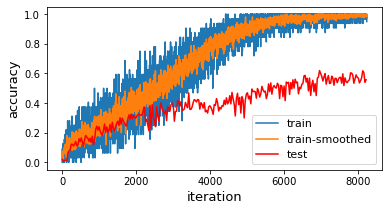

In [20]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),len(test_accs-1)*30+1)+1,30),test_accs,'red',label='test')
plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
plt.savefig('curves.png',dpi=200,bbox_inches='tight')